# Importing all libraries used during this assignment

In [191]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import warnings
from countrygroups import EUROPEAN_UNION
from countryinfo import CountryInfo
import glob
import requests
from functools import partial, reduce 
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
import fancyimpute
from scipy.stats import ks_2samp
import pycountry

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

pd.options.mode.use_inf_as_na = True

#managing warnings(ignoring them mostly)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)     
warnings.filterwarnings('ignore')

#setting display options
pd.set_option('display.max_columns', 200)
plt.rcParams['figure.figsize'] = (25, 14)
plt.style.use('seaborn-whitegrid')

from matplotlib.pyplot import cm
color = 'tab20c'

# Introduction to The Project

The brief of this project states that we must focus on the comparison of one irish agricultural sector to similar sectors worldwide. To begin with we will simply start by using data from FAOSTAT to compare the production of dairy products in ireland and other EU countries, after which we will extend our analysis to other countries around the world, such as USA or NZ. A handful of machine learning techniques will be used to make predictions regarding the milk production in these countries, most likely in the units of L/Hectare or L/cow. Throughout this project we will include sentiment analysts so that we may determine if changes in public sentiment reflect the currrent market conditions.

# Importing the Datasets, and building a dataset that we can use for our EDA, statistics, and machine learning

In [192]:
# importing the land data
land_df = pd.read_csv('/home/faelan/Desktop/MSc-Data-Analytics/CA_2/FAOSTAT_Land_Use.csv', on_bad_lines='skip')

# importing dairy products data
dairy_df = pd.read_csv('/home/faelan/Desktop/MSc-Data-Analytics/CA_2/FAOSTAT_DAIRY_DATA.csv', on_bad_lines='skip')

#importing producer price data
price_df = pd.read_csv('/home/faelan/Desktop/MSc-Data-Analytics/CA_2/Producer_milk_prices.csv', on_bad_lines='skip')

#importing export data
export_df = pd.read_csv('/home/faelan/Desktop/MSc-Data-Analytics/CA_2/import_export_prices.csv', on_bad_lines='skip')

#importing manure data
manure_df = pd.read_csv('/home/faelan/Desktop/MSc-Data-Analytics/CA_2/Manure_on_pasture.csv', on_bad_lines='skip')

#importing fertilizer data
fertilizer_df = pd.read_csv('/home/faelan/Desktop/MSc-Data-Analytics/CA_2/Fert_nutrient_agri.csv', on_bad_lines='skip')


#to deal with all of the temp and rain files we will create custom functions that put the year/country, and annual value in 
# a dataframe and then appends it to a list of dataframes. We will then concatenate all of the dataframes in the list into one
# dataframe

#function to process the csv files and get them in the formast we want in the final dataframe
def process(file, col_name):
    df = pd.read_csv(file, on_bad_lines='skip', skiprows=1)
        
    #change NaN column name
    df.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)
    #add acolumn that contains country code in each cell
    df['key'] = df.columns[1] + df['Year'].astype(str)
    df.rename(columns={df.columns[1]: col_name}, inplace=True)
    df = df.filter(['key', col_name] )
    return df

#function to create a dataframe from all of the csv files in a folder, and apply the pre processing steps 
#detailed in the process function
def files_to_df(path, col_name):
    csv_files = glob.glob(path + "/*.csv")
    df_list = (process(filename, col_name) for filename in csv_files)
    df = pd.concat(df_list, ignore_index=True)
    return df

#creating a dataframe for the rain data
rain_df = files_to_df('/home/faelan/Desktop/MSc-Data-Analytics/CA_2/Eu_rain_data', 'Rainfall_mm/yr')
 
#creating a dataframe for the temp data
temp_df = files_to_df('/home/faelan/Desktop/MSc-Data-Analytics/CA_2/EU_temp_data', 'Temperature_C')


# 1) Data Understanding/Preparation

### To kick this project off, we will focus on taking these datasets that we have imported above, and condense them down to a single dataset. We could certainly get away without going through these steps, but doing this now should save us a few headaches somewhere down the line. While we do this we will also encorporate some data preparation by constructing relevant attributes for EDA. This section exists purely to get a rough dataset put together, Eda and final cleaning will be carried out later on.

a) We are using the dairy products dataset as our jumping off point. This contains data related to many different products, but we will be mostly concerned with information related to Raw milk. We will isolate data related to this and use it as a base for the rest of our datasets

In [193]:

# look at the structure of the dairy data
dairy_df.head()

Domain Code                        Domain  Area Code (M49)         Area  \
0         QCL  Crops and livestock products                4  Afghanistan   
1         QCL  Crops and livestock products                4  Afghanistan   
2         QCL  Crops and livestock products                4  Afghanistan   
3         QCL  Crops and livestock products                4  Afghanistan   
4         QCL  Crops and livestock products                4  Afghanistan   

   Element Code     Element  Item Code (CPC)                Item  Year Code  \
0          5510  Production         22241.01  Butter of cow milk       1961   
1          5510  Production         22241.01  Butter of cow milk       1962   
2          5510  Production         22241.01  Butter of cow milk       1963   
3          5510  Production         22241.01  Butter of cow milk       1964   
4          5510  Production         22241.01  Butter of cow milk       1965   

   Year    Unit   Value Flag Flag Description  
0  1961  tonnes  7000.0    I    Imputed value  
1  1962  tonnes  7000.0    I    Imputed value  
2  1963  tonnes  8000.0    I    Imputed value  
3  1964  tonnes  8000.0    I    Imputed value  
4  1965  tonnes  9000.0    I    Imputed value

Okay, it looks like there are some years where the values for dairy products were not recorded. We will first look at the years present & the items for which data is available.

In [194]:
#find unique of dairy items in the dataset, and filter only the ones we want to see
print(dairy_df['Item'].unique())
items = ['Raw milk of cattle']

['Butter of cow milk' 'Cattle' 'Raw milk of cattle' 'Skim milk of cows'
 'Cheese from whole cow milk' 'Cheese from skimmed cow milk'
 'Skim milk and whey powder' 'Buttermilk, dry']


In [195]:
# what are the unique year values?
dairy_df['Year'].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020])

In [196]:
#filtering the data to only include the EU member states and items of interest
#at this stage i wont make a function to do this as we want this whole df as a base
#this process will be carried out often so we will make a function for it later
milk_eu_head = dairy_df[(dairy_df['Area'].isin(EUROPEAN_UNION.names)) & (dairy_df['Item'].isin(items)) & (dairy_df['Unit'] == 'Head')]#filtering the data to only include the EU member states and head of cattle
milk_eu_head['key'] = milk_eu_head['Area'] + milk_eu_head['Year'].astype(str)# creating a key column to merge the two datasets
milk_eu_tonne = dairy_df[(dairy_df['Area'].isin(EUROPEAN_UNION.names)) & (dairy_df['Item'].isin(items)) & (dairy_df['Unit'] == 'tonnes')]#filtering the data to only include the EU member states and tonnes of milk
milk_eu_tonne['key'] = milk_eu_tonne['Area'] + milk_eu_tonne['Year'].astype(str)# creating a key column to merge the two datasets

#merging the two datasets to get the total milk production in tonnes and the number of cows in one dataset
milk_eu = pd.merge(milk_eu_head, milk_eu_tonne[['key','Unit', 'Value']], on='key', how='left')#
milk_eu.drop(['Unit_x', 'Unit_y'], axis=1, inplace=True)#dropping the unit columns
milk_eu.rename(columns={'Value_x':'Head', 'Value_y':'Tonne'}, inplace=True)#renaming the value columns
milk_eu[(milk_eu['Area'] == 'Italy') & (milk_eu['Year'] == 2000)]

Domain Code                        Domain  Area Code (M49)   Area  \
746         QCL  Crops and livestock products              380  Italy   

     Element Code       Element  Item Code (CPC)                Item  \
746          5318  Milk Animals           2211.0  Raw milk of cattle   

     Year Code  Year       Head Flag Flag Description        key       Tonne  
746       2000  2000  2126000.0    A  Official figure  Italy2000  12309400.0

### b) Lets take a while to look at the Land use data now.

In [197]:
land_df.head()

Domain Code    Domain  Area Code (M49)         Area  Element Code Element  \
0          RL  Land Use                4  Afghanistan          5110    Area   
1          RL  Land Use                4  Afghanistan          5110    Area   
2          RL  Land Use                4  Afghanistan          5110    Area   
3          RL  Land Use                4  Afghanistan          5110    Area   
4          RL  Land Use                4  Afghanistan          5110    Area   

   Item Code                                   Item  Year Code  Year     Unit  \
0       6633  Land under temp. meadows and pastures       2001  2001  1000 ha   
1       6633  Land under temp. meadows and pastures       2002  2002  1000 ha   
2       6633  Land under temp. meadows and pastures       2003  2003  1000 ha   
3       6633  Land under temp. meadows and pastures       2004  2004  1000 ha   
4       6633  Land under temp. meadows and pastures       2005  2005  1000 ha   

   Value Flag Flag Description  
0    0.0    I    Imputed value  
1    0.0    I    Imputed value  
2    0.0    I    Imputed value  
3    0.0    I    Imputed value  
4    0.0    I    Imputed value

 Having looked at this data we can see that the land usage for temporary pastures & perminant pastures are given in a single column. We will first splot these into separate columns and add these together to get an idea of the TOTAL pasture area. To do this we will create two separate dataframes and merge them. Since looking at items individually and marging them will be a common theme, we will make a function to do this on our behalf. You could use pd.pivot() here, however im not a fan of how this leaves the dataframe formatting, so i would rather go this route. It also provides a greater degree of flexibility

In [198]:
#first we will make a list of the countries of interest
countries = milk_eu['Area'].unique().tolist()

##now we define our column value splitting function
def reformat(dataframe, column):
    container = {} #create an empty dictionary to store the dataframes
    for i in dataframe[column].unique(): #loop through the unique values in the column of interest
        container[f'{i}'] = dataframe[(dataframe[column] == i) & (dataframe['Area'].isin(countries))] #create a dataframe for each unique value in the column of interest
        container[f'{i}']['key'] = container[f'{i}']['Area'] + container[f'{i}']['Year'].astype(str)   #create a key column to merge the dataframes later

    for i in container: #loop through dataframes in the dict and apply some conditions
        container[i] = container[i][['key', 'Area', 'Value']]#filter the dataframes to only include the key, area and value columns
        container[i].rename(columns={'Value': f'{i}'}, inplace=True)#rename the value column to the name of the item


    my_reduce = partial(pd.merge, on=['key', 'Area'], how='right')  #create a function to merge the dataframes in the dict                                                           
    df =  reduce(my_reduce, container.values()) #calling that function on the values in the dict
    return df

#calling the function on the land data
total_pasture = reformat(land_df, 'Item')
#replace NaN with 0 in the temporary pasture column, /i am taking nan values to indicate an absence of that type of pasture
total_pasture['Land under temp. meadows and pastures'].fillna(0, inplace=True)

#merge the total pasture data with the milk data
milk_eu = pd.merge(milk_eu, total_pasture, on=['key', 'Area'], how='left')
milk_eu[(milk_eu['Area'] == 'Italy') & (milk_eu['Year'] == 2000)]


Domain Code                        Domain  Area Code (M49)   Area  \
746         QCL  Crops and livestock products              380  Italy   

     Element Code       Element  Item Code (CPC)                Item  \
746          5318  Milk Animals           2211.0  Raw milk of cattle   

     Year Code  Year       Head Flag Flag Description        key       Tonne  \
746       2000  2000  2126000.0    A  Official figure  Italy2000  12309400.0   

     Land under temp. meadows and pastures  \
746                                    0.0   

     Land under perm. meadows and pastures  
746                                 4353.0

### c) Now lets look at how much a farmer gets paid for she milk s/he produces. This may be an important indicator for predicting the milk production or productivity in the future. It will certainly be a great thing to have for data analysis on the topic.

In [199]:
price_df.head()

Domain Code           Domain  Area Code (M49)     Area  Element Code  \
0          PP  Producer Prices               40  Austria          5532   
1          PP  Producer Prices               40  Austria          5532   
2          PP  Producer Prices               40  Austria          5532   
3          PP  Producer Prices               40  Austria          5532   
4          PP  Producer Prices               40  Austria          5532   

                      Element  Item Code (CPC)                Item  Year Code  \
0  Producer Price (USD/tonne)             2211  Raw milk of cattle       1991   
1  Producer Price (USD/tonne)             2211  Raw milk of cattle       1992   
2  Producer Price (USD/tonne)             2211  Raw milk of cattle       1993   
3  Producer Price (USD/tonne)             2211  Raw milk of cattle       1994   
4  Producer Price (USD/tonne)             2211  Raw milk of cattle       1995   

   Year  Months Code        Months Unit  Value Flag Flag Description  
0  1991         7021  Annual value  USD  454.8    A  Official figure  
1  1992         7021  Annual value  USD  499.6    A  Official figure  
2  1993         7021  Annual value  USD  468.6    A  Official figure  
3  1994         7021  Annual value  USD  478.9    A  Official figure  
4  1995         7021  Annual value  USD  372.9    A  Official figure

In [200]:
price_df.Year.unique()

array([1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [201]:
#we want to filter the dataframe by countries, making sure that we only have eu member states
price_df = price_df[price_df['Area'].isin(countries)]
#filter the Months column to show only annual value
price_df = price_df[price_df['Months'] == 'Annual value']
#make a key column to merge the data
price_df['key'] = price_df['Area'] + price_df['Year'].astype(str)
#merge the data onto the milk_euy dataframe
milk_eu = pd.merge(milk_eu, price_df[['key', 'Value']], on='key', how='left')
#since prices are only recorded after 1990 we will filter the years
milk_eu = milk_eu[milk_eu['Year'] > 1990]
milk_eu.shape

(783, 18)

### d) almost there for the dataset construction. We will now look at the quantity of milk exported from the countries

In [202]:
print(milk_eu.shape)
#reformat the dataframe using our lovely function
export_info_df = reformat(export_df, 'Element')
#and simply merge this onto ourt milk_eu dataframe
milk_eu = pd.merge(milk_eu, export_info_df[['key', 'Export Value', 'Export Quantity']], on='key', how = 'left')
milk_eu[(milk_eu['Area'] == 'Spain') & (milk_eu['Year'] == 2000)]

(783, 18)


Domain Code                        Domain  Area Code (M49)   Area  \
732         QCL  Crops and livestock products              724  Spain   

     Element Code       Element  Item Code (CPC)                Item  \
732          5318  Milk Animals           2211.0  Raw milk of cattle   

     Year Code  Year       Head Flag Flag Description        key      Tonne  \
732       2000  2000  1141000.0    A  Official figure  Spain2000  6106628.0   

     Land under temp. meadows and pastures  \
732                                    0.0   

     Land under perm. meadows and pastures  Value  Export Value  \
732                                11462.0  252.3       61407.0   

     Export Quantity  
732         158316.0

### e) Append the temperature and rain data to the milk_eu dataframe

In [203]:
temp_df.head()

key  Temperature_C
0  Romania1901           9.17
1  Romania1902           8.27
2  Romania1903           9.53
3  Romania1904           8.91
4  Romania1905           9.14

In [204]:
rain_df.head()

key  Rainfall_mm/yr
0  Bulgaria1901          745.45
1  Bulgaria1902          604.44
2  Bulgaria1903          552.47
3  Bulgaria1904          524.68
4  Bulgaria1905          614.19

In [205]:

milk_eu = pd.merge(milk_eu, temp_df, on='key', how='left')
milk_eu = pd.merge(milk_eu, rain_df, on='key', how='left')
milk_eu[(milk_eu['Area'] == 'Italy') & (milk_eu['Year'] == 2000)]

Domain Code                        Domain  Area Code (M49)   Area  \
416         QCL  Crops and livestock products              380  Italy   

     Element Code       Element  Item Code (CPC)                Item  \
416          5318  Milk Animals           2211.0  Raw milk of cattle   

     Year Code  Year       Head Flag Flag Description        key       Tonne  \
416       2000  2000  2126000.0    A  Official figure  Italy2000  12309400.0   

     Land under temp. meadows and pastures  \
416                                    0.0   

     Land under perm. meadows and pastures  Value  Export Value  \
416                                 4353.0    NaN        6804.0   

     Export Quantity  Temperature_C  Rainfall_mm/yr  
416          11797.0          13.37          802.66

### f) Last part of the dataset construction, lets get this shit sorted... were looking at manure and fertiliser used for pasture land.

In [206]:
manure_df.head()

Domain Code            Domain  Area Code (M49)         Area  Element Code  \
0         EMN  Livestock Manure                4  Afghanistan         72380   
1         EMN  Livestock Manure                4  Afghanistan         72380   
2         EMN  Livestock Manure                4  Afghanistan         72380   
3         EMN  Livestock Manure                4  Afghanistan         72380   
4         EMN  Livestock Manure                4  Afghanistan         72380   

                              Element Item Code (CPC)           Item  \
0  Manure left on pasture (N content)           F0960  Cattle, dairy   
1  Manure left on pasture (N content)           F0960  Cattle, dairy   
2  Manure left on pasture (N content)           F0960  Cattle, dairy   
3  Manure left on pasture (N content)           F0960  Cattle, dairy   
4  Manure left on pasture (N content)           F0960  Cattle, dairy   

   Year Code  Year Unit         Value Flag Flag Description  
0       1961  1961   kg  1.733727e+07    E  Estimated value  
1       1962  1962   kg  1.733727e+07    E  Estimated value  
2       1963  1963   kg  1.931867e+07    E  Estimated value  
3       1964  1964   kg  1.931867e+07    E  Estimated value  
4       1965  1965   kg  2.154775e+07    E  Estimated value

In [207]:
#filter the dataframe for only eu memberstate countries
manure_df = manure_df[manure_df['Area'].isin(countries)]
#create a key column to merge the data
manure_df['key'] = manure_df['Area'] + manure_df['Year'].astype(str)
#rename the value column to manure_kg
manure_df.rename(columns={'Value': 'Manure_kg'}, inplace=True)
#merge the data onto the milk_eu dataframe
milk_eu = pd.merge(milk_eu, manure_df[['key', 'Manure_kg']], on='key', how = 'left')

In [208]:
fert_df = reformat(fertilizer_df, 'Item')
milk_eu = pd.merge(milk_eu, fert_df, on=['key', 'Area'], how = 'left')
milk_eu[(milk_eu['Area'] == 'Italy') & (milk_eu['Year'] == 2000)]

Domain Code                        Domain  Area Code (M49)   Area  \
416         QCL  Crops and livestock products              380  Italy   

     Element Code       Element  Item Code (CPC)                Item  \
416          5318  Milk Animals           2211.0  Raw milk of cattle   

     Year Code  Year       Head Flag Flag Description        key       Tonne  \
416       2000  2000  2126000.0    A  Official figure  Italy2000  12309400.0   

     Land under temp. meadows and pastures  \
416                                    0.0   

     Land under perm. meadows and pastures  Value  Export Value  \
416                                 4353.0    NaN        6804.0   

     Export Quantity  Temperature_C  Rainfall_mm/yr   Manure_kg  \
416          11797.0          13.37          802.66  44697024.0   

     Nutrient nitrogen N (total)  Nutrient phosphate P2O5 (total)  \
416                     828000.0                         504000.0   

     Nutrient potash K2O (total)  
416                     400000.0

In [209]:
milk_eu[milk_eu['Area'] == 'Spain'].head()

Domain Code                        Domain  Area Code (M49)   Area  \
723         QCL  Crops and livestock products              724  Spain   
724         QCL  Crops and livestock products              724  Spain   
725         QCL  Crops and livestock products              724  Spain   
726         QCL  Crops and livestock products              724  Spain   
727         QCL  Crops and livestock products              724  Spain   

     Element Code       Element  Item Code (CPC)                Item  \
723          5318  Milk Animals           2211.0  Raw milk of cattle   
724          5318  Milk Animals           2211.0  Raw milk of cattle   
725          5318  Milk Animals           2211.0  Raw milk of cattle   
726          5318  Milk Animals           2211.0  Raw milk of cattle   
727          5318  Milk Animals           2211.0  Raw milk of cattle   

     Year Code  Year       Head Flag Flag Description        key      Tonne  \
723       1991  1991  1566000.0    A  Official figure  Spain1991  6673700.0   
724       1992  1992  1454000.0    A  Official figure  Spain1992  6183900.0   
725       1993  1993  1379000.0    A  Official figure  Spain1993  6159200.0   
726       1994  1994  1338000.0    A  Official figure  Spain1994  6030300.0   
727       1995  1995  1292000.0    A  Official figure  Spain1995  6203500.0   

     Land under temp. meadows and pastures  \
723                                    0.0   
724                                    0.0   
725                                    0.0   
726                                    0.0   
727                                    0.0   

     Land under perm. meadows and pastures  Value  Export Value  \
723                                10282.0  336.7        1076.0   
724                                10332.0  342.1        1127.0   
725                                10376.0  299.9        6901.0   
726                                10687.0  321.5       21037.0   
727                                10966.0  353.1       35133.0   

     Export Quantity  Temperature_C  Rainfall_mm/yr   Manure_kg  \
723           2501.0          13.37          566.39  32923584.0   
724           2022.0          13.34          568.24  30568896.0   
725          15367.0          12.93          607.67  28992096.0   
726          46237.0          13.98          521.81  28130112.0   
727          67589.0          14.30          547.02  27163008.0   

     Nutrient nitrogen N (total)  Nutrient phosphate P2O5 (total)  \
723                     998705.0                         501655.0   
724                     817621.0                         423177.0   
725                     929300.0                         496390.0   
726                     982500.0                         520900.0   
727                     912800.0                         509900.0   

     Nutrient potash K2O (total)  
723                     381382.0  
724                     334000.0  
725                     392000.0  
726                     424000.0  
727                     446000.0

In [210]:
milk_eu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783 entries, 0 to 782
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Domain Code                            783 non-null    object 
 1   Domain                                 783 non-null    object 
 2   Area Code (M49)                        783 non-null    int64  
 3   Area                                   783 non-null    object 
 4   Element Code                           783 non-null    int64  
 5   Element                                783 non-null    object 
 6   Item Code (CPC)                        783 non-null    float64
 7   Item                                   783 non-null    object 
 8   Year Code                              783 non-null    int64  
 9   Year                                   783 non-null    int64  
 10  Head                                   783 non-null    float64
 11  Flag  

<AxesSubplot:>

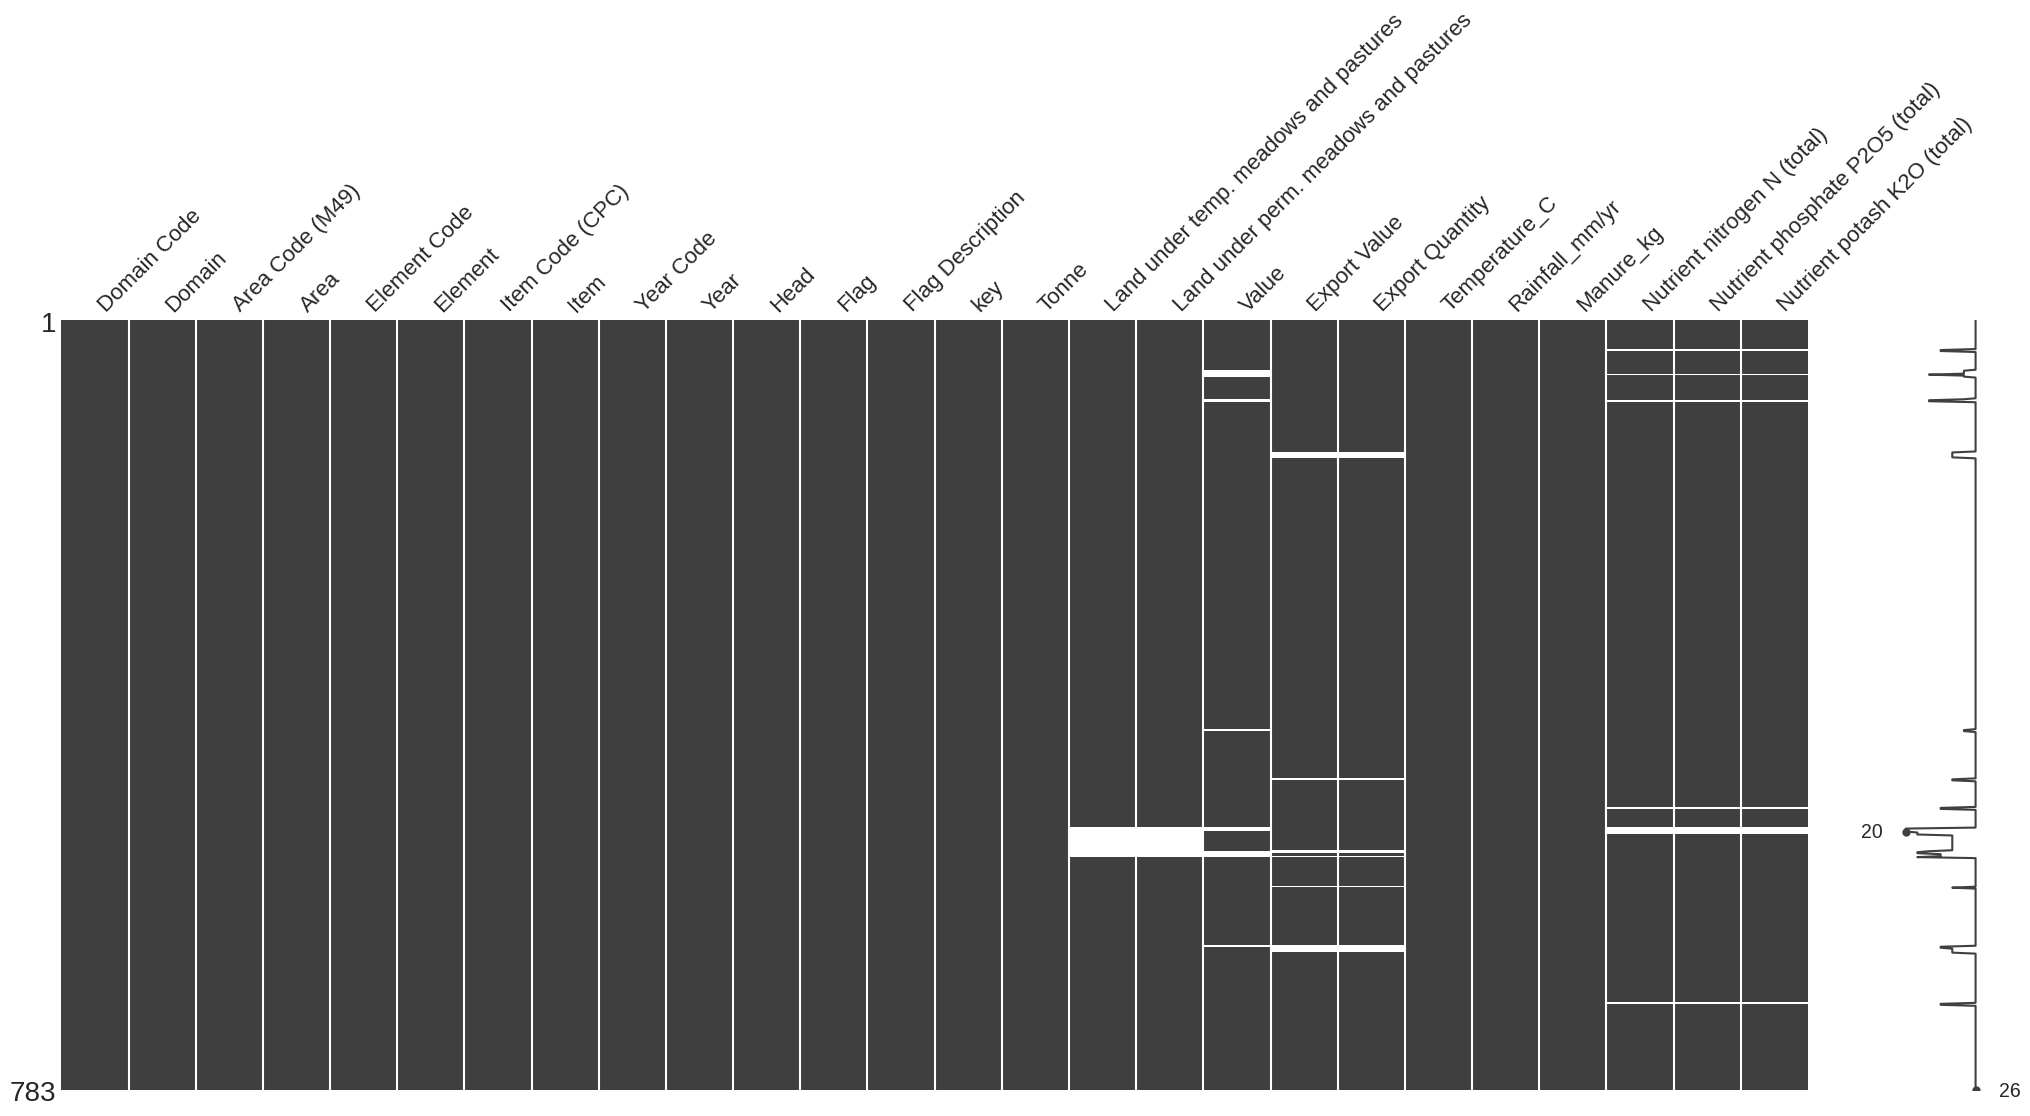

In [211]:
msno.matrix(milk_eu)

Theres a few things we will need to look at before moving forward here
* Missing values in the meadows and pastures data
* Misssing values in the Exports Data
* Missing values in the fertilizer data

I will address these in the following section & determine the best approach on a case by case basis.

# 2) Data cleaning & feature engineering stage

Lets kick things off by building a function that will loop over many imputation techniques and will compare their results, spitting out the best one. 

In [212]:
#dropping redundant columns
milk_eu.drop(['Domain Code', 'Domain', 'Area Code (M49)',
 'Element Code', 'Element', 'Item Code (CPC)', 'Item', 'Year Code', 'Flag', 'key', 'Flag Description'], axis=1, inplace=True)

In [213]:
from scipy.stats import ks_2samp
def impute_data(milk_eu, columns, k, iter, target):
    #defining the imputation methods
    imputation_type = ['.mean()', '.mode()', '.median()','bfill', 'ffill', 'knn', 'mice']
    #dropping null columns and making nan values are np.nan format
    milk_eu_imp = milk_eu.fillna(np.nan).drop(columns, axis=1).select_dtypes(exclude=['object'])

    results = {}#creating a dictionary to store the results
    best = {}#creating a dictionary to store the best results

    #defining the mannwhitneyu test
    def score_dataset(milk_eu, impute):
        u, p = ks_2samp(milk_eu.dropna(), impute)
        return p #returning the p value

    #looping through the columns to be imputed
    for col in columns:

        #defining the imputation methods in a dictionary to allow iteration
        #this is done to avoid having to write out each method individually
        functions = {
        'mean': milk_eu[col].mean(),
        'mode': milk_eu[col].mode(),
        'median': milk_eu[col].median(),
        'bfill': milk_eu[col].fillna(method='bfill'),
        'ffill': milk_eu[col].fillna(method='ffill')
    }

        #looping through the imputation methods
        for type in imputation_type:

            if type in functions:#if the imputation method is in the dictionary
                impute = functions[type]
                results[f'{type}_{col}'] = score_dataset(milk_eu[col], impute)#adding the results to the results dictionary

            elif type == 'knn':#if the imputation method is knn
                for i in k:#looping through the k values
                    milk_eu_imp[col] = milk_eu[col].fillna(np.nan)
                    impute = pd.DataFrame(fancyimpute.KNN(k=i, verbose=False).fit_transform(milk_eu_imp))
                    impute.columns = milk_eu_imp.columns #setting the column names to the original column names
                    results[f'{type}_{i}_{col}'] = score_dataset(milk_eu[col], impute[col])#adding the results to the results dictionary

            elif type == 'mice':#if the imputation method is mice
                for iterations in iter:#looping through the iterations
                    milk_eu_imp[col] = milk_eu[col].fillna(np.nan)
                    imputed = pd.DataFrame(fancyimpute.IterativeImputer(max_iter=iterations).fit_transform(milk_eu_imp))
                    impute.columns = milk_eu_imp.columns #setting the column names to the original column names
                    results[f'{type}_{iterations}_{col}'] = score_dataset(milk_eu[col], impute[col]) #adding the results to the results dictionary 

        #put max value in 'best' dict, this returrns the best imputation method
        best[col] = max(results, key=results.get)
        
    return results, best

In [214]:
milk_eu.isna().sum()

Area                                      0
Year                                      0
Head                                      0
Tonne                                     0
Land under temp. meadows and pastures    30
Land under perm. meadows and pastures    30
Value                                    24
Export Value                             20
Export Quantity                          20
Temperature_C                             0
Rainfall_mm/yr                            0
Manure_kg                                 0
Nutrient nitrogen N (total)              16
Nutrient phosphate P2O5 (total)          16
Nutrient potash K2O (total)              16
dtype: int64

### a) First we will deal with the missing values using the method constructed above

In [215]:
#defining the function inputs

columns = [i for i in milk_eu.columns if milk_eu[i].isnull().any()] #columns containing null values
k = [1, 3, 5, 7, 9, 11] #number of neighbours for knn imputation
iter = [20, 40, 60, 80, 100, 120] #number of iterations for mice imputation

#calling the function
results_imp, best_imp = impute_data(milk_eu, columns, k, iter, 'Tonne')

In [216]:
results_imp

{'bfill_Land under temp. meadows and pastures': 0.9763074856261597,
 'ffill_Land under temp. meadows and pastures': 0.987699161731823,
 'knn_1_Land under temp. meadows and pastures': 0.9808304902895341,
 'knn_3_Land under temp. meadows and pastures': 0.9812473137511066,
 'knn_5_Land under temp. meadows and pastures': 0.9832349866494021,
 'knn_7_Land under temp. meadows and pastures': 0.9860945202912247,
 'knn_9_Land under temp. meadows and pastures': 0.9860945202912247,
 'knn_11_Land under temp. meadows and pastures': 0.9860945202912247,
 'mice_20_Land under temp. meadows and pastures': 0.9860945202912247,
 'mice_40_Land under temp. meadows and pastures': 0.9860945202912247,
 'mice_60_Land under temp. meadows and pastures': 0.9860945202912247,
 'mice_80_Land under temp. meadows and pastures': 0.9860945202912247,
 'mice_100_Land under temp. meadows and pastures': 0.9860945202912247,
 'mice_120_Land under temp. meadows and pastures': 0.9860945202912247,
 'bfill_Land under perm. meadows a

It appears as though the best imputation method for most of our columns is the forward filling method. This is great for us as it really speeeds up imputing the data, we will do this below.

In [217]:
#we can see from the results above that knn imputation will work very well for all of the columns so we will use it now
columns = [i for i in milk_eu.columns if milk_eu[i].isnull().any()] #columns containing null values
#imputing the data using ffll
milk_eu[columns] = milk_eu[columns].fillna(method='ffill')





In [218]:
milk_eu.isnull().sum()

Area                                     0
Year                                     0
Head                                     0
Tonne                                    0
Land under temp. meadows and pastures    0
Land under perm. meadows and pastures    0
Value                                    0
Export Value                             0
Export Quantity                          0
Temperature_C                            0
Rainfall_mm/yr                           0
Manure_kg                                0
Nutrient nitrogen N (total)              0
Nutrient phosphate P2O5 (total)          0
Nutrient potash K2O (total)              0
dtype: int64

array([[<AxesSubplot:title={'center':'Year'}>,
        <AxesSubplot:title={'center':'Head'}>,
        <AxesSubplot:title={'center':'Tonne'}>,
        <AxesSubplot:title={'center':'Land under temp. meadows and pastures'}>],
       [<AxesSubplot:title={'center':'Land under perm. meadows and pastures'}>,
        <AxesSubplot:title={'center':'Value'}>,
        <AxesSubplot:title={'center':'Export Value'}>,
        <AxesSubplot:title={'center':'Export Quantity'}>],
       [<AxesSubplot:title={'center':'Temperature_C'}>,
        <AxesSubplot:title={'center':'Rainfall_mm/yr'}>,
        <AxesSubplot:title={'center':'Manure_kg'}>,
        <AxesSubplot:title={'center':'Nutrient nitrogen N (total)'}>],
       [<AxesSubplot:title={'center':'Nutrient phosphate P2O5 (total)'}>,
        <AxesSubplot:title={'center':'Nutrient potash K2O (total)'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

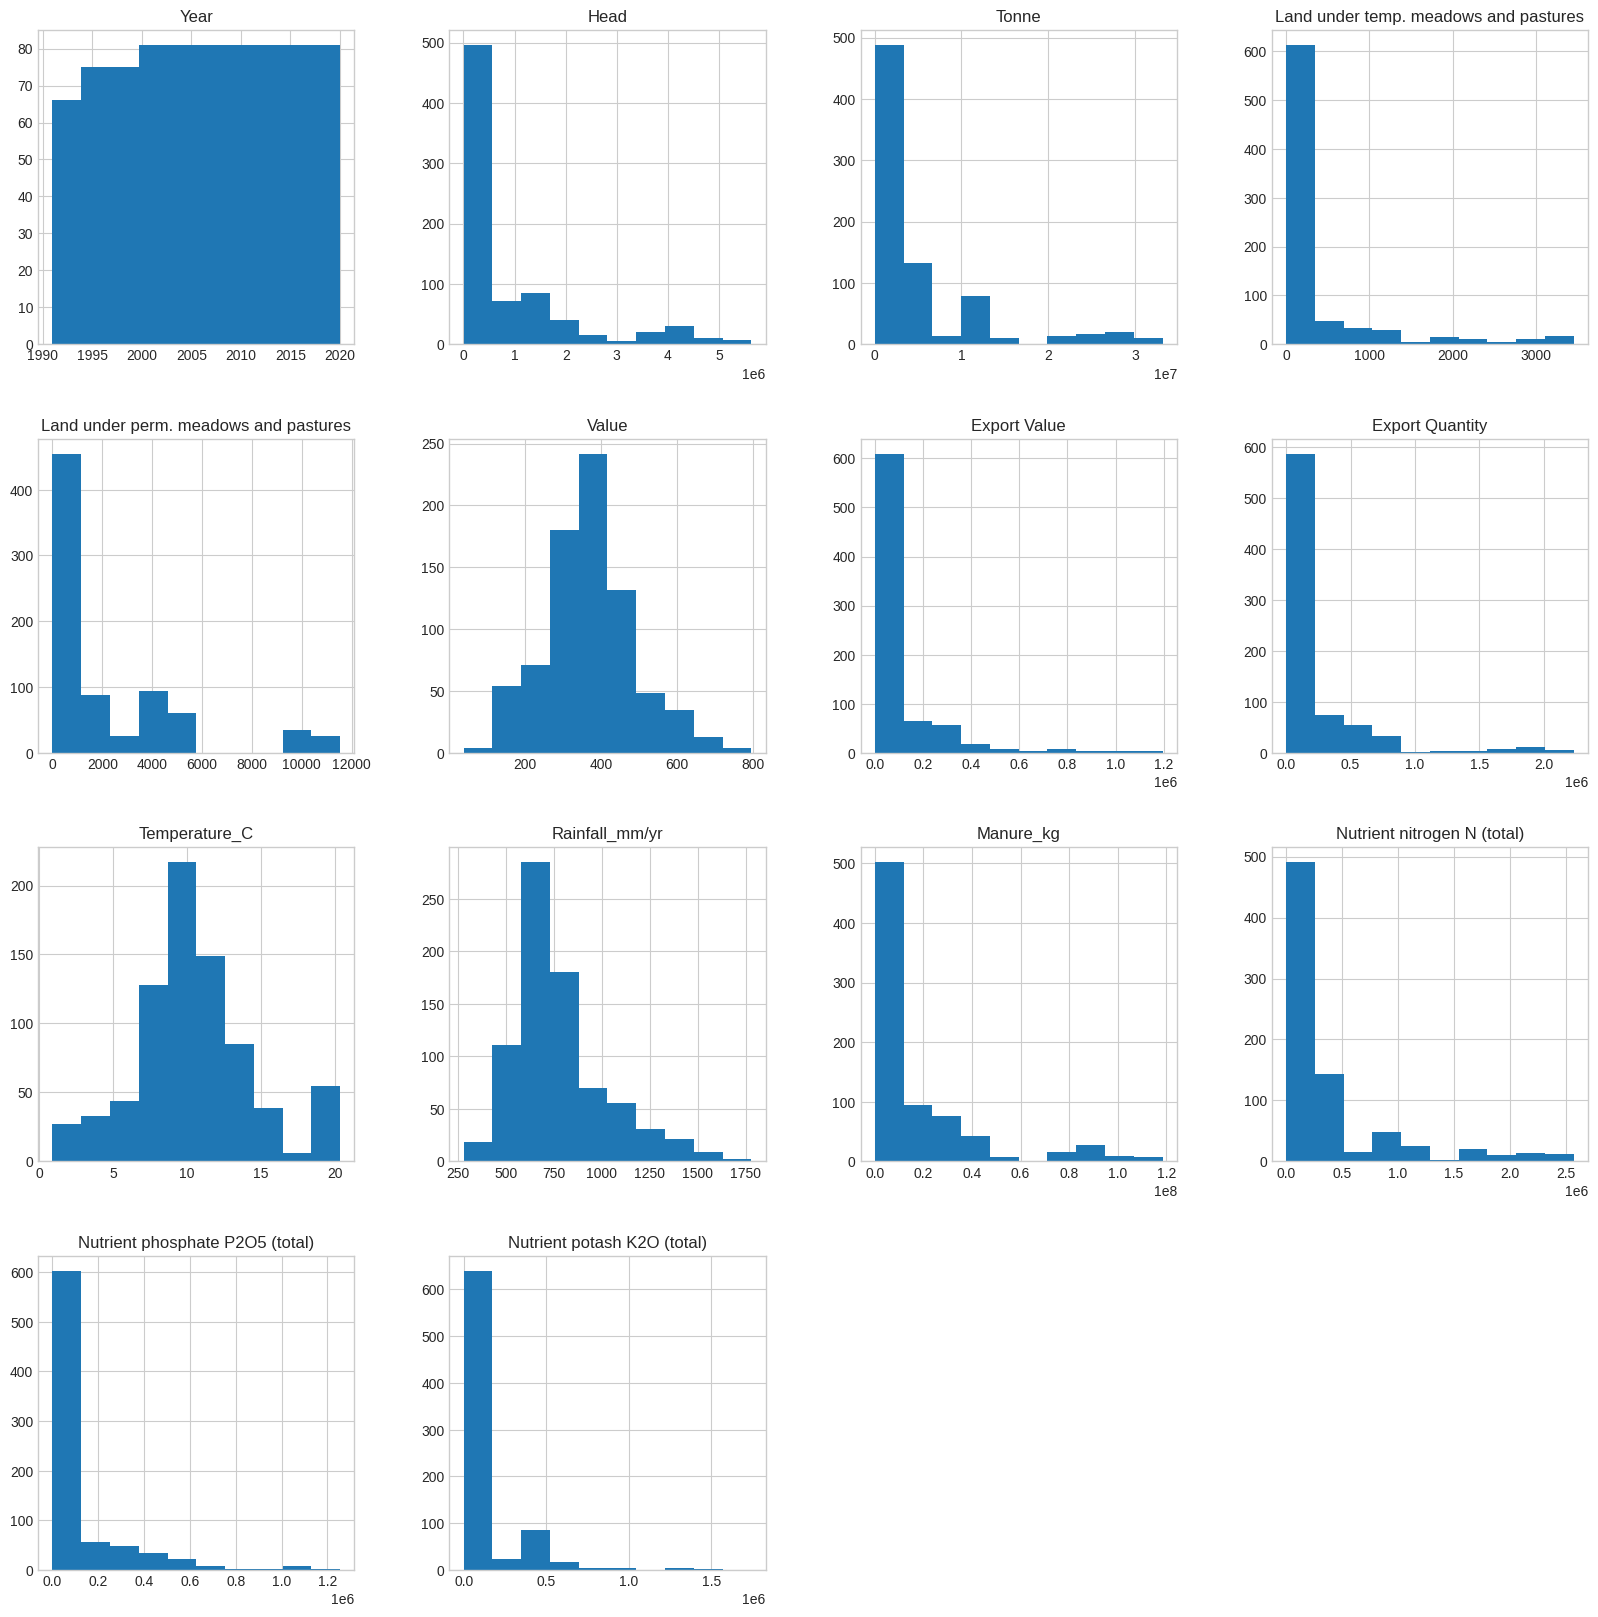

In [219]:
#plot all the numerical columns 
milk_eu.hist(figsize=(20,20))


In [220]:
milk_eu.describe()

Year          Head         Tonne  \
count   783.000000  7.830000e+02  7.830000e+02   
mean   2005.905492  9.237232e+05  5.225249e+06   
std       8.508534  1.198630e+06  7.179461e+06   
min    1991.000000  6.000000e+03  3.306100e+04   
25%    1999.000000  2.134515e+05  8.104895e+05   
50%    2006.000000  3.909000e+05  2.447342e+06   
75%    2013.000000  1.195672e+06  5.374900e+06   
max    2020.000000  5.632000e+06  3.316491e+07   

       Land under temp. meadows and pastures  \
count                             783.000000   
mean                              347.294250   
std                               720.630026   
min                                 0.000000   
25%                                 0.000000   
50%                                33.140000   
75%                               227.150000   
max                              3454.800000   

       Land under perm. meadows and pastures       Value  Export Value  \
count                             783.000000  783.000000  7.830000e+02   
mean                             2209.259616  369.797829  9.862057e+04   
std                              2821.211214  118.457542  1.808037e+05   
min                                 1.000000   39.200000  0.000000e+00   
25%                               372.420000  304.500000  1.160000e+03   
50%                               876.300000  365.600000  2.201200e+04   
75%                              3897.900000  433.750000  1.068040e+05   
max                             11533.000000  794.300000  1.195006e+06   

       Export Quantity  Temperature_C  Rainfall_mm/yr     Manure_kg  \
count     7.830000e+02     783.000000      783.000000  7.830000e+02   
mean      2.052257e+05      10.453755      774.282388  1.762689e+07   
std       3.742659e+05       3.973331      241.525639  2.402044e+07   
min       0.000000e+00       0.910000      278.420000  1.261440e+05   
25%       3.235500e+03       8.255000      621.215000  3.771227e+06   
50%       4.803487e+04      10.120000      719.510000  7.315700e+06   
75%       2.232331e+05      12.330000      867.655000  2.180707e+07   
max       2.233207e+06      20.350000     1780.040000  1.184072e+08   

       Nutrient nitrogen N (total)  Nutrient phosphate P2O5 (total)  \
count                 7.830000e+02                     7.830000e+02   
mean                  3.849413e+05                     1.160936e+05   
std                   5.362020e+05                     1.802707e+05   
min                   4.072000e+02                     6.000000e+00   
25%                   8.978700e+04                     1.897200e+04   
50%                   1.831510e+05                     4.609200e+04   
75%                   3.596760e+05                     1.130000e+05   
max                   2.571400e+06                     1.255000e+06   

       Nutrient potash K2O (total)  
count                 7.830000e+02  
mean                  1.267529e+05  
std                   2.195068e+05  
min                   1.300000e+01  
25%                   1.868750e+04  
50%                   4.568300e+04  
75%                   9.440100e+04  
max                   1.741000e+06

Great, now that this is done we can move along to some more exciting tasks... Feature engineering & EDA!

b) Feature Engineering - Calculated Columns

In [221]:
milk_eu_eda = milk_eu.copy()

Our first port of call will be to prepare the dataset for plotting a choropleth map. This means that we need the 3 letter code that corresponds to each country in the dataset. Conveniently the pycountry library makes this very easy for us.

In [222]:
#converting country name to country code, this will be needed for the choropleth map
import pycountry
def country_name_to_country_code(country_name):
    country_code = pycountry.countries.search_fuzzy(country_name)[0].alpha_3
    return country_code

#now applying this to the dataframe
milk_eu_eda['Country Code'] = milk_eu_eda['Area'].apply(country_name_to_country_code)

For our investigations it may be beneficial to know the amount of milk exported in terms of volume, specifically litres. To convert tonnes to litres, we simply look back to our beginner physics  class and remember the following formula,

$$ V = \frac{m}{\rho{}} $$
 
where V is volume, m is mass. and  $\rho{}$  is the density. The density for raw milk will be 1.027kg/m3 on average at a temperature of 20c.

nice to finally be making good use of that physics degree...

In [223]:
#function to convert tonnes to litres
def volume(x):
    return x*1000/1.027

milk_eu_eda['volume(litre)'] = milk_eu_eda['Tonne'].apply(volume)#Icould probably have used a lambda function here, but i might use the volume function later so no harm having close to hand
milk_eu_eda['volume/cow(litre)'] = milk_eu_eda['volume(litre)']/milk_eu['Head']
milk_eu_eda

Area  Year      Head      Tonne  \
0    Austria  1991  865392.0  3329700.0   
1    Austria  1992  841099.0  3286583.0   
2    Austria  1993  817935.0  3269622.0   
3    Austria  1994  804264.0  3278429.0   
4    Austria  1995  638339.0  2948170.0   
..       ...   ...       ...        ...   
778   Sweden  2016  326122.0  2862000.0   
779   Sweden  2017  326440.0  2816660.0   
780   Sweden  2018  313050.0  2760230.0   
781   Sweden  2019  301380.0  2704390.0   
782   Sweden  2020  304400.0  2772740.0   

     Land under temp. meadows and pastures  \
0                                     0.00   
1                                     0.00   
2                                     0.00   
3                                     0.00   
4                                     0.00   
..                                     ...   
778                                1052.56   
779                                1035.11   
780                                1048.39   
781                                1084.50   
782                                1064.81   

     Land under perm. meadows and pastures  Value  Export Value  \
0                                  1512.90  454.8        2543.0   
1                                  1507.00  499.6        3884.0   
2                                  1501.00  468.6        2992.0   
3                                  1495.10  478.9        2645.0   
4                                  1489.10  372.9       29680.0   
..                                     ...    ...           ...   
778                                 451.94  360.5        9551.0   
779                                 452.94  448.7       10348.0   
780                                 455.14  461.2        4732.0   
781                                 461.28  418.3        5328.0   
782                                 463.52  430.9        6694.0   

     Export Quantity  Temperature_C  Rainfall_mm/yr     Manure_kg  \
0            3430.00           6.30         1080.48  1.819400e+07   
1            4879.00           7.45         1066.12  1.768327e+07   
2            3960.00           6.86         1049.61  1.719627e+07   
3            3356.00           8.11         1029.76  1.690885e+07   
4           63851.00           6.83         1144.60  1.342044e+07   
..               ...            ...             ...           ...   
778         12499.16           3.44          625.78  6.856389e+06   
779          9563.42           3.16          678.22  6.863075e+06   
780          3610.94           3.62          539.63  6.581563e+06   
781          5833.08           3.34          682.36  6.336213e+06   
782          5966.04           4.47          669.34  6.399706e+06   

     Nutrient nitrogen N (total)  Nutrient phosphate P2O5 (total)  \
0                      132000.00                         70400.00   
1                      124000.00                         65000.00   
2                      120000.00                         64000.00   
3                      121000.00                         56000.00   
4                      125000.00                         52000.00   
..                           ...                              ...   
778                    186042.81                         30029.00   
779                    198459.65                         32954.64   
780                    184187.00                         32721.00   
781                    182664.00                         29409.00   
782                    215171.00                         38110.00   

     Nutrient potash K2O (total) Country Code  volume(litre)  \
0                        86300.0          AUT   3.242162e+09   
1                        78000.0          AUT   3.200178e+09   
2                        78000.0          AUT   3.183663e+09   
3                        73000.0          AUT   3.192239e+09   
4                        60000.0          AUT   2.870662e+09   
..                           ...          ...            ...   
778                      35

We eould now like to know more about the total pasture land taken up by farming in each EU country. We will simply find the sum of perminant and temporary pasture land to find the total pasture land area in each country. Following this we will find the dutface area of each country, I could just google all the surface area values, but honestly who has the time. Thankfully some group of beautiful nerds made a python library that just so happens to contain this data for our convenience. Using all of this we will finally calculate the percentage of land area in each country that is used for pasture.

In [224]:
#calculating the total pasture by adding temporary and permanent pasture
milk_eu_eda['Total Pasture(ha)'] = milk_eu_eda['Land under perm. meadows and pastures'] + milk_eu['Land under temp. meadows and pastures']
#converting the data to hectares instead of 1000s of hectares
milk_eu_eda['Total Pasture(ha)'] = milk_eu_eda['Total Pasture(ha)'].apply(lambda x: x*1000)


In [225]:
#finding surface area of each country(thanks wikipedia) in the dataset in hectares, and make a dataframe
Surface_area_countries = [] #creating an empty list to store the surface area
for i in countries:#looping through the countries in the list
   if i == 'Czechia': #changing the name of the country to match the name in the countryinfo library
         i = 'Czech Republic'
   country = CountryInfo(i)#getting the country info
   area = country.area()#getting the area
   Surface_area_countries.append(area*100)#converting to hectares from km^2 and appending to the list

#making a dataframe of the surface area
area_df = pd.DataFrame({'Area': countries, 'Surface Area': Surface_area_countries})
#we are going to merge the area dataframe on countries
milk_eu_eda = pd.merge(milk_eu_eda, area_df, on='Area', how='left')

#calculating the percentage of pasture to total area
milk_eu_eda['% Pasture'] = milk_eu_eda['Total Pasture(ha)']/milk_eu_eda['Surface Area']

In the milk_eu dataframe we have the amount of money, value, paid to producers per tonne in usd. We will use this to calculate the total revenue earned by producers in each country

In [226]:
#Calculating the revenue from milk
milk_eu_eda['Revenue(usd)'] = milk_eu_eda['Tonne']*milk_eu_eda['Value']

#calculating the revenue per cow
milk_eu_eda['Revenue per cow(usd)'] = milk_eu_eda['Revenue(usd)']/milk_eu_eda['Head']

#calculating the revenue per hectare
milk_eu_eda['Revenue per hectare(usd)'] = milk_eu_eda['Revenue(usd)']/milk_eu_eda['Total Pasture(ha)']

#calculating the price per litre
milk_eu_eda['Price per litre(usd)'] = milk_eu_eda['Value']/(1000/1.027)

In [227]:
milk_eu_eda.isnull().sum()

Area                                     0
Year                                     0
Head                                     0
Tonne                                    0
Land under temp. meadows and pastures    0
Land under perm. meadows and pastures    0
Value                                    0
Export Value                             0
Export Quantity                          0
Temperature_C                            0
Rainfall_mm/yr                           0
Manure_kg                                0
Nutrient nitrogen N (total)              0
Nutrient phosphate P2O5 (total)          0
Nutrient potash K2O (total)              0
Country Code                             0
volume(litre)                            0
volume/cow(litre)                        0
Total Pasture(ha)                        0
Surface Area                             0
% Pasture                                0
Revenue(usd)                             0
Revenue per cow(usd)                     0
Revenue per

Finally we would like to have columns in the dataset which show the export volume & export value per litre

In [228]:
#find the volume of milk exported per country
milk_eu_eda['Exported volume'] = milk_eu_eda['Export Quantity']*1000/1.027
#we want to add an export usd per litre column
milk_eu_eda['Export Value'] = milk_eu_eda['Export Value']*1000
milk_eu_eda['Export Value per litre(USD)'] = milk_eu_eda['Export Value']/milk_eu_eda['Exported volume']

In [229]:
milk_eu_eda[milk_eu_eda['Exported volume'] == 0]

Area  Year      Head      Tonne  \
59   Bulgaria  1999  421428.0  1388800.0   
110    Cyprus  1991   16903.0   104000.0   
112    Cyprus  1993   16604.0   118000.0   
113    Cyprus  1994   20203.0   126000.0   
123    Cyprus  2004   20715.0   151220.0   
124    Cyprus  2005   19349.0   147300.0   
126    Cyprus  2007   19291.0   144100.0   
129    Cyprus  2010   19113.0   151015.0   
198   Estonia  1992  260336.0   918956.0   
516     Malta  1991    6300.0    34964.0   
517     Malta  1992    8784.0    51422.0   
518     Malta  1993    8614.0    50275.0   
519     Malta  1994    8026.0    46322.0   
520     Malta  1995    6000.0    33061.0   
521     Malta  1996    8600.0    41000.0   
522     Malta  1997    9800.0    47001.0   
526     Malta  2001    8200.0    46888.0   
529     Malta  2004    7607.0    41122.0   
530     Malta  2005    7835.0    41474.0   
532     Malta  2007    7545.0    40593.0   
534     Malta  2009    6931.0    39455.0   

     Land under temp. meadows and pastures  \
59                                   0.000   
110                                  0.000   
112                                  0.000   
113                                  0.000   
123                                  0.000   
124                                  0.000   
126                                  0.000   
129                                  0.000   
198                                  0.000   
516                                 13.116   
517                                 13.116   
518                                 13.116   
519                                 13.116   
520                                 13.116   
521                                 13.116   
522                                 13.116   
526                                 13.116   
529                                 13.116   
530                                 13.116   
532                                 13.116   
534                                 13.116   

     Land under perm. meadows and pastures  Value  Export Value  \
59                                 1820.00  143.2           0.0   
110                                   4.00  265.0           0.0   
112                                   4.00  277.6           0.0   
113                                   2.00  286.6           0.0   
123                                   1.00  523.0           0.0   
124                                   1.00  528.2           0.0   
126                                   1.90  584.6           0.0   
129                                   2.00  678.1           0.0   
198                                 247.00  267.9           0.0   
516                                  68.25  391.8           0.0   
517                                  68.25  391.8           0.0   
518                                  68.25  391.8           0.0   
519                                  68.25  391.8           0.0   
520                                  68.25  416.4           0.0   
521                                  68.25  407.8           0.0   
522                                  68.25  378.3           0.0   
526                                  68.25  348.9        2000.0   
529                                  68.25  496.2           0.0   
530                                  68.25  444.5           0.0   
532                                  68.25  516.9           0.0   
534                                  68.25  623.2           0.0   

     Export Quantity  Temperature_C  Rainfall_mm/yr     Manure_kg  \
59               0.0          11.54          686.12  5.329905e+06   
110              0.0          17.99          606.62  1.051068e+06   
112              0.0          17.93          350.51  1.032475e+06   
113              0.0          18.85          601.63  1.256269e+06   
123              0.0          18.73          500.05  1.288107e+06   
124              0.0          18.66          389.97  1.203166e+06   
126              0.0          18.97          443.22  1.199559e+06   


these 0 values in the exportted volume/quantity are causing nan values in the export value per litre column. These nan values will be replaced with zero

In [230]:
milk_eu_eda['Export Value per litre(USD)'].fillna(0, inplace=True)

In [231]:
#drop malta from the dataset as it has no land use data
milk_eu_eda = milk_eu_eda[milk_eu_eda['Area'] != 'Malta']
#same with milk_eu
milk_eu = milk_eu[milk_eu['Area'] != 'Malta']

### Sound, thats the majority of the calculated columns that we want. Lets plot some of this data & see what obvious relationships are present

The first thing we want to look at is the geographical distribution of herd size and milk production. This will be done by creating a function that plots a choropleth map.

In [232]:
# creating a function to plot the choropleth map which takes the measure and title as inputs
def plot_map(measure, title):
    import plotly.express as px
    fig = px.choropleth(milk_eu_eda, locations="Country Code", color=measure,
                    hover_name="Area", animation_frame="Year",
                    color_continuous_scale=px.colors.sequential.YlGnBu)

    fig.update_layout(title_text= title, geo_scope='europe', width = 1000, height = 600)
    fig.show()


In [233]:
#plotting the choropleth map for milk production distribution in litres
plot_map('volume(litre)', 'Milk Production Distribution in Litres')

In [234]:
#plotting the choropleth map for herd size distribution
plot_map('Head', 'Herd Size Distribution')



Doing the same thing, but plotting the herd size and milk production for 2020 on a barplot

In [235]:
#this barplot is produced to show the prefoprmanxce of the top 8 milk producing countries in the EU in 2020.
#Ireland is there wohoo!
def plot_barplot(measure, title):
    sns.barplot(x='Area', y=measure, data=milk_eu_eda[(milk_eu_eda['Year'] == 2020 )],
    palette = color, order=milk_eu_eda[(milk_eu_eda['Year'] == 2020 )].sort_values(measure, ascending = False).Area
    ) 
    plt.title(title, fontsize=25)
    plt.xlabel('Country', fontsize=20)
    plt.ylabel(measure, fontsize=20)
    plt.xticks(rotation = 45, fontsize=15)
    plt.show()

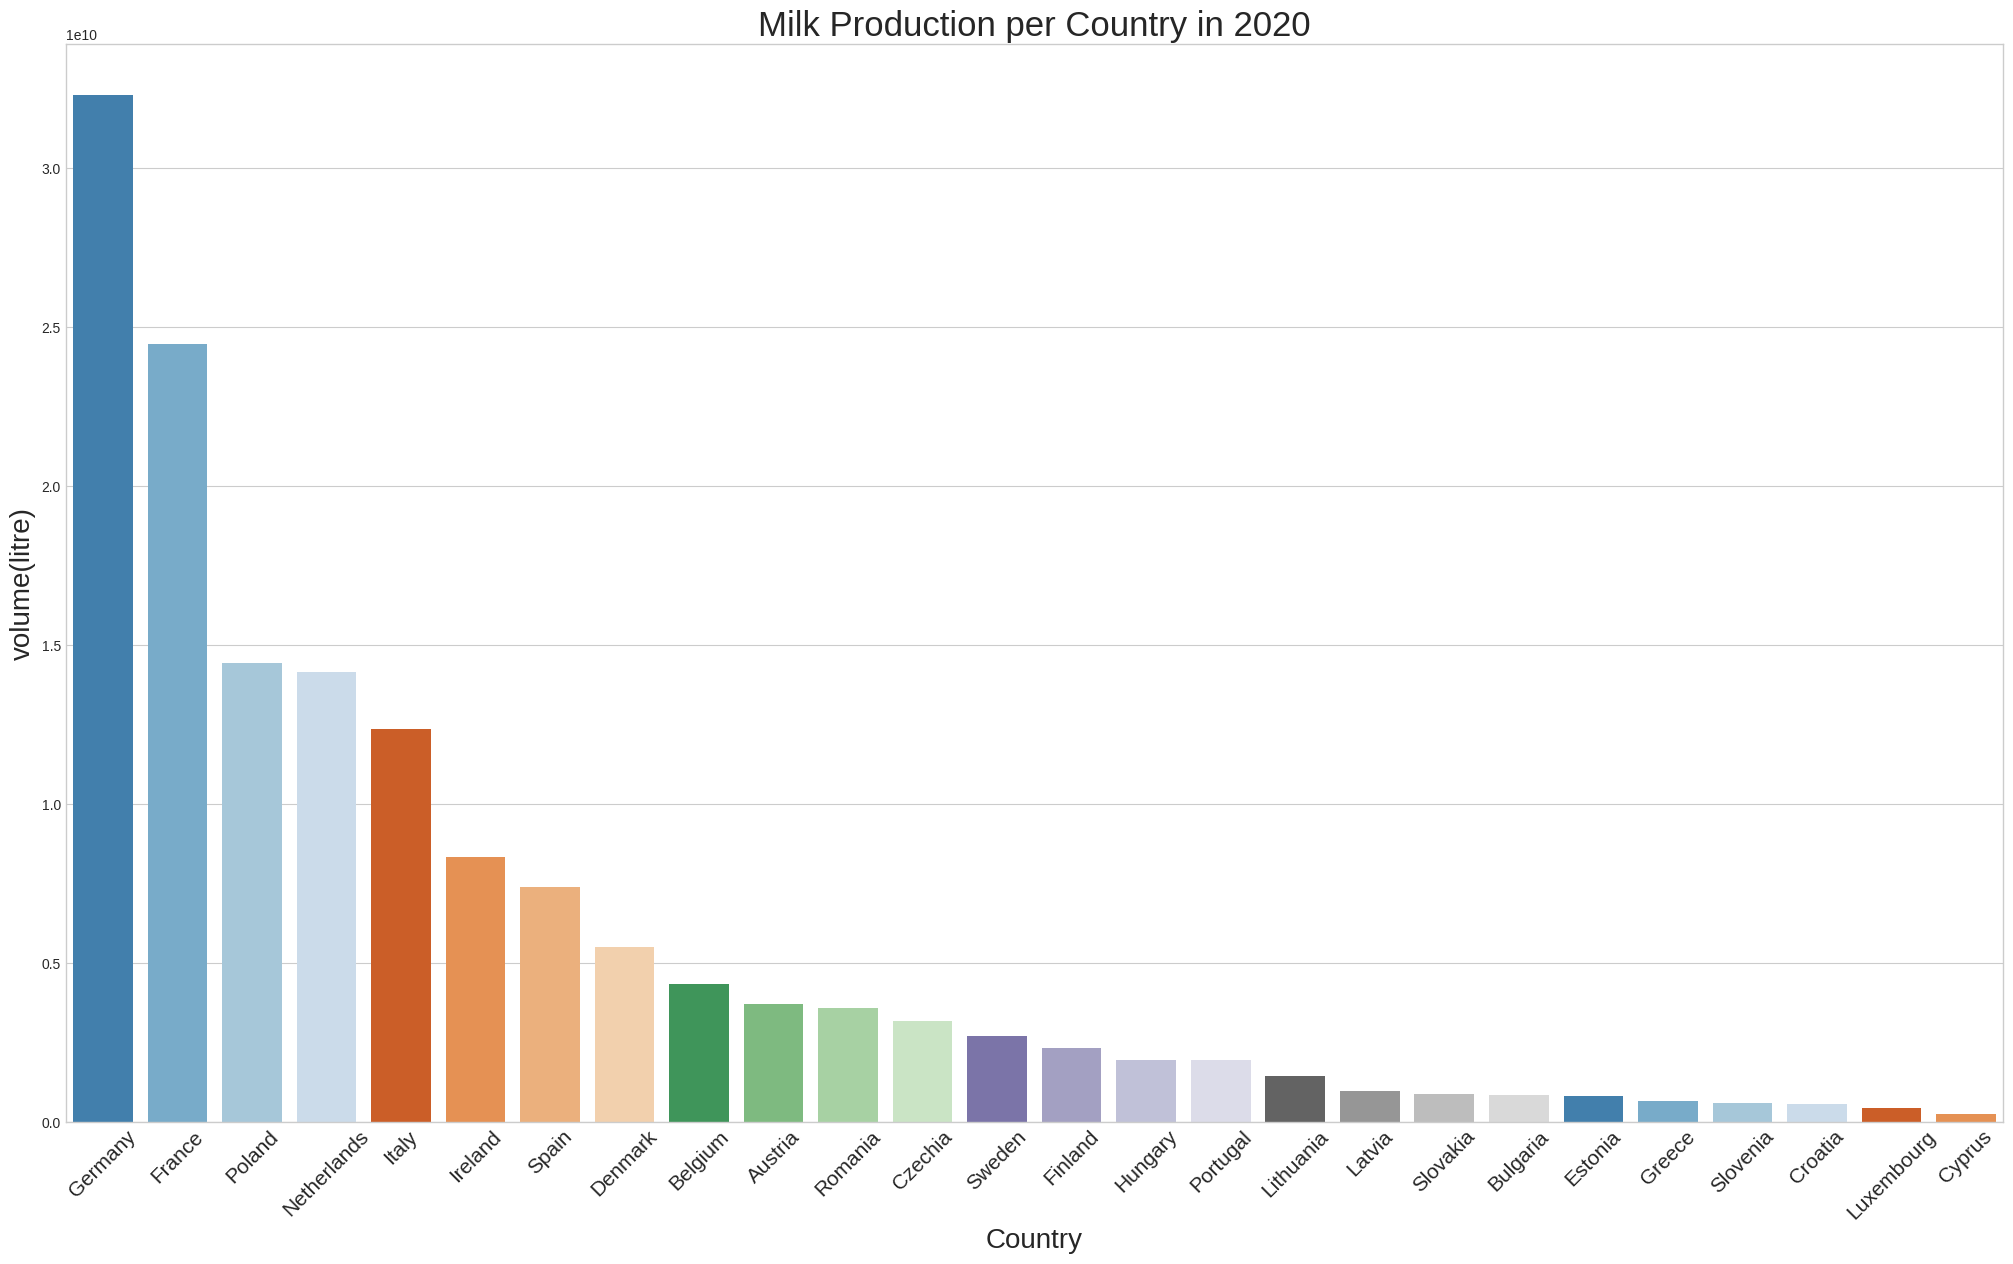

In [236]:
#plotting the milk production per country in 2020
plot_barplot('volume(litre)', 'Milk Production per Country in 2020')

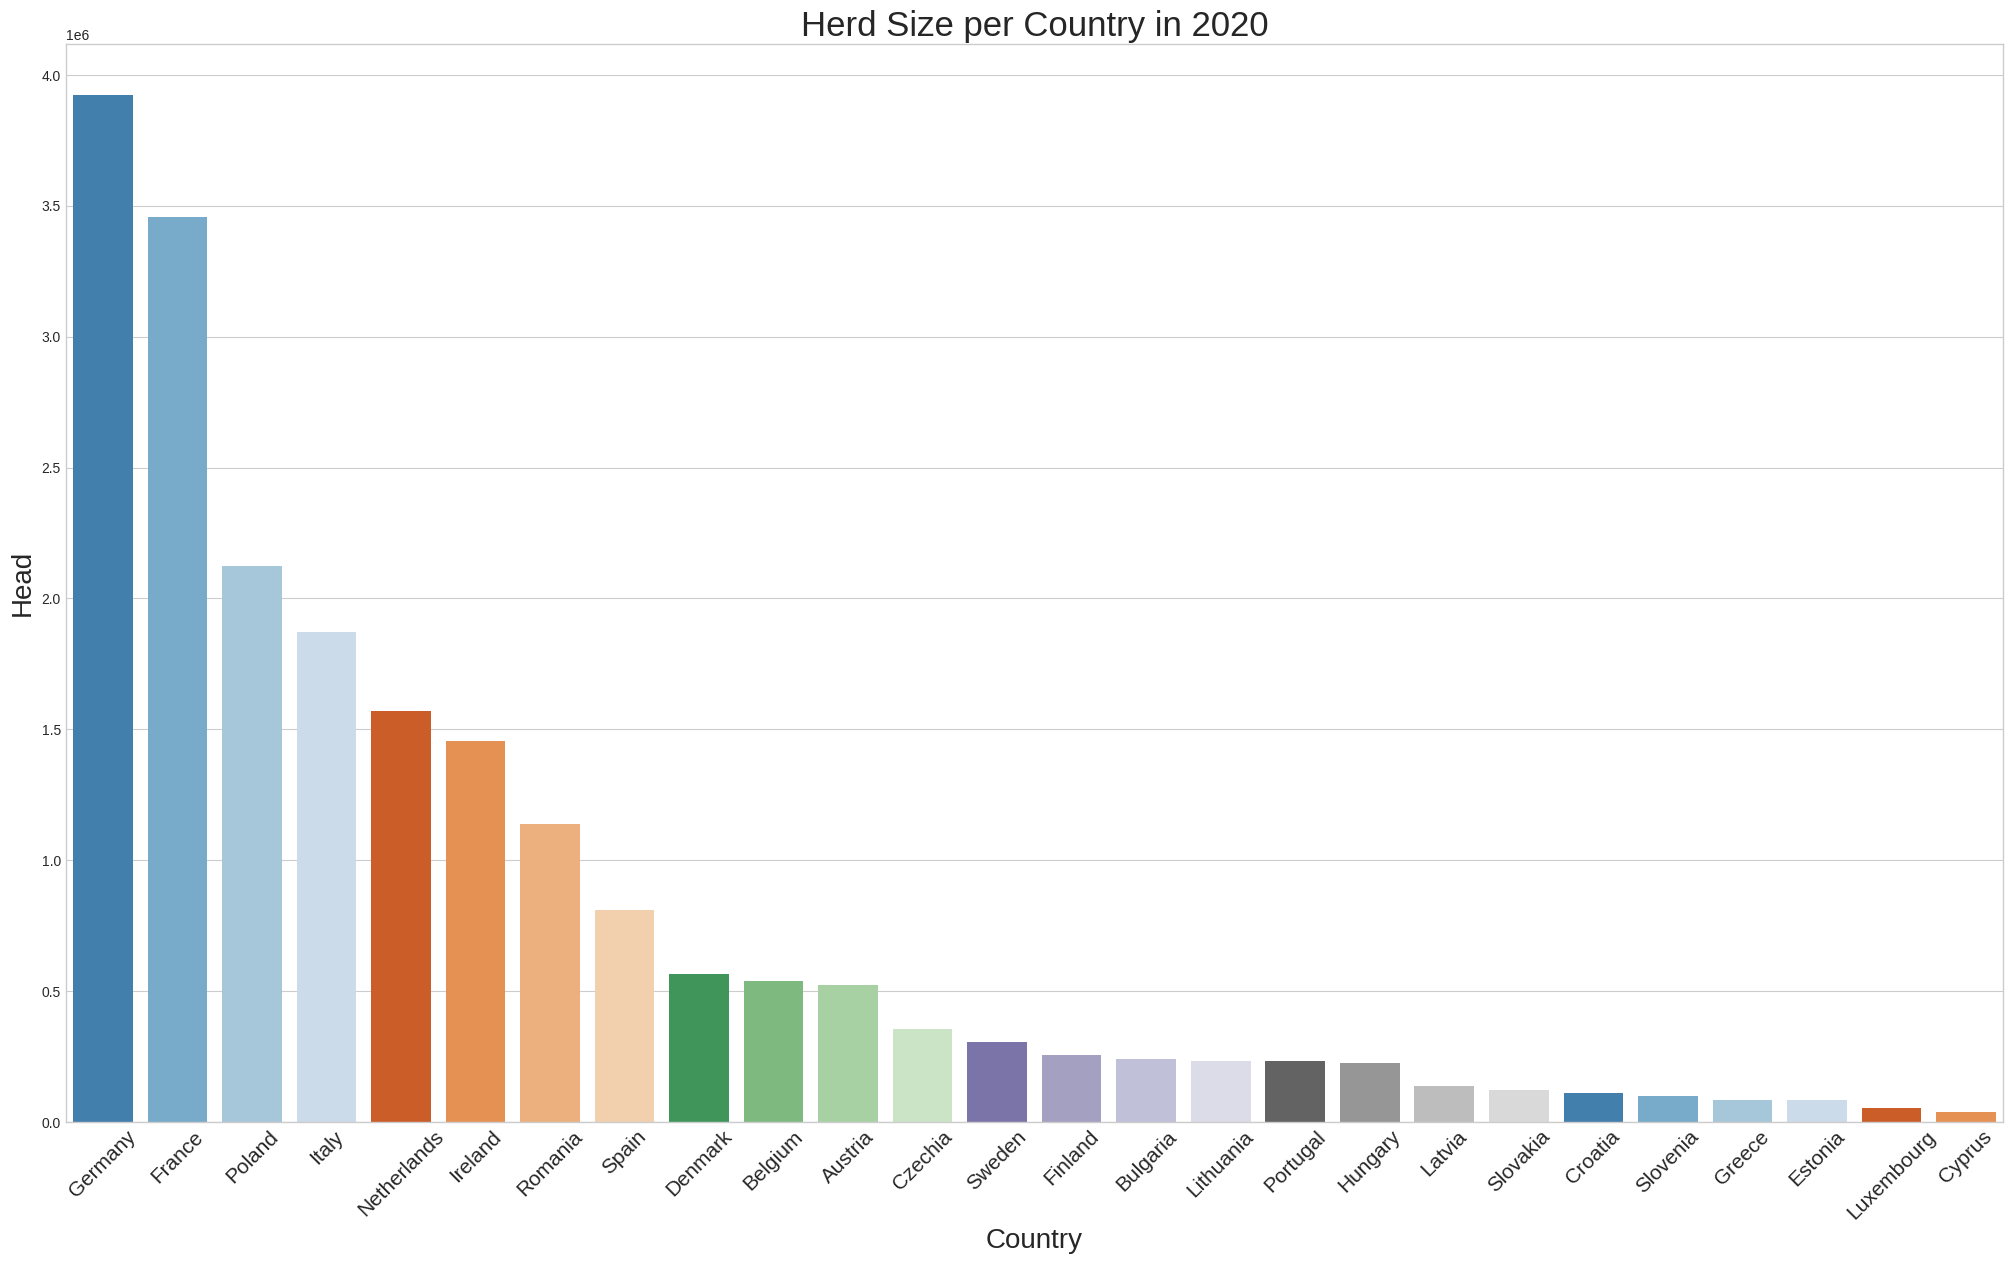

In [237]:
#and plotting the head size per country in 2020
plot_barplot('Head', 'Herd Size per Country in 2020')

Text(0, 0.5, 'Total milk production')

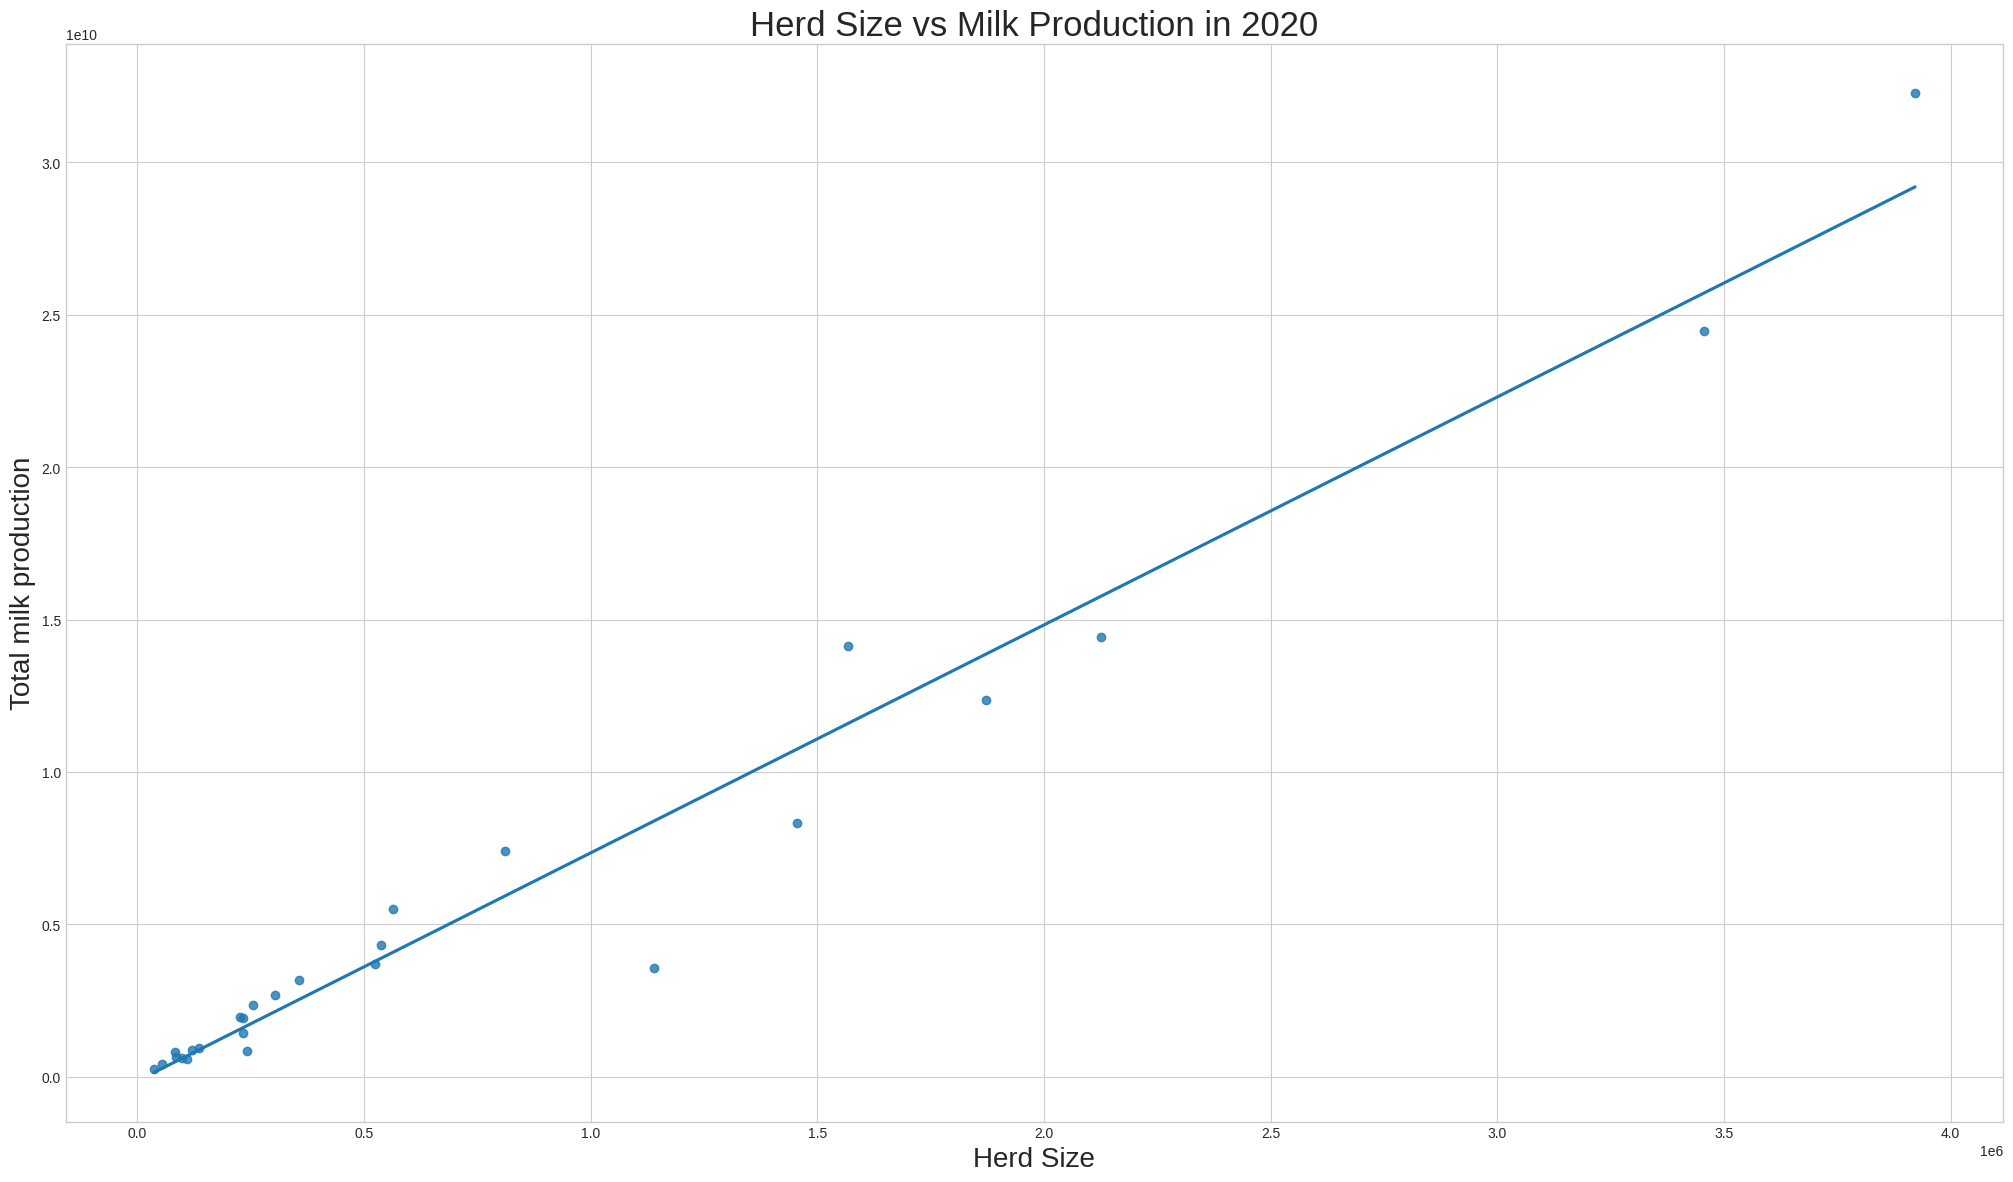

In [238]:
#we can see that the top 6 milk producing countries are the same as the top 6 herd size countries, 
#lets plot these against eachother to see if there is a correlation
sns.regplot(x='Head', y='volume(litre)', data=milk_eu_eda[(milk_eu_eda['Year'] == 2020 )], ci = None)
plt.title('Herd Size vs Milk Production in 2020', fontsize=25)
plt.xlabel('Herd Size', fontsize=20)
plt.ylabel('Total milk production', fontsize=20)


It looks like these values are pretty closely correlated. We will see the correlation coefficient soon. First im interested in seeing how the milk production and herd size changed over time. To prevent extremely messy & hard to read plots we will only consider the countries that the top 6 herd sizes and milk production in 2020

In [239]:
countries = milk_eu_eda[(milk_eu_eda['Year'] == 2020)].nlargest(6, 'Head')['Area']
years = milk_eu_eda['Year'].unique().tolist()
def trend_plot(df, measure, title, y_label):
    #defining a dictionary to store the data
    milk = {}
    #looping through the countries and years to get the data
    cmap = cm.tab20c(np.linspace(0, 1, len(countries)))
    for i, h in zip(countries, cmap):
        milk_volume = [] #creating a list to store the data
        year = []
        for j in years: 
            value = df[(df['Area'] == i) & (df['Year'] == j)][measure]  #getting the value
            if len(value) ==1:#checking if the value is present and length is 1
                milk_volume.append(value)
                year.append(j)

            else:
                pass #if not present, print error
        milk[i] = milk_volume #adding the data to the dictionary
        plt.plot(year, milk_volume, '--o', label=i, color = h)#plotting the data

    #styling the plot
    plt.legend(fontsize = 15)
    plt.title(title, fontsize=25)
    plt.xlabel('Year', fontsize=20)
    plt.ylabel(y_label, fontsize=20)

    plt.show()

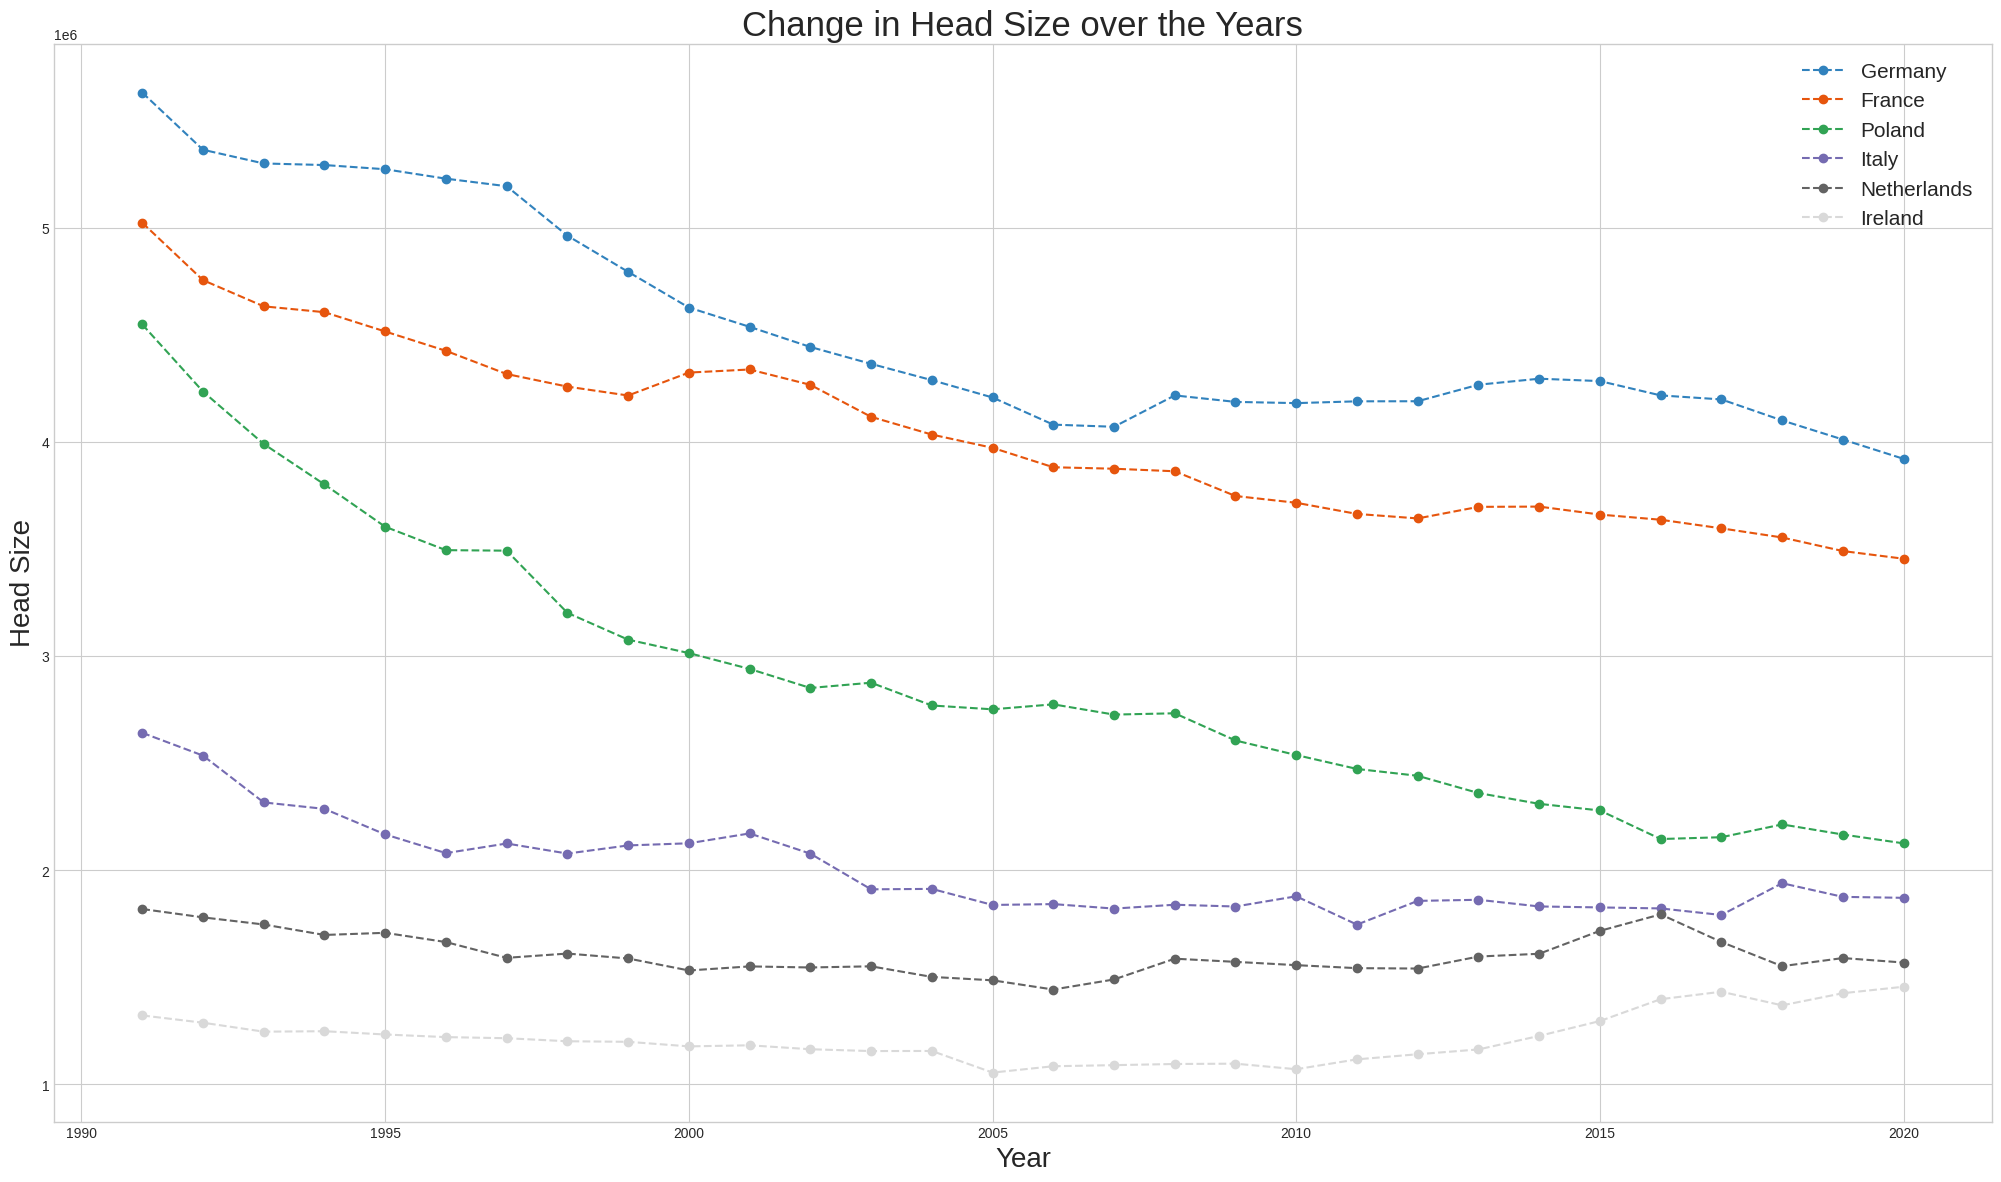

In [240]:
#plot the change in head size over the years for each country
trend_plot(milk_eu_eda, 'Head', 'Change in Head Size over the Years', 'Head Size')

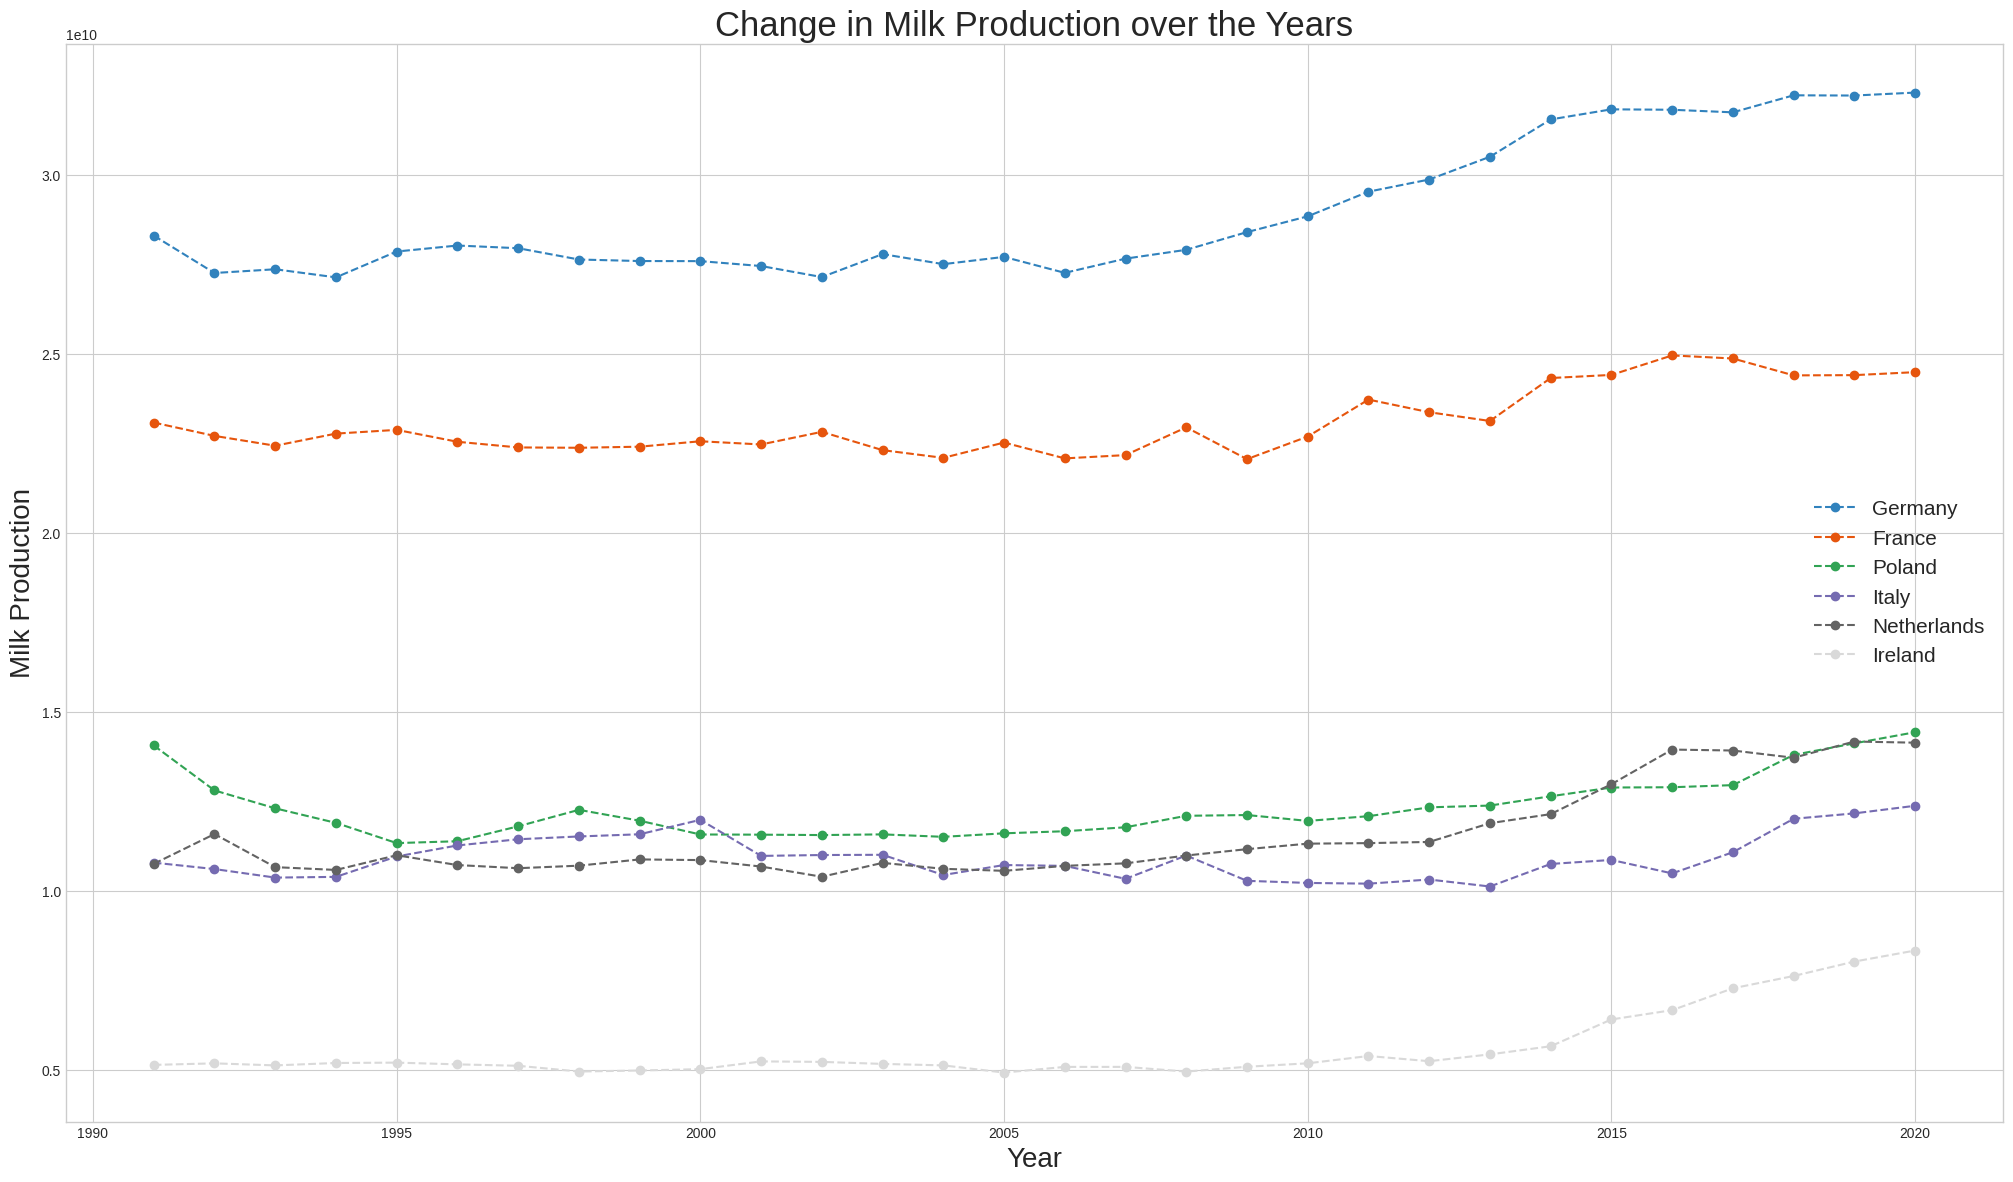

In [241]:
#and do the same for milk production
trend_plot(milk_eu_eda, 'volume(litre)', 'Change in Milk Production over the Years', 'Milk Production')

Thats interesting... while the milk production has remained constant over the years, or even increased... the herd size has decreased for many of the countries... Ireland is an exception though. Lets plot the change in milk per cow over the years

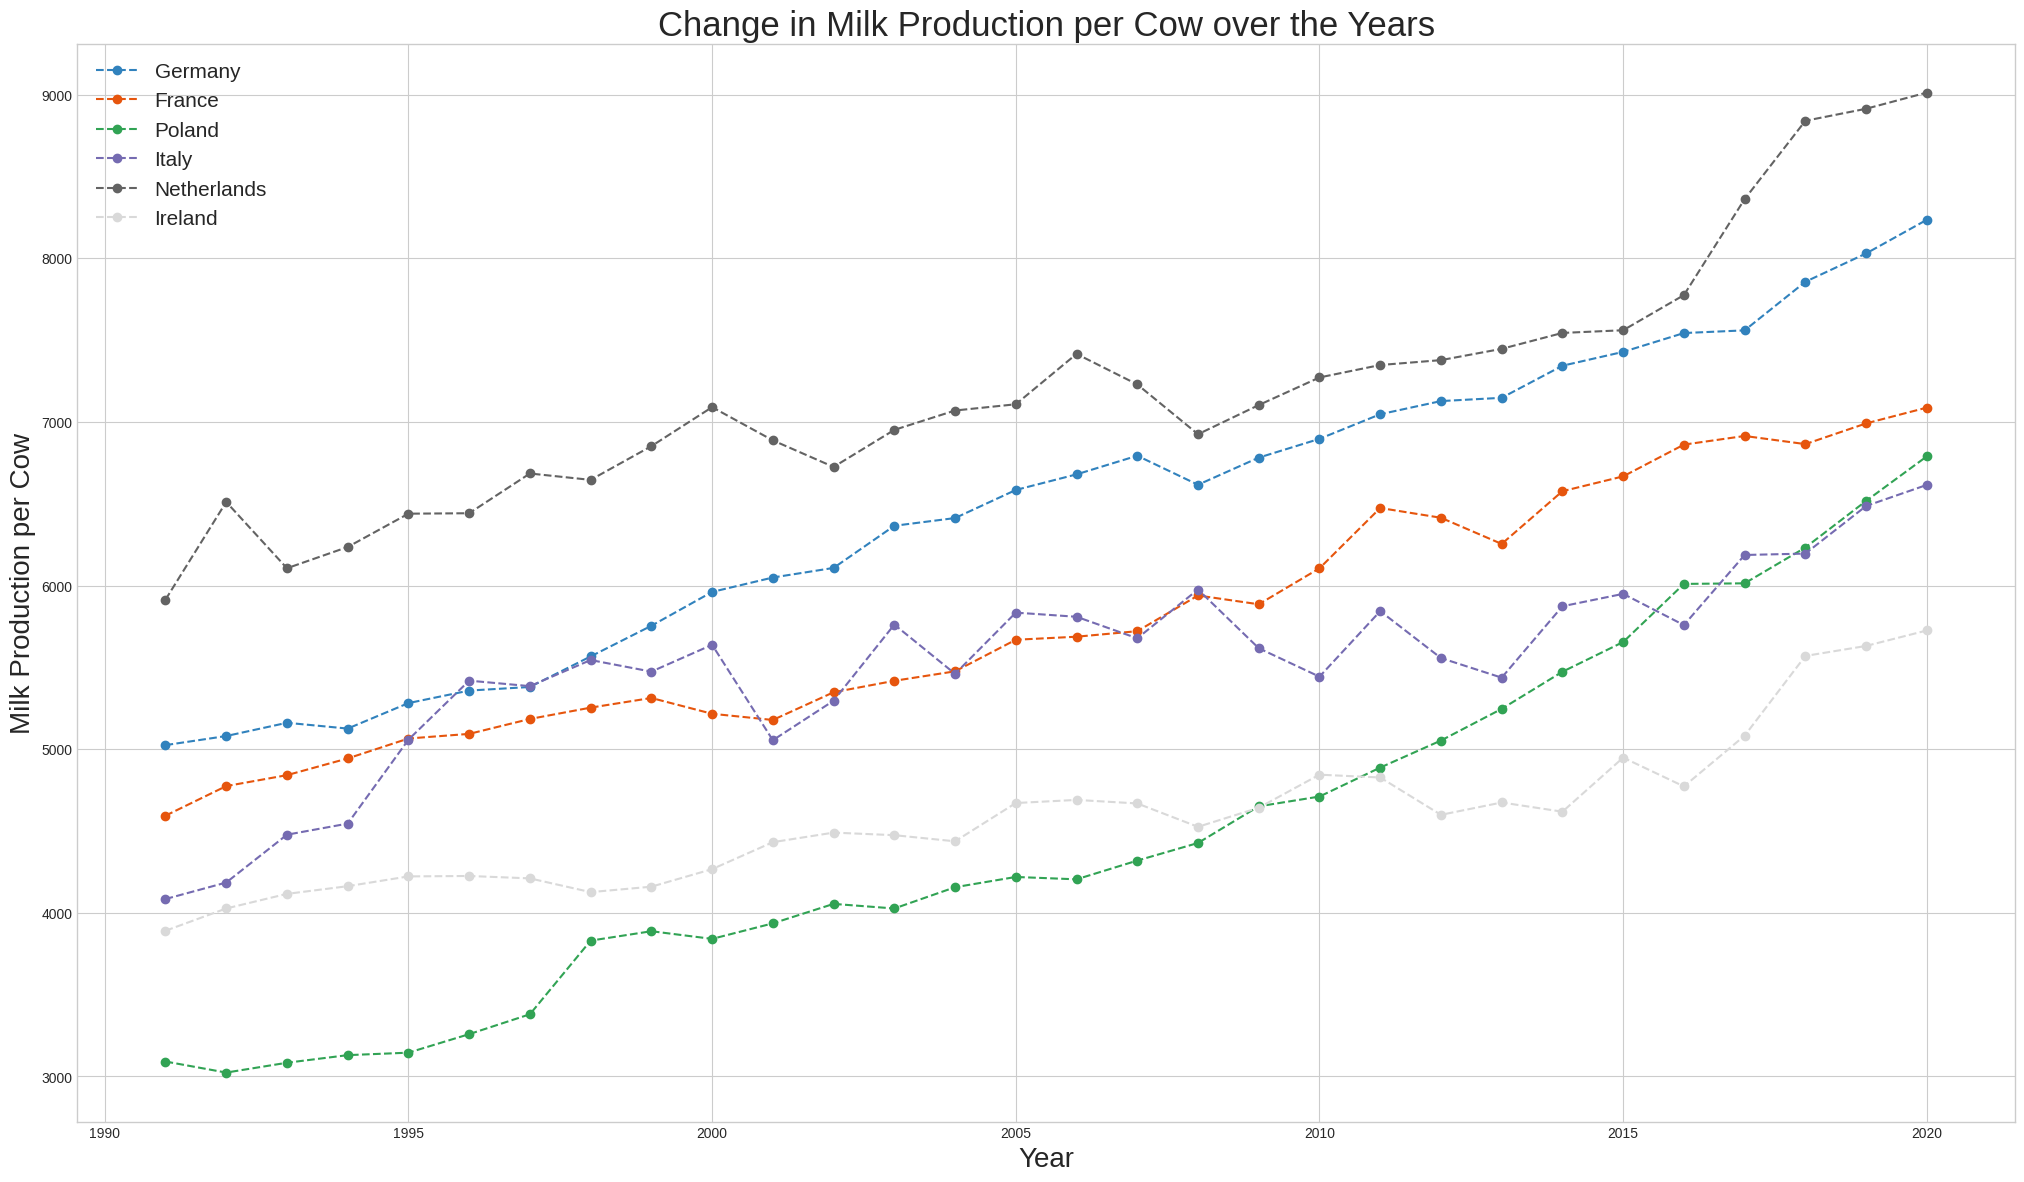

In [242]:
#plot the volume per cow over the years for each country
trend_plot(milk_eu_eda, 'volume/cow(litre)', 'Change in Milk Production per Cow over the Years', 'Milk Production per Cow')

Thats a bit mad, it appears that cows are producing more milk on average in 2020 than they were back in 1991... This really goes to show the efficacy of genetic breeding in agriculture. Out of interest lets find on average the multiple of milk production these days.

In [243]:
countries = countries.tolist()

In [244]:
countries

['Germany', 'France', 'Poland', 'Italy', 'Netherlands', 'Ireland']

In [245]:
milk_eu_eda[(milk_eu_eda['Year'] == 1991)]

Area  Year       Head       Tonne  \
0        Austria  1991   865392.0   3329700.0   
51      Bulgaria  1991   574024.0   1759490.0   
110       Cyprus  1991    16903.0    104000.0   
168      Denmark  1991   747000.0   4640000.0   
227      Finland  1991   440900.0   2566264.0   
257       France  1991  5024233.0  23702111.0   
287      Germany  1991  5632000.0  29063008.0   
317       Greece  1991   238819.0    621101.0   
347      Hungary  1991   518000.0   2490100.0   
377      Ireland  1991  1322000.0   5281800.0   
407        Italy  1991  2642000.0  11081700.0   
546  Netherlands  1991  1819000.0  11047340.0   
576       Poland  1991  4549296.0  14442457.0   
606     Portugal  1991   382000.0   1696000.0   
636      Romania  1991  1898108.0   3619480.0   
723        Spain  1991  1566000.0   6673700.0   
753       Sweden  1991   528200.0   3200000.0   

     Land under temp. meadows and pastures  \
0                                      0.0   
51                                     0.0   
110                                    0.0   
168                                    0.0   
227                                    0.0   
257                                    0.0   
287                                    0.0   
317                                    0.0   
347                                    0.0   
377                                    0.0   
407                                    0.0   
546                                    0.0   
576                                    0.0   
606                                    0.0   
636                                    0.0   
723                                    0.0   
753                                    0.0   

     Land under perm. meadows and pastures  Value  Export Value  \
0                                   1512.9  454.8     2543000.0   
51                                  1999.0  327.2       69000.0   
110                                    4.0  265.0           0.0   
168                                  212.0  415.2    12678000.0   
227                                  123.0  794.3      233000.0   
257                                11447.6  344.2   243294000.0   
287                                 5329.0  375.4   489941000.0   
317                                 5220.0  372.6      148000.0   
347                                 1173.0  186.7     1041000.0   
377                                 4068.8  296.1     4836000.0   
407                                 4204.0  478.7     3255000.0   
546                                 1080.0  397.9    40409000.0   
576                                 4038.0   97.4   191904000.0   
606                                  838.0  378.4    10405000.0   
636                                 4778.0  339.8    51432000.0   
723                                10282.0  336.7     1076000.0   
753                                  568.0  487.6       67000.0   

     Export Quantity  Temperature_C  Rainfall_mm/yr     Manure_kg  \
0            3430.00           6.30         1080.48  1.819400e+07   
51            275.00          10.05          659.11  7.259825e+06   
110             0.00          17.99          606.62  1.051068e+06   
168         23255.00           8.35          647.19  1.570493e+07   
227           186.00           2.12          603.15  9.269482e+06   
257        520521.00          10.75          717.68  1.056295e+08   
287       1187323.00           8.73          604.17  1.184072e+08   
317           305.00          12.80          660.79  5.020931e+06   
347          8997.00          10.14          635.99  6.551276e+06   
377         12874.00           9.51         1070.58  2.779373e+07   
407          6056.00          12.23          795.84  5.554541e+07   
546         88873.00           9.52          657.72  3.824266e+07   
576        278490.22           8.15          522.38  5.753608e+07   
606         20637.00          15.41          675.71  8.031168e+06   
636        102388.68           8.95          717.67  2.400

The average increase in milk production per cow is 1.67
The max increase in milk production per cow is 2.2 in Poland
The min increase in milk production per cow is 1.47 in Ireland


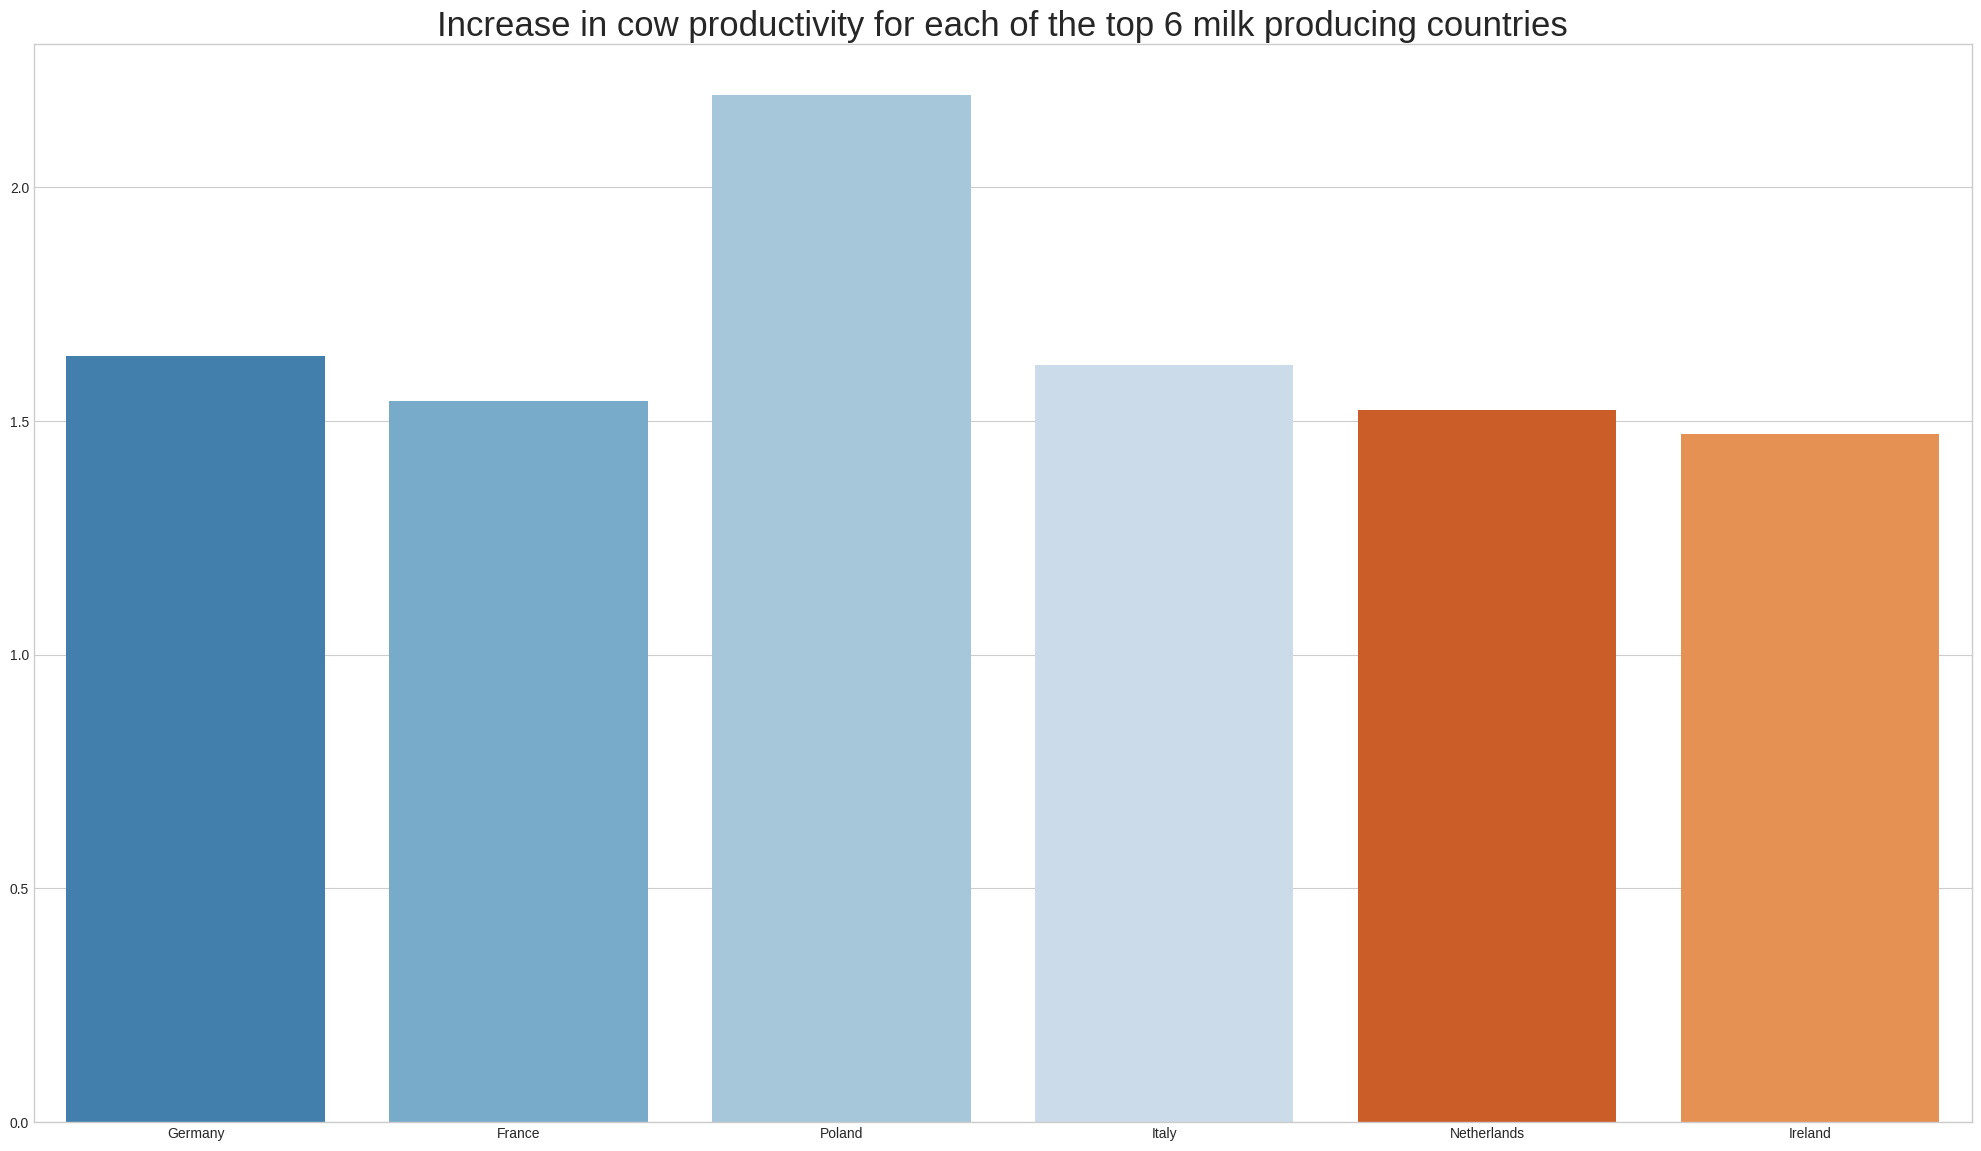

In [246]:
#this loop will calculate the ratio of milk production in 1991 to 2020 for each country
#and store it in a dictionary
milk_ratio = {}
for i in countries:
    ratio = milk_eu_eda[(milk_eu_eda['Area'] == i) & (milk_eu_eda['Year'] == 2020)]['volume/cow(litre)'].values[0]/milk_eu_eda[(milk_eu_eda['Area'] == i) & (milk_eu_eda['Year'] == 1991)]['volume/cow(litre)'].values[0]
    milk_ratio[i] = ratio
#plotting the ratio of milk production in 1991 to 2020 for each country in seaborn barplot
sns.barplot(x=list(milk_ratio.keys()), y=list(milk_ratio.values()), palette = color)
plt.title('Increase in cow productivity for each of the top 6 milk producing countries', fontsize=25)
#print the average increase in milk production ,ultiple
print('The average increase in milk production per cow is', round(np.mean(list(milk_ratio.values())), 2))
#print the max increase in milk production and country
print('The max increase in milk production per cow is', round(max(milk_ratio.values()), 2), 'in', max(milk_ratio, key=milk_ratio.get))
#print the min increase in milk production and country
print('The min increase in milk production per cow is', round(min(milk_ratio.values()), 2), 'in', min(milk_ratio, key=milk_ratio.get))


Over the last 30 years a cows milk production has increased 1.67x on average, with a peak of 2.2x in poland & a minimum of 1.47x in ireland... It seems as though we need to rsmp up the genetic breeding, but for now lets just pretend out milk is better quality ha ha ?

Lets lok at the correlation between features using a seaborn heatmap

Text(0.5, 1.0, 'Correlation between attributes in our dataframe')

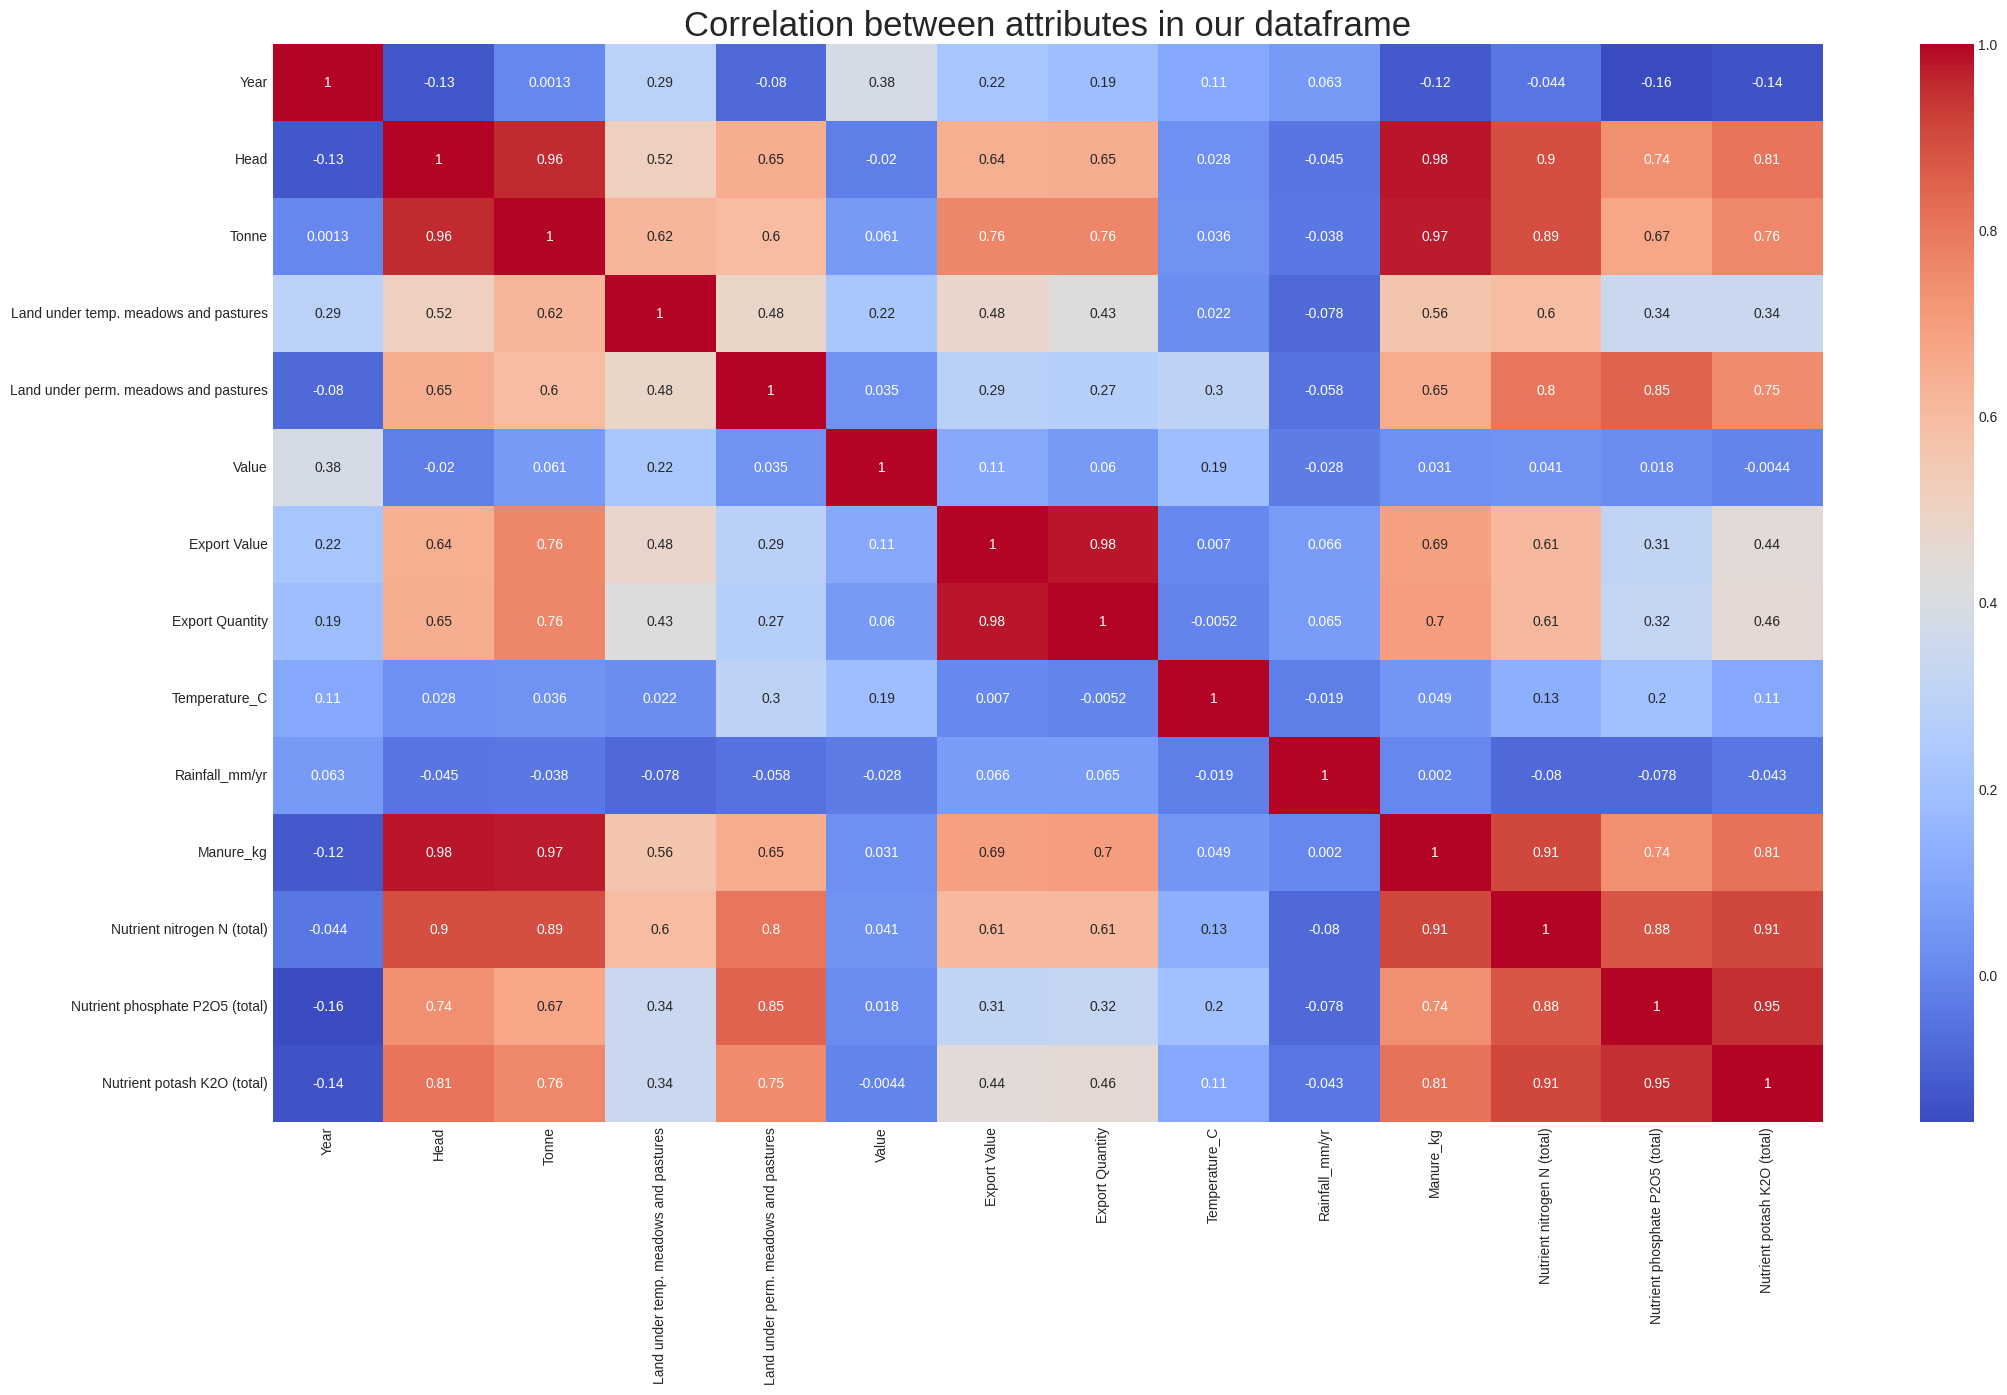

In [247]:
#correlation between columns and plotting as heatmap
sns.heatmap(milk_eu.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between attributes in our dataframe', fontsize=25)

In [248]:

#to allow for analysis we need to encode the Area column we will one hot encode it so the model doesnt mistake it for some sort of order and derive some correlation
milk_eu.head()

Area  Year      Head      Tonne  Land under temp. meadows and pastures  \
0  Austria  1991  865392.0  3329700.0                                    0.0   
1  Austria  1992  841099.0  3286583.0                                    0.0   
2  Austria  1993  817935.0  3269622.0                                    0.0   
3  Austria  1994  804264.0  3278429.0                                    0.0   
4  Austria  1995  638339.0  2948170.0                                    0.0   

   Land under perm. meadows and pastures  Value  Export Value  \
0                                 1512.9  454.8        2543.0   
1                                 1507.0  499.6        3884.0   
2                                 1501.0  468.6        2992.0   
3                                 1495.1  478.9        2645.0   
4                                 1489.1  372.9       29680.0   

   Export Quantity  Temperature_C  Rainfall_mm/yr     Manure_kg  \
0           3430.0           6.30         1080.48  1.819400e+07   
1           4879.0           7.45         1066.12  1.768327e+07   
2           3960.0           6.86         1049.61  1.719627e+07   
3           3356.0           8.11         1029.76  1.690885e+07   
4          63851.0           6.83         1144.60  1.342044e+07   

   Nutrient nitrogen N (total)  Nutrient phosphate P2O5 (total)  \
0                     132000.0                          70400.0   
1                     124000.0                          65000.0   
2                     120000.0                          64000.0   
3                     121000.0                          56000.0   
4                     125000.0                          52000.0   

   Nutrient potash K2O (total)  
0                      86300.0  
1                      78000.0  
2                      78000.0  
3                      73000.0  
4                      60000.0

### Export this dataset for use in our dashboard

In [249]:
milk_eu_eda.to_csv('milk_eu_eda.csv')

# 3) Machine learning applications

### a) Before we can go ahead with the machine learning we need to make a decision regarding our target variable. This will dictate the attributes that we keep for the features dataframe and the attribute that we set as the target

In [122]:
#encode the Area column
milk_eu.columns

Index(['Area', 'Year', 'Head', 'Tonne',
       'Land under temp. meadows and pastures',
       'Land under perm. meadows and pastures', 'Value', 'Export Value',
       'Export Quantity', 'Temperature_C', 'Rainfall_mm/yr', 'Manure_kg',
       'Nutrient nitrogen N (total)', 'Nutrient phosphate P2O5 (total)',
       'Nutrient potash K2O (total)'],
      dtype='object')

The target will be the price paid to the producers. This means that we will need to get rid of any attributes calculated from this column,
we will be keeping,

* year
* Head
* volume(litre)
* Land under temp pasture
* Land under perm pasture
* Temp_c
* Rain_mm/yr
* manure
* nitrogen
* potash
* phosphate
* % pasture
* price per litre ---> target
* exported volume
* exported value per litre usd
* keep all areas


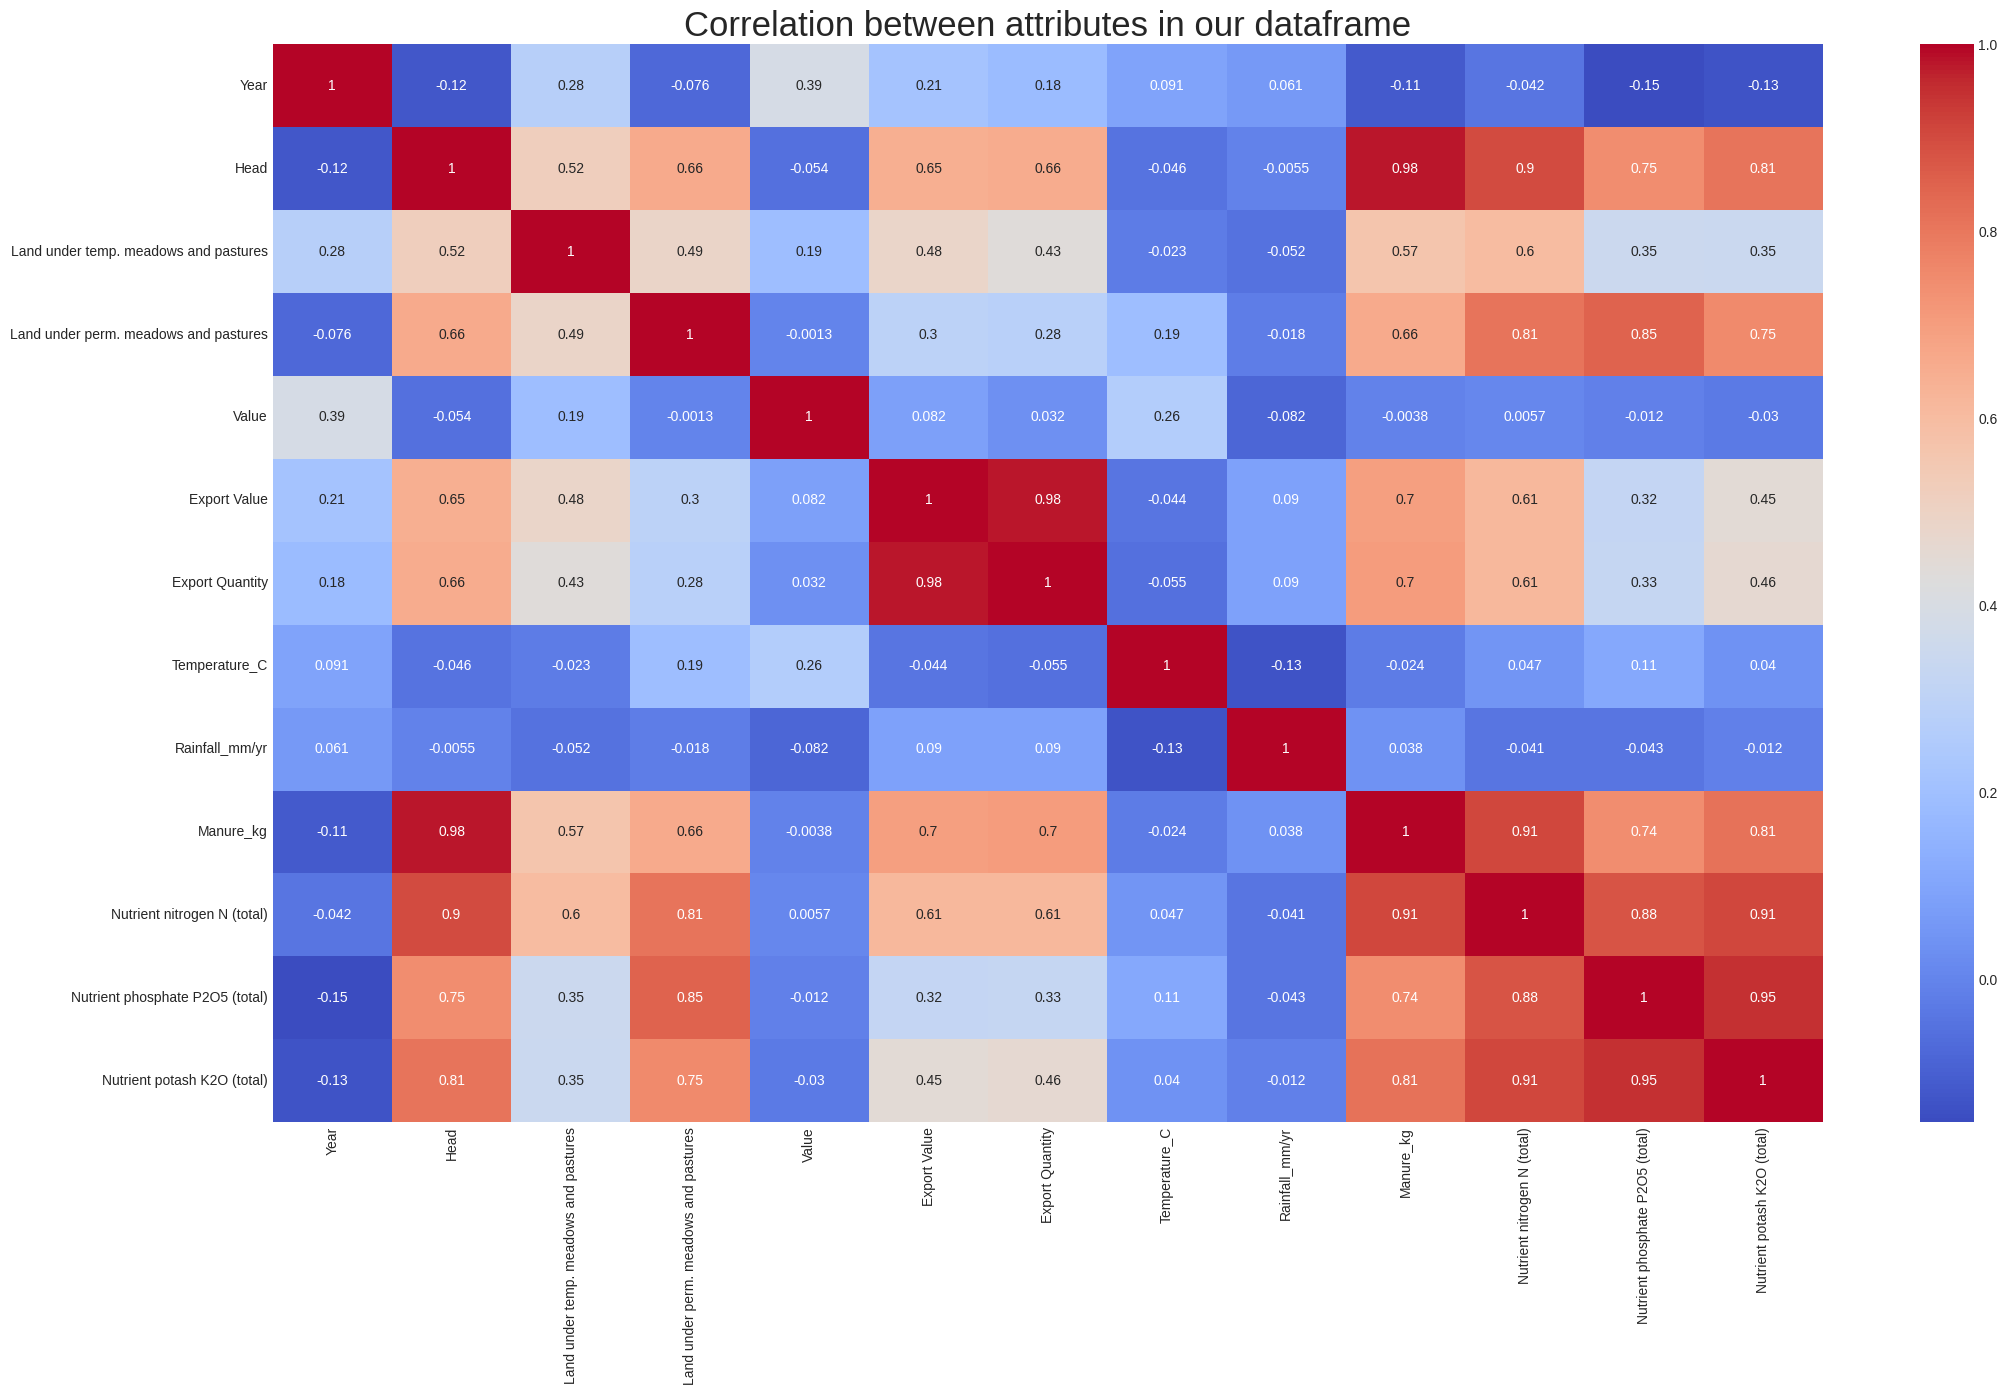

In [123]:
#feature selection
Y = milk_eu['Tonne']

#drop the columns we dont need
X = milk_eu.drop(['Tonne'], axis=1)
#correlation between columns and plotting as heatmap
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between attributes in our dataframe', fontsize=25)

#one hot encode the Area column
X = pd.get_dummies(X, columns=['Area'])





### b) There is quite a bit of correlation among our attributes in our feature array. This could lead to issues when we train our models, so to get around this we will use principal component analys to reduce the dimension of our data & remove any highly correlated columns. To do this we will first scale our data & then determine the optimal number of components using a 95% explained variance threshold. 

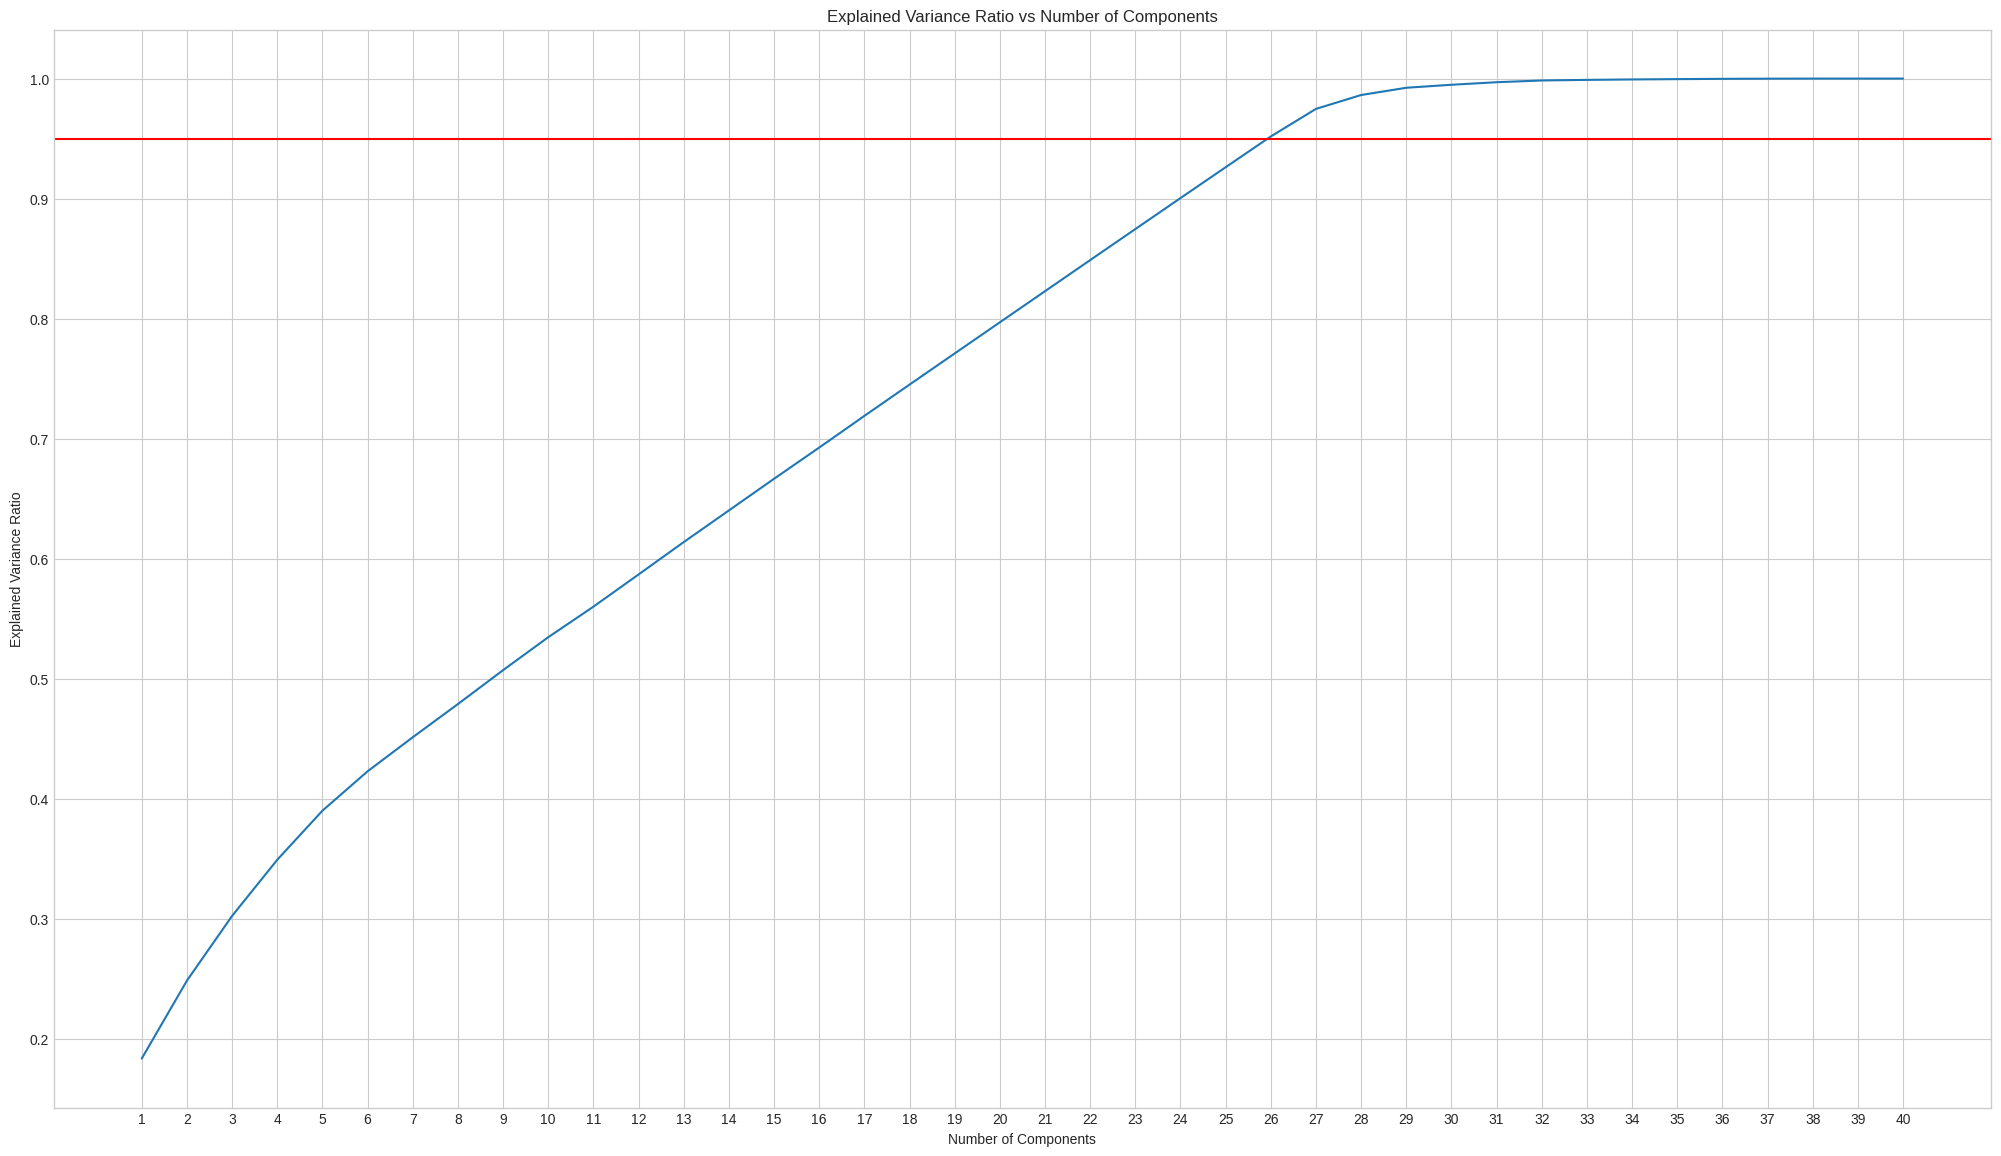

The number of components needed to explain 95% of the variance is 26


In [124]:
#splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=42)


#scaling the data#
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#pca
from sklearn.decomposition import PCA
explained_variance_ratios = []
# Loop through a range of number of components
for i in range(1, X.shape[1]+1):
    # Initialize PCA
    pca = PCA(n_components=i)

    # Fit the model to the training data and transform the data
    X_train_pca = pca.fit_transform(X_train)

    # Transform the test data
    X_test_pca = pca.transform(X_test)

    # Calculate the explained variance ratio and sum
    explained_variance_ratio = pca.explained_variance_ratio_.sum()

    # Append the explained variance ratio to the list
    explained_variance_ratios.append(explained_variance_ratio)

#plot this
plt.plot(range(1, X.shape[1]+1), explained_variance_ratios)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Components')
#set x ticks to be the number of components
plt.xticks(range(1, X.shape[1]+1))
#hline at 0.95
plt.axhline(y=0.95, color='r', linestyle='-')
plt.show()

#find the coordinates where these lines intersect
x = np.arange(1, X.shape[1]+1)
y = np.array(explained_variance_ratios)
#find the index of the first value that is greater than 0.95
index = np.argmax(y >= 0.95)
#find the x value at that index
print('The number of components needed to explain 95% of the variance is', x[index])

pca = PCA(n_components=x[index])
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)






### c) Now that we have our train and test data sorted we will move onto fitting models. We will fit 8 linear models and rank them based off the median absolute error

LinearRegression()


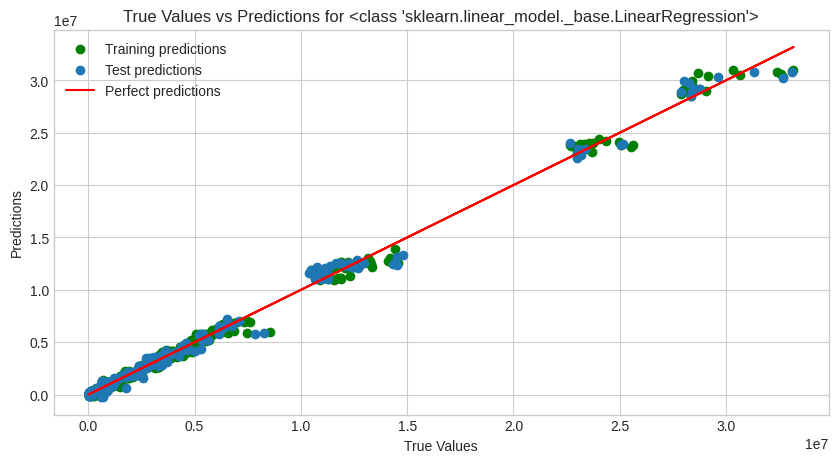

Ridge(alpha=0.07163636363636364, max_iter=10000, random_state=42, solver='lsqr')


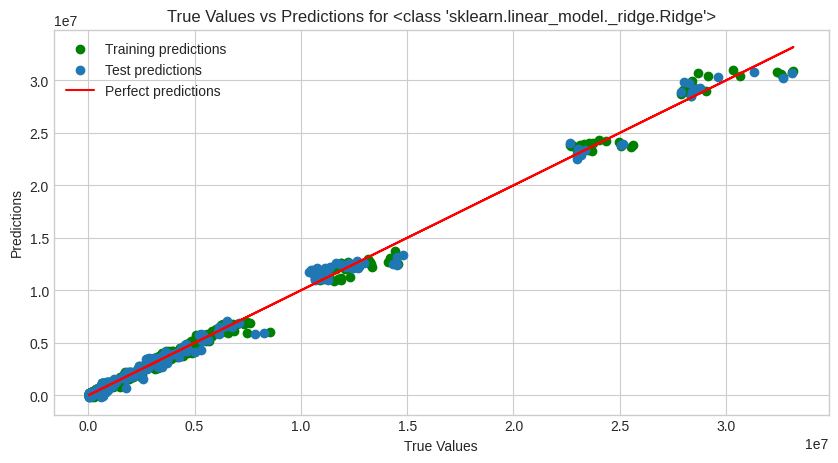

Lasso(alpha=553.5353535353536, max_iter=10000, random_state=42)


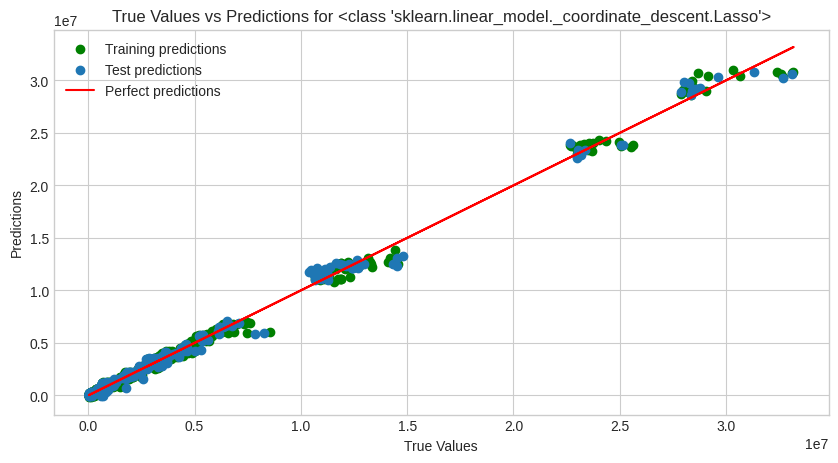

KNeighborsRegressor(n_neighbors=3, weights='distance')


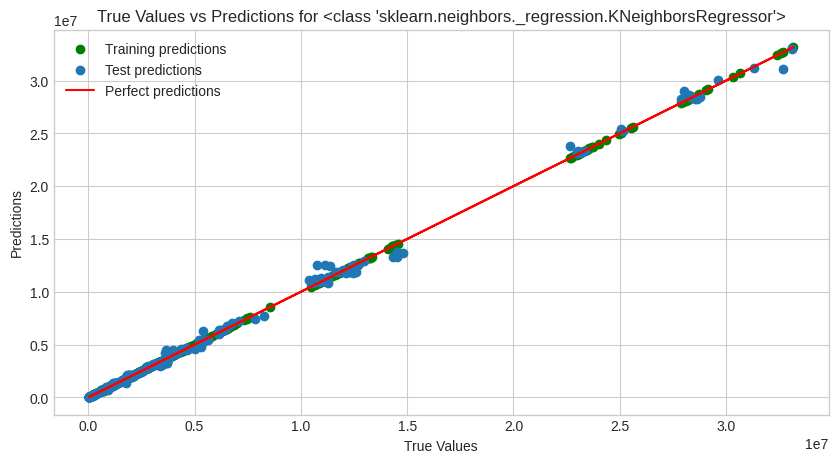

RandomForestRegressor(criterion='absolute_error', max_depth=16,
                      max_features='sqrt', n_estimators=280, random_state=42)


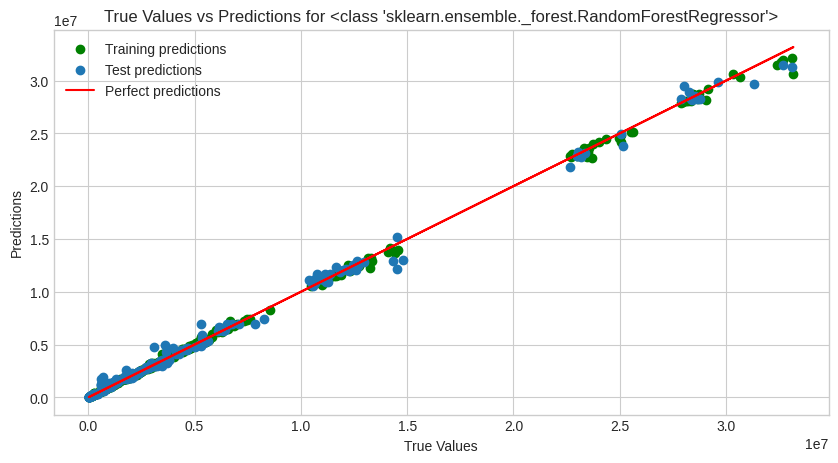

DecisionTreeRegressor(ccp_alpha=0.48484848484848486, max_depth=15,
                      random_state=42)


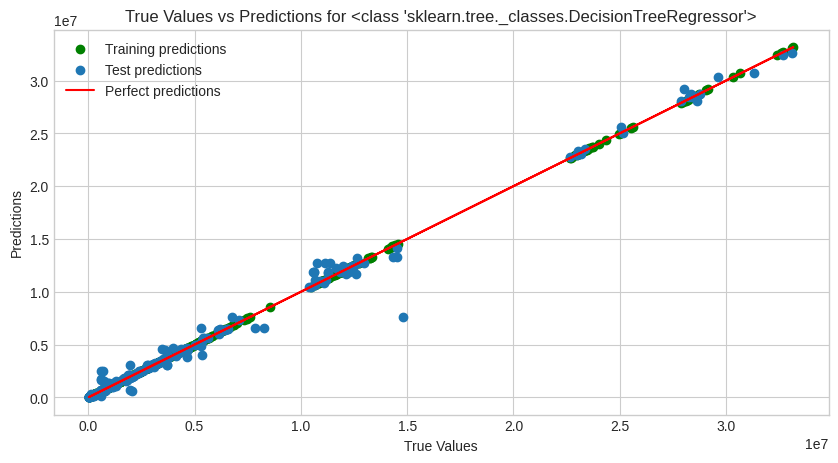

GradientBoostingRegressor(max_depth=6, max_features='auto', n_estimators=90,
                          random_state=42)


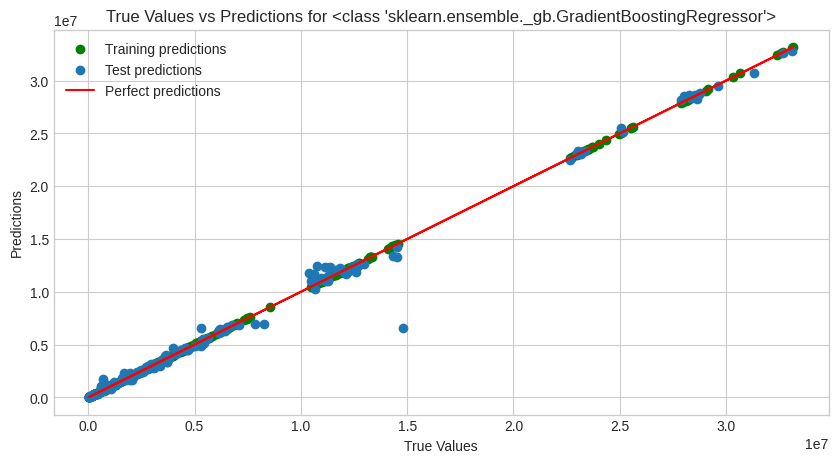

LinearSVR(C=3.4343434343434343, epsilon=2.4174174174174174,
          loss='squared_epsilon_insensitive', max_iter=10000, random_state=42)


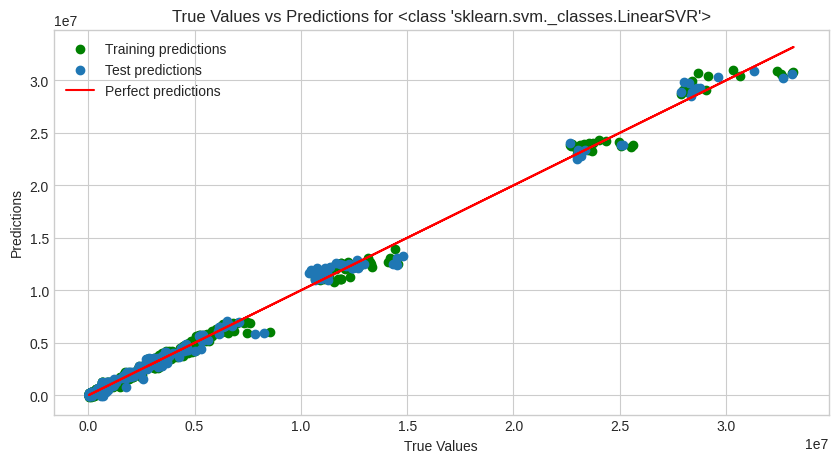

In [125]:
best_params = {}
results = {}
mape_score = {}
#dictionary of models
models = { 'Linear Regression': LinearRegression, 'Ridge Regression': Ridge, 'Lasso Regression': Lasso,
            'KNN Regression': KNeighborsRegressor, 'Random Forest Regression': RandomForestRegressor, 
            'Decision Tree Regression': DecisionTreeRegressor, 'Gradient Boosting Regression': GradientBoostingRegressor,
            'Linear SVR': LinearSVR}
np.random.seed(42)
for model in models.values():
    if model == LinearRegression:
        param = {}
    elif model == Ridge:
        param = {'alpha': np.linspace(0.001, 1, 100), 'random_state': [42], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 'max_iter': [10000] }
    elif model == RandomForestRegressor:
        param = {'n_estimators': np.arange(100, 800, 10), 'random_state': [42] , 'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'], 'max_features':['sqrt', 'log2', None], 'max_depth': np.arange(0, 25, 1) }
    elif model == DecisionTreeRegressor:
        param = {'max_depth': np.arange(0, 50, 1),'ccp_alpha': np.linspace(0, 2, 100), 'criterion': ['squared_error', 'friedman_mse' 'absolute_error', 'poisson'], 'random_state': [42]}
    elif model == LinearSVR:
        param = {'C': np.linspace(0, 5, 100), 'random_state': [42], 'epsilon': np.linspace(0, 5, 1000), 'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'], 'max_iter': [10000]}
    elif model == Lasso:
        param = {'alpha': np.linspace(400, 800, 100), 'random_state': [42], 'max_iter': [10000]}
    elif model == GradientBoostingRegressor:
        param = {'n_estimators': np.arange(0, 100, 10) , 'max_depth': np.arange(5, 10, 1), 'random_state': [42], 'criterion': ['friedman_mse', 'squared_error'], 'max_features': ['sqrt', 'log2', 'auto']}
    elif model == KNeighborsRegressor:
        param = {'n_neighbors': np.arange(1, 15, 1), 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
    
    
    grid = RandomizedSearchCV(estimator = model(), param_distributions = param, cv = 10, n_jobs = -1, n_iter = 500, random_state = 42)
    grid.fit(X_train, y_train)
    #predict
    grid_predictions = grid.predict(X_test)

    #best parameters
    best_params[model] = grid.best_estimator_
    print(grid.best_estimator_)

    #median absolute percentage error
    ape_list = np.abs((grid_predictions-y_test)/y_test)*100
   

    mape_score[model] = np.median(ape_list)

    #r2 score
    r2 = r2_score(y_test, grid_predictions)
    results[model] = r2

    #plotting the results
    plt.figure(figsize=(10, 5))
    plt.scatter(y_train, grid.predict(X_train), color = 'green', label = 'Training predictions')
    plt.scatter(y_test, grid_predictions, label = 'Test predictions')
    plt.plot(Y, Y, color = 'red', label = 'Perfect predictions')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True Values vs Predictions for {}'.format(model))
    plt.legend()
    plt.show()






In [126]:
#plot the model scores
model_compare = pd.DataFrame.from_dict(results, orient = 'index', columns=['R2 Score'])
#add new index column
model_compare['model'] = model_compare.index
model_compare.reset_index(drop=True, inplace=True)
#add best params
model_compare['best params'] = best_params.values()
#add mape
model_compare['MAPE'] = mape_score.values()
#median average percentage accuracy
model_compare['Accuracy'] = 100 - model_compare['MAPE']
model_compare.sort_values(by='MAPE', ascending=True, inplace=True)
model_compare

R2 Score                                              model  \
3  0.998230  <class 'sklearn.neighbors._regression.KNeighbo...   
5  0.992669  <class 'sklearn.tree._classes.DecisionTreeRegr...   
6  0.993410  <class 'sklearn.ensemble._gb.GradientBoostingR...   
4  0.996518  <class 'sklearn.ensemble._forest.RandomForestR...   
2  0.994299  <class 'sklearn.linear_model._coordinate_desce...   
0  0.994306  <class 'sklearn.linear_model._base.LinearRegre...   
7  0.994324           <class 'sklearn.svm._classes.LinearSVR'>   
1  0.994329        <class 'sklearn.linear_model._ridge.Ridge'>   

                                         best params      MAPE   Accuracy  
3  KNeighborsRegressor(n_neighbors=3, weights='di...  2.842555  97.157445  
5  DecisionTreeRegressor(ccp_alpha=0.484848484848...  3.259257  96.740743  
6  ([DecisionTreeRegressor(criterion='friedman_ms...  4.001161  95.998839  
4  (DecisionTreeRegressor(criterion='absolute_err...  4.436691  95.563309  
2  Lasso(alpha=553.5353535353536, max_iter=10000,...  8.296709  91.703291  
0                                 LinearRegression()  8.301329  91.698671  
7  LinearSVR(C=3.4343434343434343, epsilon=2.4174...  8.343924  91.656076  
1  Ridge(alpha=0.07163636363636364, max_iter=1000...  8.613485  91.386515

In [127]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
regressor = MLPRegressor(max_iter=1000)

# Define the parameter grid
param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
              'activation': ['tanh', 'relu'],
              'solver': ['sgd', 'adam'],
              'alpha': [0.0001, 0.05],
              'learning_rate': ['constant','adaptive']}

# Create the grid search object
grid_search = GridSearchCV(regressor, param_grid, cv=5, return_train_score=True)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Use the best parameters to create a new neural network regressor
best_regressor = MLPRegressor(max_iter=1000, **best_params)

# Fit the best regressor to the training data
best_regressor.fit(X_train, y_train)

# Make predictions on the test data
predictions = best_regressor.predict(X_test)

# Evaluate the performance of the model
ape_list = np.abs((grid_predictions-y_test)/y_test)*100
   

mse = np.median(ape_list)
print(f'Median absolute percentage error: {mse:.2f}')

Median absolute percentage error: 8.34


### d) Now that we have carried out predictive analysis regarding the milk production, we will move on to some sentiment analysis. For this we will focus on sentiment regarding consumer prices of dairy products, as the prices have seen a big spike recently.

The pre-processing steps used here are those which were covered during the data preparation and visualisation module

In [447]:
from dotenv import dotenv_values


config = dotenv_values(".env")

In [502]:
import tweepy
import pandas as pd
tweet_list = []
#Put your Bearer Token in the parenthesis below
client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAAeMkwEAAAAAAPRpBCZWbaDuyYVmiJJWxaPOho0%3DBF2X9njPEYVWFgGMpXd9S9xRCNuq04L3kWRwWcYx27WLaSmSpq')


# -is:retweet removes retweets & lang:en limits to English tweets this is applied after every keyword due to issues otherwise
query = 'price of milk -is:retweet lang:en OR cost of milk -is:retweet lang:en OR cost of dairy -is:retweet lang:en OR price of dairy -is:retweet lang:en'
tweets = tweepy.Paginator(client.search_recent_tweets, query=query,
                              tweet_fields=['context_annotations', 'created_at'], max_results=100).flatten(limit=1500)

for tweet in tweets:
    tweet_list.append(tweet.text)


# Create a dataframe from the tweets
tweets = pd.DataFrame(tweet_list, columns=['full_text'])
tweets


full_text
0    @Graham_Drew @charlesbarnwell @IsabelOakeshott...
1    @Graham_Drew @charlesbarnwell @IsabelOakeshott...
2    📢📢  Frother for Coffee, Milk Frother, 4 IN 1 A...
3    Between the covid,vaccine,boosters,hospital an...
4    @TeamPelosi Well pat yourself on your pompass ...
..                                                 ...
758  According to this piece, Chinese took the big ...
759  @MDBitcoin @moreworktodo1 @VailshireCap Oh man...
760  Externalizing corruption, on the other hand, w...
761  @spaceandweather I bought 8 items earlier this...
762  Any place where raw milk is legal and you can ...

[763 rows x 1 columns]

#importing the dataset
tweets = pd.read_csv('/home/faelan/Downloads/dataset_twitter-scraper_2022-12-30_18-59-56-893.csv')


In [503]:
import nltk
#nltk.download()

In [515]:
text = tweets.filter(['full_text'])

In [516]:
text.head()

full_text
0  @Graham_Drew @charlesbarnwell @IsabelOakeshott...
1  @Graham_Drew @charlesbarnwell @IsabelOakeshott...
2  📢📢  Frother for Coffee, Milk Frother, 4 IN 1 A...
3  Between the covid,vaccine,boosters,hospital an...
4  @TeamPelosi Well pat yourself on your pompass ...

In [517]:
#we need to remove the stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
#remove usernames
text['full_text'] = text['full_text'].str.replace('@[^\s]+',' ')#remove usernames
text['full_text'] = text['full_text'].str.replace('[^\w\s]',' ')#remove punctuation
text['full_text'] = text['full_text'].str.replace("[^a-zA-Z#]", ' ')#remove special characters
text['full_text'] = text['full_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))#stopwords
text['full_text'] = text['full_text'].apply(lambda x: " ".join(x.lower() for x in x.split())) #lowercase
text['full_text'].head()


0    given variety different kinds cheese reason kn...
1    the reason market knows much milk use kind mil...
2    frother coffee milk frother in automatic warm ...
3    between covid vaccine boosters hospital housin...
4    well pat pompass back the cost surviving outwe...
Name: full_text, dtype: object

In [519]:
from textblob import TextBlob
text['full_text'] = text['full_text'].apply(lambda x: str(TextBlob(x).correct())) #spell check

In [520]:
#leminiyezation
from textblob import Word
text['full_text'] = text['full_text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))#removes the suffixes
text['full_text'].head()

0    given variety different kind cheese reason kno...
1    the reason market know much milk use kind milk...
2    brother coffee milk brother in automatic warm ...
3    between could vaccine blister hospital housing...
4    well pat compass back the cost surviving outwe...
Name: full_text, dtype: object

In [521]:
#analyzing the sentiment of the tweets
text['sentiment'] = text['full_text'].apply(lambda x: TextBlob(x).sentiment[0])#polarity AKA assigning sentiment
text.head()

full_text  sentiment
0  given variety different kind cheese reason kno...    0.42500
1  the reason market know much milk use kind milk...    0.57500
2  brother coffee milk brother in automatic warm ...    0.12500
3  between could vaccine blister hospital housing...   -0.20000
4  well pat compass back the cost surviving outwe...   -0.15625

In [522]:
#assigning the sentiment to the tweets
text['sentiment'] = text['sentiment'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))

In [523]:
text.head()

full_text sentiment
0  given variety different kind cheese reason kno...  positive
1  the reason market know much milk use kind milk...  positive
2  brother coffee milk brother in automatic warm ...   neutral
3  between could vaccine blister hospital housing...   neutral
4  well pat compass back the cost surviving outwe...   neutral

In [524]:
text.drop_duplicates(inplace = True)

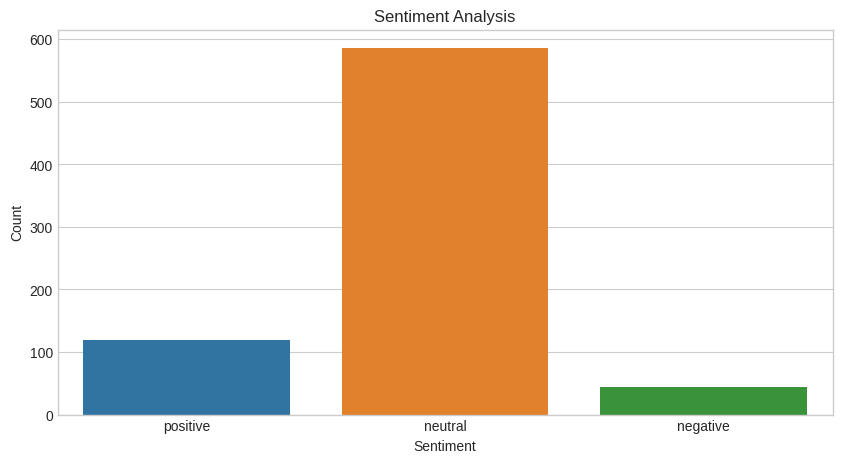

In [525]:
#plotting the sentiment
plt.figure(figsize=(10, 5))
sns.countplot(x='sentiment', data=text)
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

This dataset is unbalanced. We will employ smote for class balancing before we proceed onto applying nlp models

In [526]:
#create a word cloud
from wordcloud import WordCloud
def word_cloud(input):
    all_words = ' '.join([text for text in text[text['sentiment'] == input]['full_text']])
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f'Word cloud for tweets with {input} sentiment', fontsize=25)
    plt.axis('off')

In [527]:
#tokenization
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
text['tokenized'] = text['full_text'].apply(lambda x: tokenizer.tokenize(x.lower()))
text.head()

full_text sentiment  \
0  given variety different kind cheese reason kno...  positive   
1  the reason market know much milk use kind milk...  positive   
2  brother coffee milk brother in automatic warm ...   neutral   
3  between could vaccine blister hospital housing...   neutral   
4  well pat compass back the cost surviving outwe...   neutral   

                                           tokenized  
0  [given, variety, different, kind, cheese, reas...  
1  [the, reason, market, know, much, milk, use, k...  
2  [brother, coffee, milk, brother, in, automatic...  
3  [between, could, vaccine, blister, hospital, h...  
4  [well, pat, compass, back, the, cost, survivin...

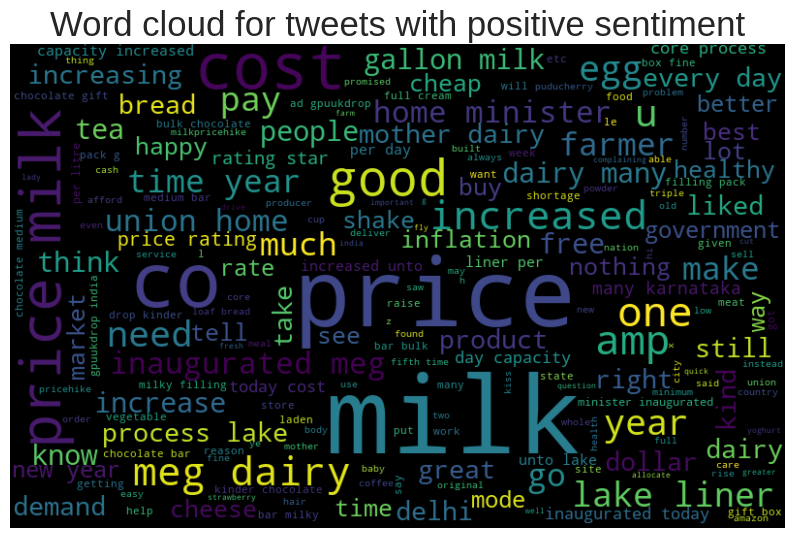

In [528]:
word_cloud('positive')

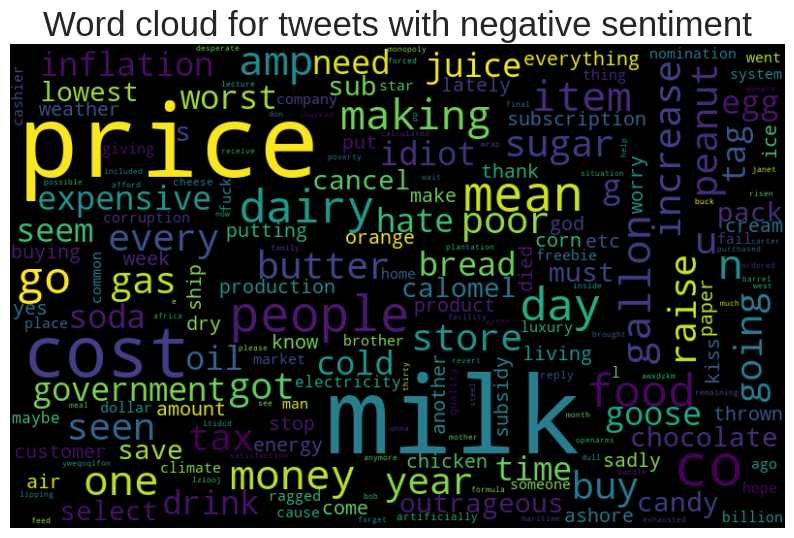

In [529]:
word_cloud('negative')

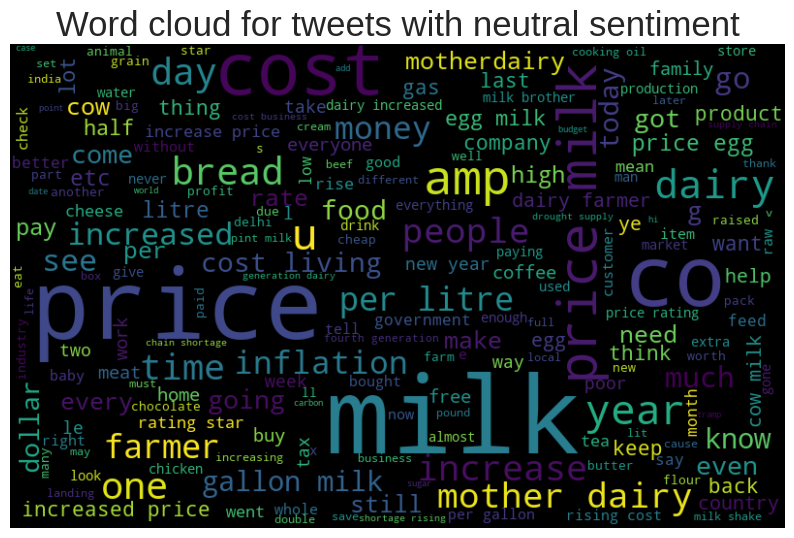

In [530]:
word_cloud('neutral')

In [531]:
Y = text['sentiment'].tolist()
for i in range(len(Y)):
    if Y[i] == 'positive':
        Y[i] = 0
    elif Y[i] == 'negative':
        Y[i] = 1
    elif Y[i] == 'neutral':
        Y[i] = 2


<AxesSubplot:ylabel='count'>

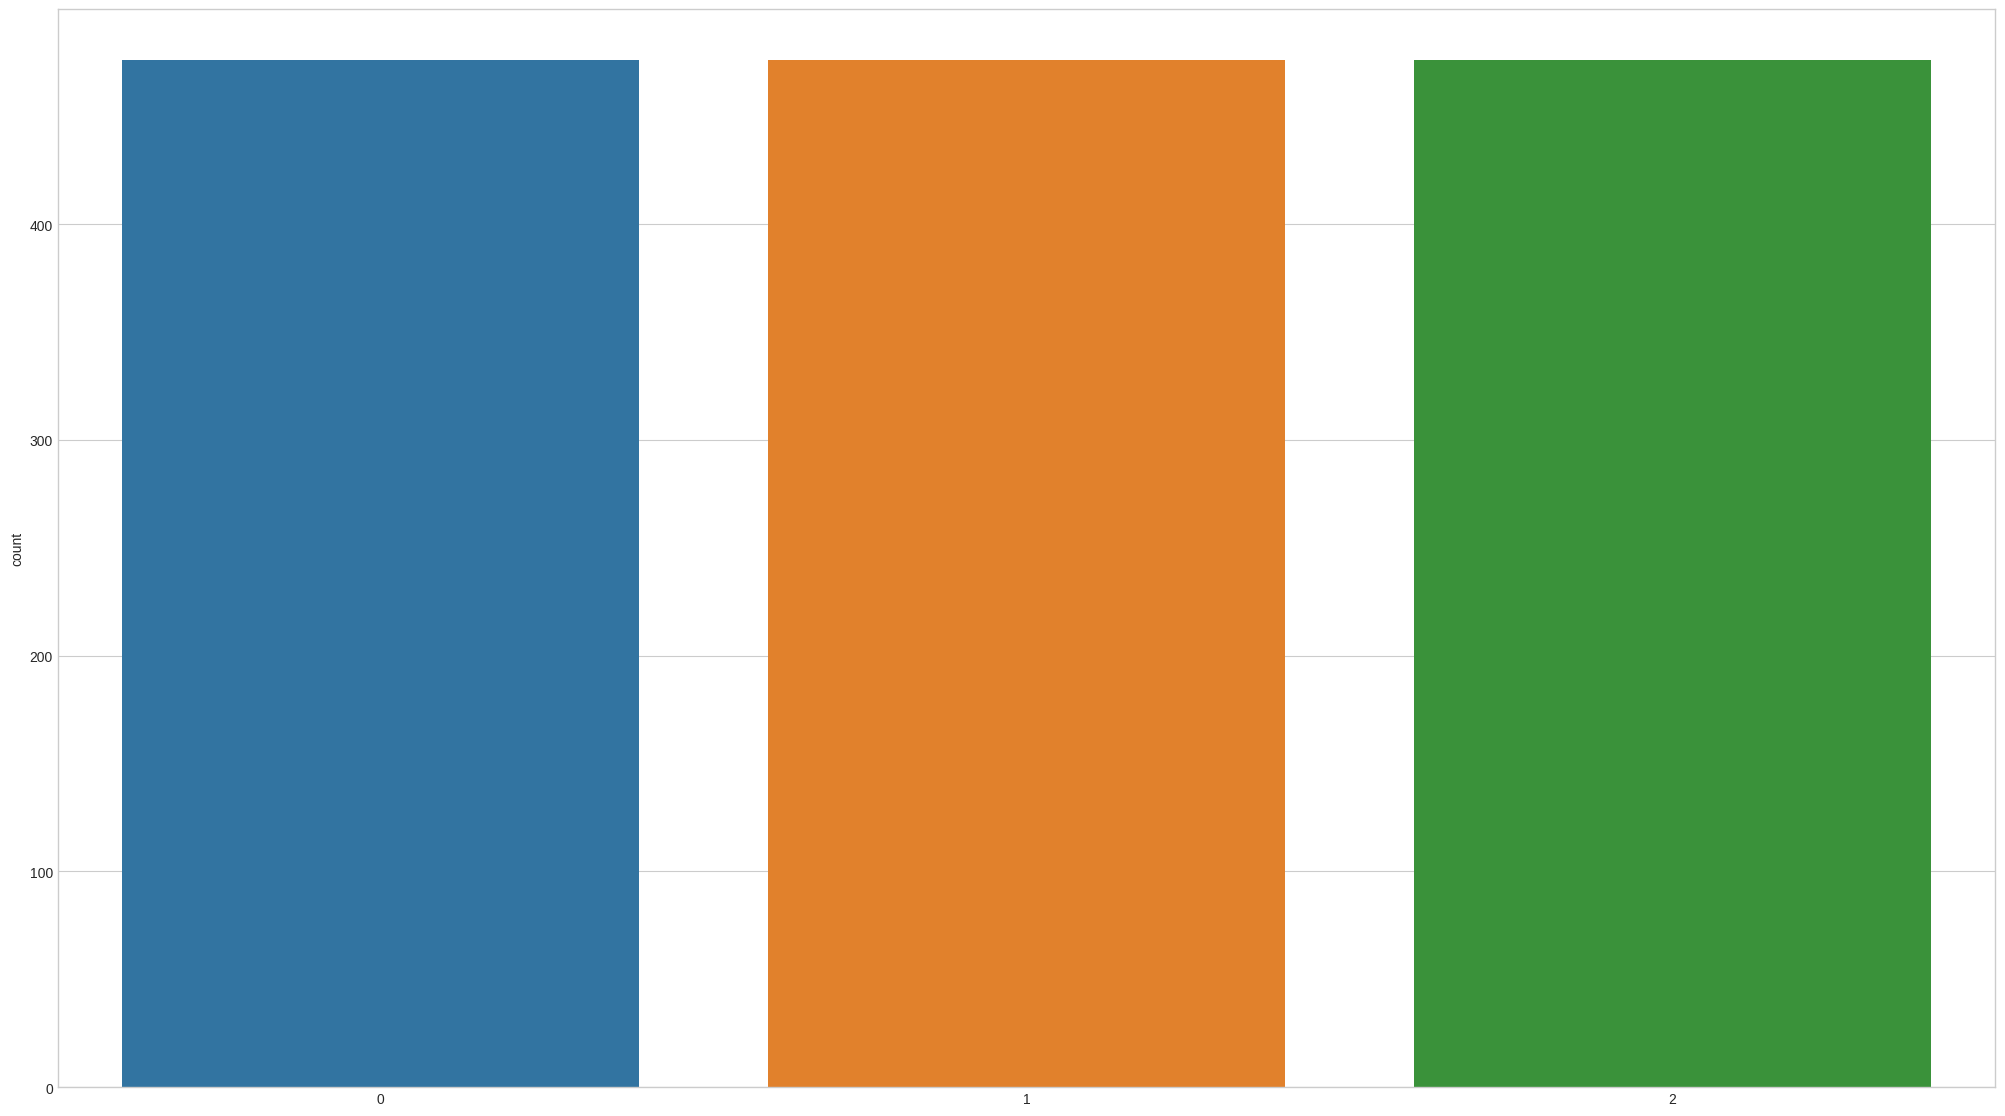

In [532]:
#import vectorizer
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.2, min_df=10, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(text['full_text'])

X = bow


#splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#balance the target using SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

#plot the count of the target
sns.countplot(y_train)


SVC(C=5.463273273273273, gamma=0.19402402402402405, max_iter=10000,
    random_state=42)
              precision    recall  f1-score   support

           0       0.25      0.19      0.21        27
           1       0.17      0.15      0.16        13
           2       0.76      0.82      0.79       110

    accuracy                           0.65       150
   macro avg       0.39      0.39      0.39       150
weighted avg       0.62      0.65      0.63       150

0.6466666666666666


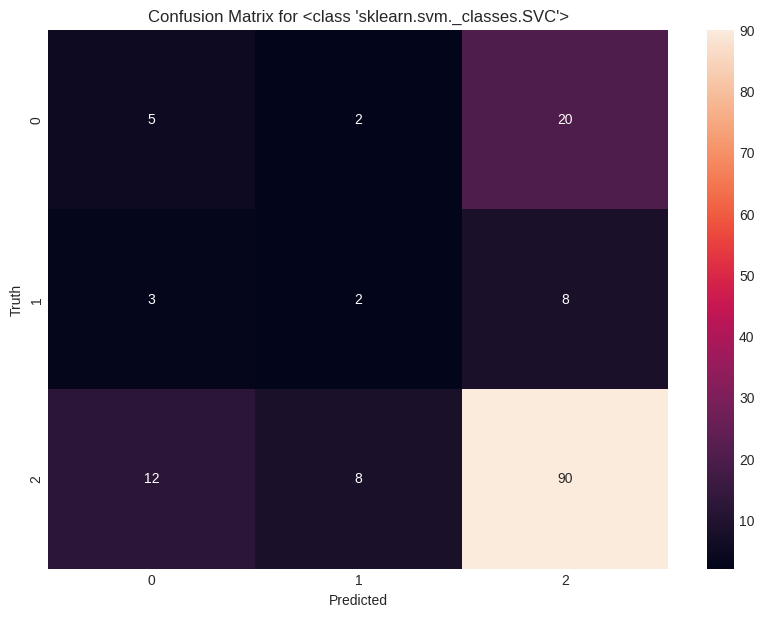

LogisticRegression(C=10.11050505050505, max_iter=10000, random_state=42)
              precision    recall  f1-score   support

           0       0.29      0.37      0.32        27
           1       0.17      0.15      0.16        13
           2       0.77      0.72      0.74       110

    accuracy                           0.61       150
   macro avg       0.41      0.41      0.41       150
weighted avg       0.63      0.61      0.62       150

0.6066666666666667


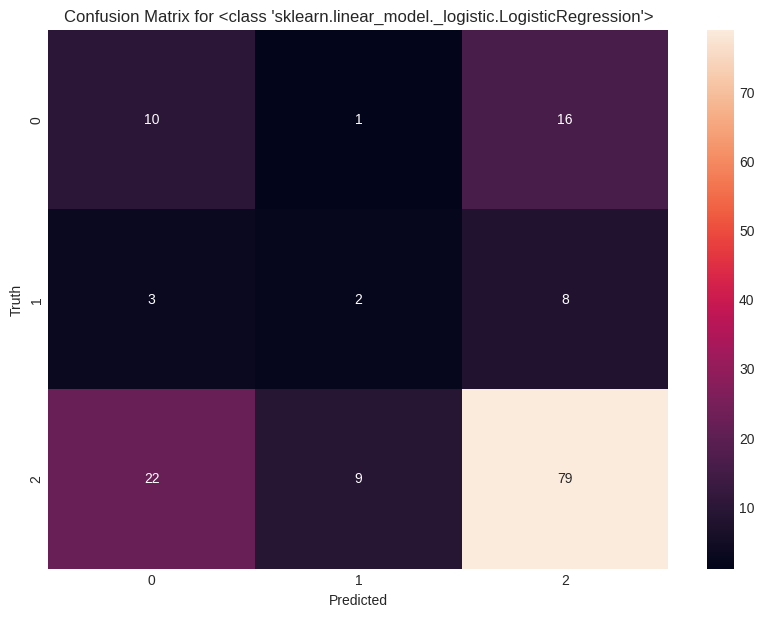

RandomForestClassifier(max_depth=65, n_estimators=605, random_state=42)
              precision    recall  f1-score   support

           0       0.24      0.33      0.28        27
           1       0.15      0.23      0.18        13
           2       0.76      0.64      0.69       110

    accuracy                           0.55       150
   macro avg       0.38      0.40      0.38       150
weighted avg       0.61      0.55      0.57       150

0.5466666666666666


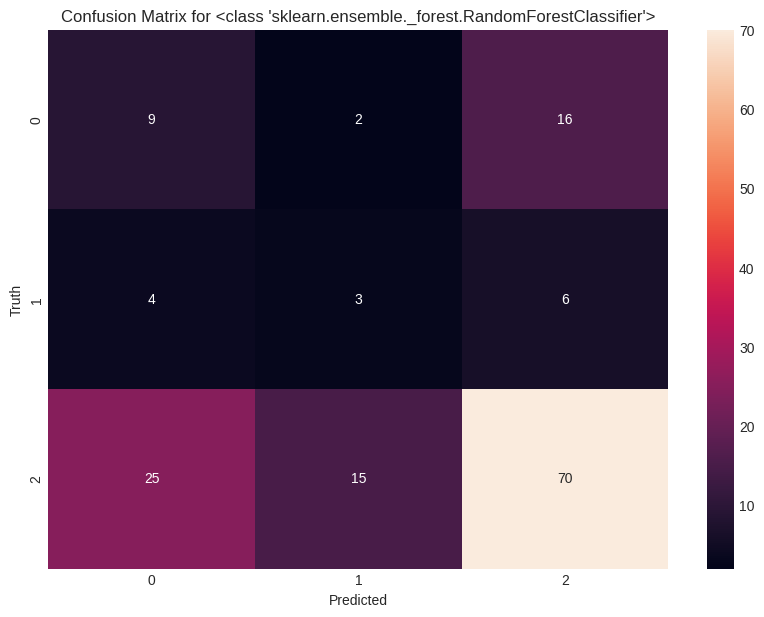

MultinomialNB(alpha=0.015325325325325326)
              precision    recall  f1-score   support

           0       0.32      0.22      0.26        27
           1       0.08      0.08      0.08        13
           2       0.74      0.79      0.76       110

    accuracy                           0.63       150
   macro avg       0.38      0.36      0.37       150
weighted avg       0.60      0.63      0.61       150

0.6266666666666667


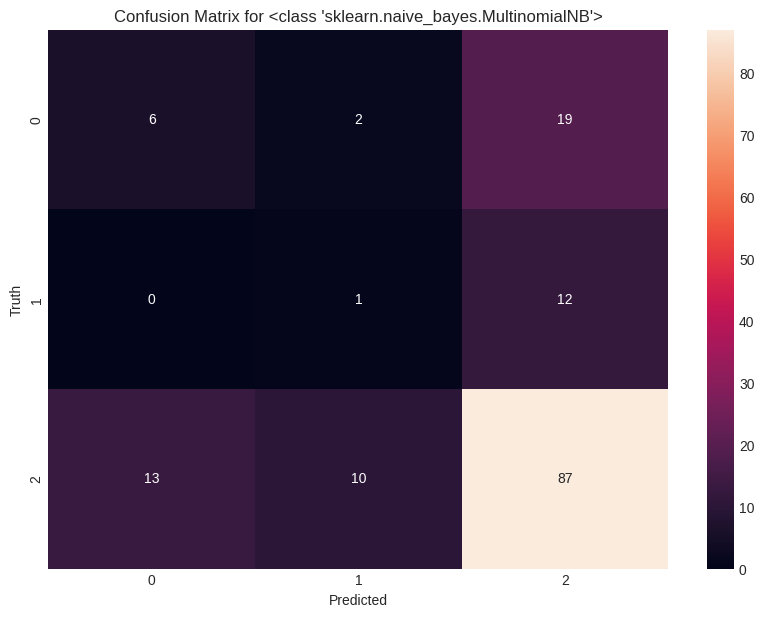

GradientBoostingClassifier(max_depth=10, n_estimators=220, random_state=42)
              precision    recall  f1-score   support

           0       0.23      0.19      0.20        27
           1       0.13      0.15      0.14        13
           2       0.74      0.76      0.75       110

    accuracy                           0.61       150
   macro avg       0.37      0.37      0.37       150
weighted avg       0.60      0.61      0.60       150

0.6066666666666667


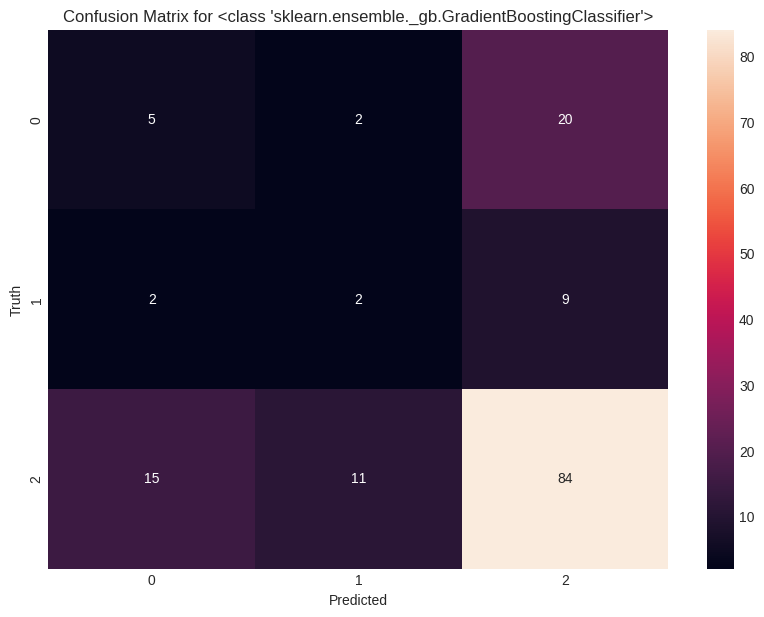

In [533]:
#building a model we want to classify the tweets
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV



#create a dictionary of models
models = {'SVC': SVC, 'LogisticRegression': LogisticRegression, 'RandomForestClassifier': RandomForestClassifier, 'MultinomialNB': MultinomialNB, 'GradientBoostingClassifier': GradientBoostingClassifier}

#loop over the models
for model in models.values():
    if model == SVC:
        #defining gridsearch parameters SVC
        param_grid = {'C': np.linspace(0.01, 25, 1000) , 'gamma': np.linspace(0.001, 0.2, 1000), 'kernel': ['rbf'], 'random_state': [42], 'max_iter': [10000]}

    elif model == LogisticRegression:
        #defining gridsearch parameters LogisticRegression
        param_grid = {'C': np.linspace(0.01,200,100 ), 'penalty': ['l1', 'l2'], 'max_iter': [10000], 'random_state': [42]}
    elif model == RandomForestClassifier:
        #defining gridsearch parameters RandomForestClassifier
        param_grid = {'n_estimators': np.arange(450, 610, 5), 'max_depth': np.arange(30, 110, 5), 'random_state': [42]}

    elif model == MultinomialNB:
        #defining gridsearch parameters MultinomialNB
        param_grid = {'alpha': np.linspace(0.01, 0.2, 1000), 'fit_prior': [True, False]}

    elif model == GradientBoostingClassifier:
        #defining gridsearch parameters GradientBoostingClassifier
        param_grid = {'n_estimators': np.arange(200, 400, 5), 'max_depth': np.arange(0, 100, 10), 'random_state': [42]}
    grid = RandomizedSearchCV(estimator = model(), param_distributions = param_grid, cv = 10, n_jobs = -1, n_iter=300, random_state=42)
    grid.fit(X_train, y_train)
    print(grid.best_estimator_)

    #predicting the values
    y_pred = grid.predict(X_test)

    #printing the results
    print(classification_report(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))

    #plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.title(f'Confusion Matrix for {model}')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

Topic modeling

In [534]:
from sklearn.decomposition import LatentDirichletAllocation
#creating a LDA model
topic_classifier = LatentDirichletAllocation(n_components=5, random_state=42)
topics = topic_classifier.fit_transform(X)



In [535]:
# Get the topic-word matrix
topic_word = topic_classifier.components_
vocab = bow_vectorizer.get_feature_names()

# Get the top 10 key words for each topic
n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-n_top_words:-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: day gallon star today year coffee home new gas
Topic 1: increased litre dairy increase mother year like pay food
Topic 2: farmer dairy food cow going year think amp new
Topic 3: egg people bread buy product come money know make
Topic 4: amp like time chocolate dairy need help tea week


# 4) Statistical analysis

Although our EDA did feature only the top 10, we can not continue with this in our statistics section as it will heavily skew our figures. When it comes to the inferential statistics section we may choose a sub set of countries at random and treat this as our sample population

In [250]:
from scipy import stats
#descriptive statistics for each numeric column in milk_eu_eda dataset
milk_eu_eda.describe()

#check if distributio each column is normal
#choose the columns that are not object
columns = milk_eu_eda.drop(['Year'], axis = 1).select_dtypes(exclude=['object'])
#create a dictionary to store the results
is_normal = {}
for area in milk_eu_eda['Area'].unique():
    for col in columns:
        test = stats.shapiro(milk_eu_eda[milk_eu_eda['Area'] == area][col])
        if test[1] > 0.05:
            is_normal[f'{area} {col}'] = 'normal'
        else:
            is_normal[f'{area} {col}'] = 'not normal'



We can see that none of these columns have normally distributed dataWhen separated by country we can see that some of the columns are normal, but not all. We have made a dictionary of normal and not normal columns

In [251]:
#this function will generage descriptive stats for the values in each column per country
def descriptive_stats(column, country):
    #check if the column is numeric
    if milk_eu_eda[column].dtype != 'object':
       #check if normal
        if is_normal[f'{country} {column}'] == 'normal':
            #get mean and standard deviation for the column
            mean = milk_eu_eda[milk_eu_eda['Area'] == country][column].mean()
            std = milk_eu_eda[milk_eu_eda['Area'] == country][column].std()

            return mean, std
        else:
            #get median, 25th percentile and 75th percentile for the column, max and min if not normal
            median = milk_eu_eda[milk_eu_eda['Area'] == country][column].median()
            q1 = milk_eu_eda[milk_eu_eda['Area'] == country][column].quantile(0.25)
            q3 = milk_eu_eda[milk_eu_eda['Area'] == country][column].quantile(0.75)
            max = milk_eu_eda[milk_eu_eda['Area'] == country][column].max()
            min = milk_eu_eda[milk_eu_eda['Area'] == country][column].min()

            return median, q1, q3, max, min
    else:
        pass

#loop over each country and their columns using this function and store the results in a dictionary
descriptive_stats_dict = {}
for country in milk_eu_eda['Area'].unique():
    for col in columns:
        descriptive_stats_dict[f'{country} {col}'] = descriptive_stats(col, country)
        

     



In [252]:
descriptive_stats_dict

{'Austria Head': (539584.0, 532438.75, 620121.0, 865392.0, 524070.0),
 'Austria Tonne': (3274025.5, 3148759.75, 3390311.75, 3821190.0, 2948170.0),
 'Austria Land under temp. meadows and pastures': (152.478,
  0.0,
  161.05,
  170.1,
  0.0),
 'Austria Land under perm. meadows and pastures': (1404.1,
  1308.8449999999998,
  1483.4750000000001,
  1512.9,
  1258.81),
 'Austria Value': (405.2300000000002, 76.89889084891344),
 'Austria Export Value': (150629500.0,
  64398750.0,
  279222500.0,
  378428000.0,
  2543000.0),
 'Austria Export Quantity': (368852.5, 203465.0, 528006.495, 634776.0, 3356.0),
 'Austria Temperature_C': (7.427666666666666, 0.6764393763561206),
 'Austria Rainfall_mm/yr': (1129.2256666666665, 96.19580712360035),
 'Austria Manure_kg': (11344214.015999999,
  11193992.280000001,
  13037423.904,
  18194001.408,
  11018047.68),
 'Austria Nutrient nitrogen N (total)': (114405.25333333333,
  13379.122481276394),
 'Austria Nutrient phosphate P2O5 (total)': (41501.848666666665,
  

In [253]:
#stats for head dataframes
head = pd.DataFrame()
head['Country'] = milk_eu_eda['Area'].unique()
#append head descriptive stats to the head dataframe
def stats_list(measure):
    stats = []
    for country in milk_eu_eda['Area'].unique():
        for col in columns:
            if col == measure:
                stats.append(descriptive_stats_dict[f'{country} {col}'])
            else:
                pass
    return stats

In [404]:
milk_eu_eda.columns

Index(['Area', 'Year', 'Head', 'Tonne',
       'Land under temp. meadows and pastures',
       'Land under perm. meadows and pastures', 'Value', 'Export Value',
       'Export Quantity', 'Temperature_C', 'Rainfall_mm/yr', 'Manure_kg',
       'Nutrient nitrogen N (total)', 'Nutrient phosphate P2O5 (total)',
       'Nutrient potash K2O (total)', 'Country Code', 'volume(litre)',
       'volume/cow(litre)', 'Total Pasture(ha)', 'Surface Area', '% Pasture',
       'Revenue(usd)', 'Revenue per cow(usd)', 'Revenue per hectare(usd)',
       'Price per litre(usd)', 'Exported volume',
       'Export Value per litre(USD)'],
      dtype='object')

In [566]:
head = stats_list('Head')
Volume = stats_list('volume(litre)')
pasture = stats_list('% Pasture')
Revenue = stats_list('Revenue(usd)')
Export = stats_list('Export Value per litre(USD)')


In [567]:
#function to add the descriptive stats to a dataframe
def add_stats(stats):
    df = pd.DataFrame(columns = ['Country', 'Mean', 'Std', 'Median', 'Q1', 'Q3', 'Max', 'Min'])
    for i,j in zip(milk_eu_eda.Area.unique(), stats):
        if len(j) == 2:
            row = [i, j[0], j[1], np.nan, np.nan, np.nan, np.nan, np.nan]

        else:
            row = [i, np.nan, np.nan, j[0], j[1], j[2], j[3], j[4]]

        #append the row to the dataframe
        df.loc[len(df)] = row
    return df



In [568]:
Head = add_stats(head)
Volume = add_stats(Volume)
Pasture = add_stats(pasture)
Revenue = add_stats(Revenue)
Export = add_stats(Export)

In [ ]:
#country to index dictionary
country_to_index = {}
for i, country in enumerate(milk_eu_eda['Area'].unique()):
    country_to_index[country] = i
    

In [339]:
#produce boxplot or normal distribution plot for each column per country
import ast
def plot_dist(country, df):
    #check if normal
    if is_normal[f'{country} {df}'] == 'normal':
        data = milk_eu_eda[milk_eu_eda['Area'] == country][str(df)]
        mean = descriptive_stats_dict[f'{country} {df}'][0]
        std = descriptive_stats_dict[f'{country} {df}'][1]
        x = np.linspace(mean - 5*std, mean + 5*std, 100)
        plt.plot(x, stats.norm.pdf(x, mean, std))
        plt.hist(data, bins = 10, alpha = 0.5, density = True, color = 'gray')
        plt.title(f'{country} {df} Distribution', fontsize = 25)
        plt.xlabel(f'{df}', fontsize = 20)
        plt.show()

    else:
        data = milk_eu_eda[milk_eu_eda['Area'] == country][str(df)]
        sns.boxplot(data)
        plt.title(f'{country} {df} Distribution', fontsize = 25)
        plt.xlabel(f'{df}', fontsize = 20)
        plt.show()
 


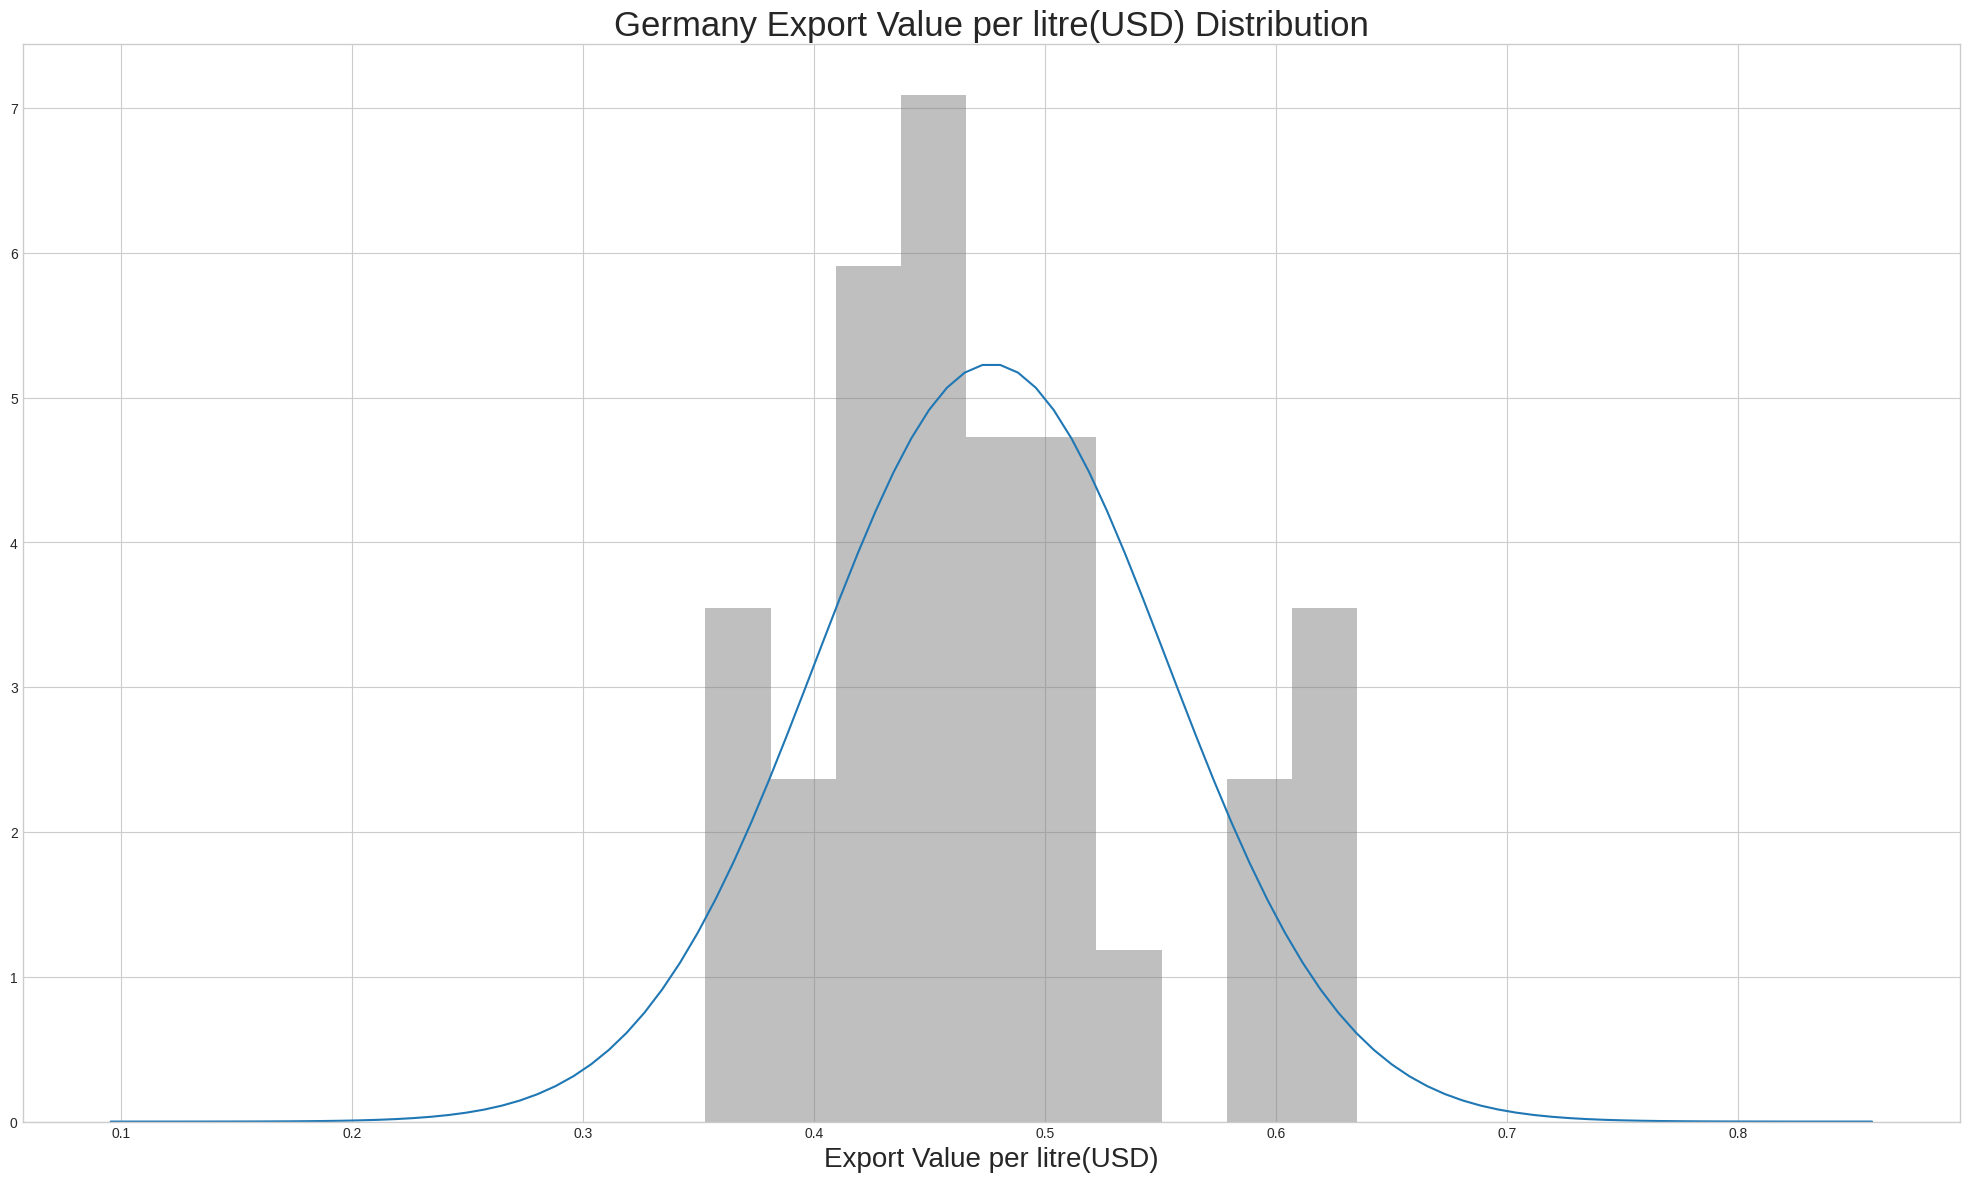

In [343]:
plot_dist('Germany', 'Export Value per litre(USD)')

### b) Confidence interval


on population proportion of % pasture usage above 0.15

In [362]:
#create a dataframe that has all the % pasture land per country in 2020
pasture_2020 = milk_eu_eda[milk_eu_eda['Year'] == 2020][['Area', '% Pasture']]
pasture_2020.head()

#test distribution of % pasture land
dist = stats.shapiro(pasture_2020['% Pasture'])
print(dist)
#sample proportion
meet_cond = pasture_2020[pasture_2020['% Pasture'] > 0.15].shape[0]
total = pasture_2020.shape[0]

#confidence interval for population proportion
from statsmodels.stats.proportion import proportion_confint
proportion_confint(meet_cond, total, alpha = 0.01)


ShapiroResult(statistic=0.8209128379821777, pvalue=0.0004081373626831919)


(0.2866290838983006, 0.7902939930247763)

This uses a normal approximation to the binomial distribution to calculate the CI, even if the data isnt normally distributed, so is nonparametric. I have chosen a larger level of confidence here as the sample size is rather small and this methods accuracy scales with sample size

In [364]:
Head_2020 = milk_eu_eda[milk_eu_eda['Year'] == 2020][['Area', 'Head']]

#check if normal
dist = stats.shapiro(Head_2020['Head'])
dist

ShapiroResult(statistic=0.7168135643005371, pvalue=9.084725206776056e-06)

This is NOT normal, so we will be looking at calculating a CI on the median

In [401]:
#sample median 

#sort the data
Head_2020.sort_values(by = 'Head', inplace = True)

#confidence interval for population median
def CI_median(data):
    n = data.shape[0]
    z = 1.96
    q = 0.5
    #ci given by index +/1 z*sqrt(q*(1-q))*n
    ci = z*np.sqrt(q*(1-q)*n)
    lower = np.ceil(data.shape[0]/2 - ci)-1 #subtracting one since the index starts from 0
    upper = np.ceil(data.shape[0]/2 + ci)-1
    return int(lower), int(upper)


 


In [402]:
ci_head = CI_median(Head_2020)
ci_head

(8, 17)

In [409]:
#find corresponding values
print(Head_2020.iloc[ci_head[0]][1], ',', Head_2020.iloc[ci_head[1]][1])

226000.0 , 565000.0


Now a cI on the amount of milk produced in litre

In [405]:
Volume_2020 = milk_eu_eda[milk_eu_eda['Year'] == 2020][['Area', 'volume(litre)']]

#check if normal
dist = stats.shapiro(Volume_2020['volume(litre)'])
dist

ShapiroResult(statistic=0.696869432926178, pvalue=4.805457592738094e-06)

Not normal again, so we will use the ci on the median

In [406]:
ci_volume = CI_median(Volume_2020)
ci_volume

(8, 17)

In [408]:
#find the corresponding values
print(Volume_2020.iloc[ci_volume[0]][1], ',', Volume_2020.iloc[ci_volume[1]][1])

2343252190.847128 , 435579357.3515093


Looking at the total milk production over the years


<AxesSubplot:xlabel='Year'>

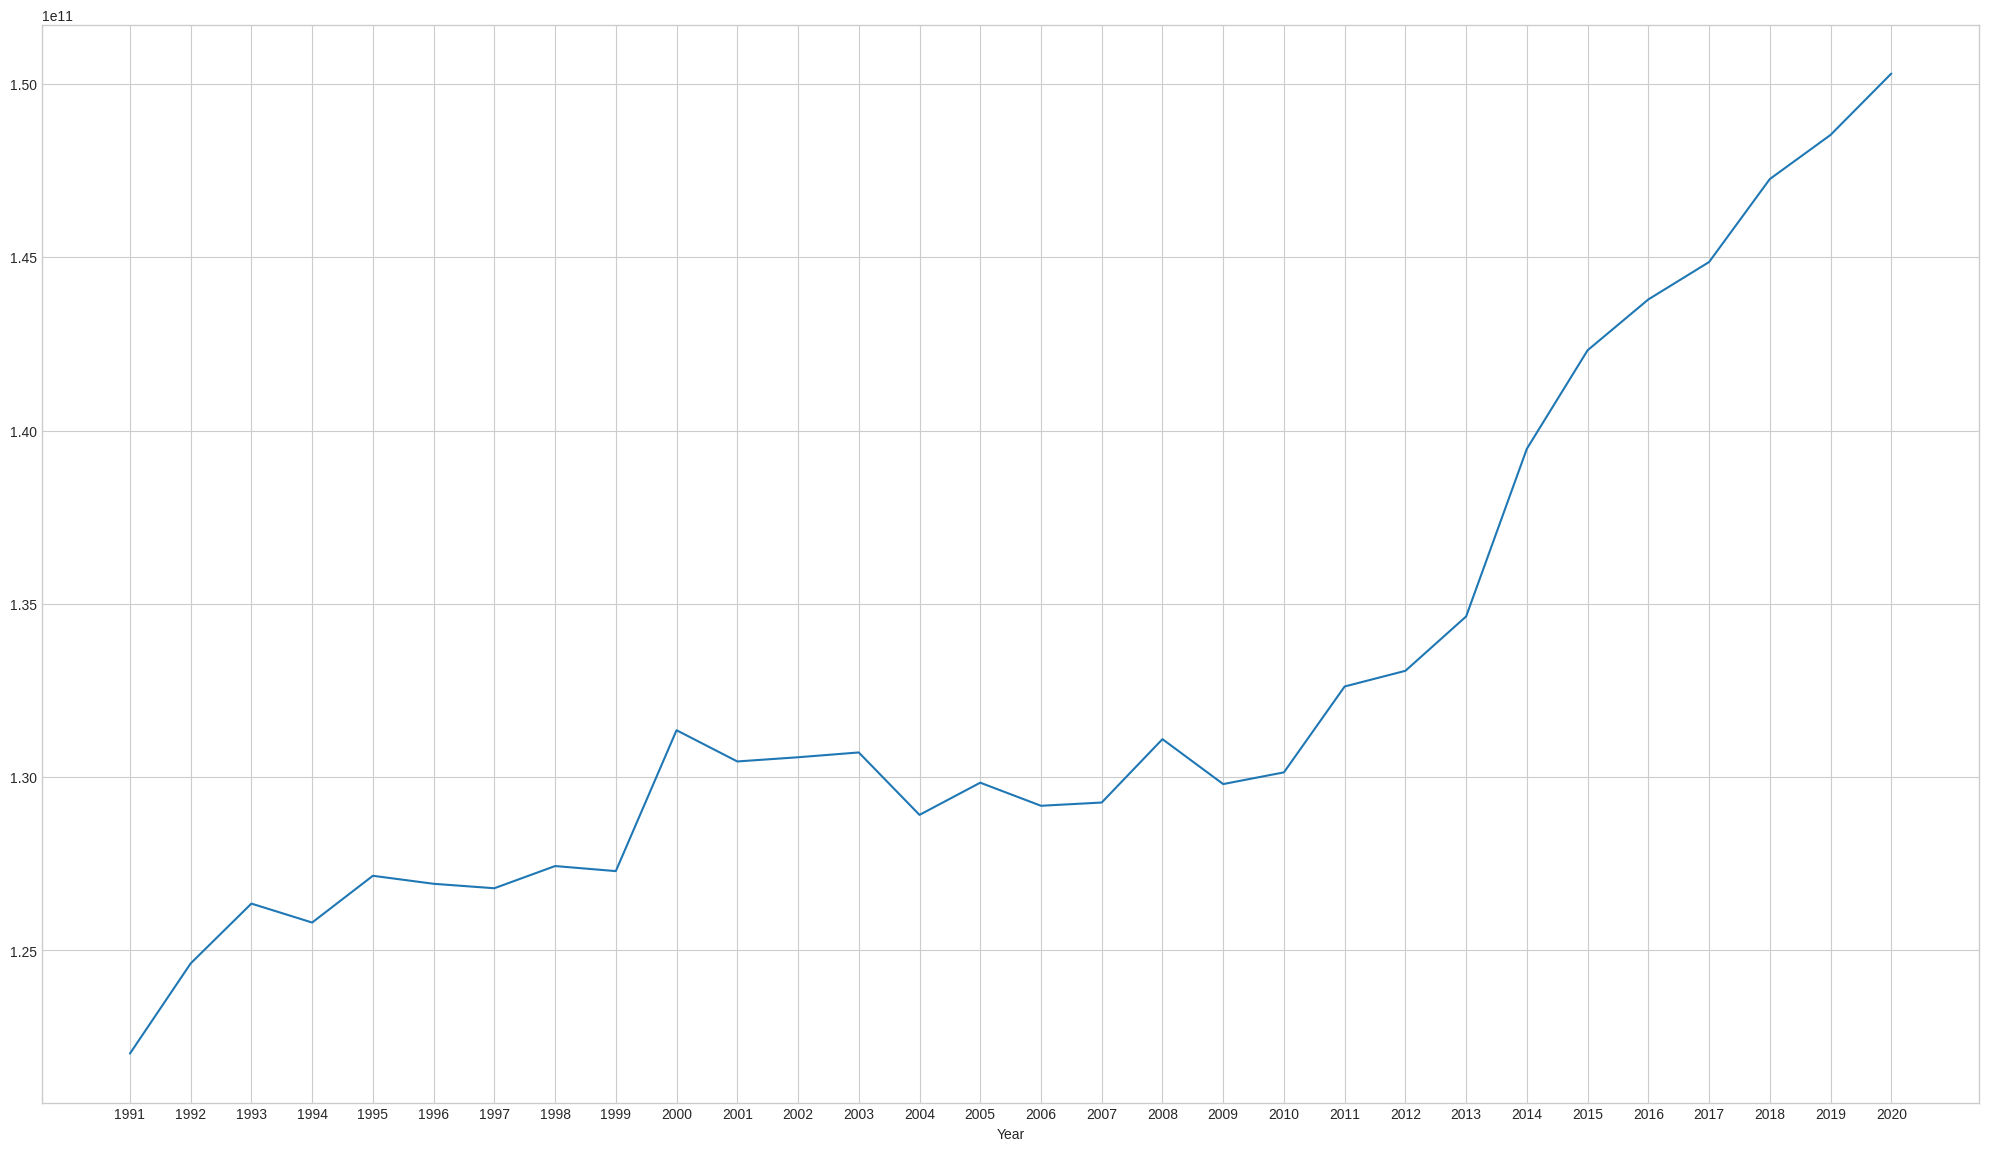

In [419]:
#group the volumes by year
Volume_year = milk_eu_eda.groupby('Year')['volume(litre)'].sum()
Volume_year.plot(xticks=Volume_year.index)

# comapring means of ireland, france and netherlands herd count over the years

In [537]:
Head

Country          Mean            Std     Median          Q1  \
0       Austria           NaN            NaN   539584.0   532438.75   
1       Belgium           NaN            NaN   524580.0   507327.00   
2      Bulgaria  3.473629e+05   73826.461678        NaN         NaN   
3       Croatia  2.246806e+05   65335.994065        NaN         NaN   
4        Cyprus           NaN            NaN    20227.0    19262.25   
5       Czechia           NaN            NaN   416375.5   370586.25   
6       Denmark           NaN            NaN   584764.5   564448.75   
7       Estonia           NaN            NaN   112800.0    96500.00   
8       Finland           NaN            NaN   314087.0   285171.75   
9        France  4.033170e+06  419603.354922        NaN         NaN   
10      Germany           NaN            NaN  4286819.5  4190198.50   
11       Greece           NaN            NaN   215402.5   158505.00   
12      Hungary  3.351267e+05   74904.159147        NaN         NaN   
13      Ireland  1.217560e+06  113024.951079        NaN         NaN   
14        Italy           NaN            NaN  1894700.0  1838250.00   
15       Latvia           NaN            NaN   185200.0   164600.00   
16    Lithuania  4.348421e+05  142701.937733        NaN         NaN   
17   Luxembourg           NaN            NaN    46195.0    43956.00   
18  Netherlands  1.606713e+06   95864.824365        NaN         NaN   
19       Poland           NaN            NaN  2760597.0  2380757.25   
20     Portugal           NaN            NaN   277500.0   239750.00   
21      Romania           NaN            NaN  1546050.0  1191204.25   
22     Slovakia           NaN            NaN   191765.0   148922.75   
23     Slovenia           NaN            NaN   120273.0   109571.00   
24        Spain           NaN            NaN   989724.5   832253.50   
25       Sweden           NaN            NaN   390396.5   344878.00   

            Q3        Max        Min  
0    620121.00   865392.0   524070.0  
1    537960.00   625139.0   460307.0  
2          NaN        NaN        NaN  
3          NaN        NaN        NaN  
4     21691.25    36710.0    16604.0  
5    523813.25   874095.0   357010.0  
6    661750.00   747000.0   545424.0  
7    158600.00   260336.0    84300.0  
8    380425.00   440900.0   255620.0  
9          NaN        NaN        NaN  
10  4921550.00  5632000.0  3921410.0  
11   228545.25   245000.0    86000.0  
12         NaN        NaN        NaN  
13         NaN        NaN        NaN  
14  2122750.00  2642000.0  1746140.0  
15   242100.00   531400.0   136040.0  
16         NaN        NaN        NaN  
17    48607.00    54230.0    42193.0  
18         NaN        NaN        NaN  
19  3170943.00  4549296.0  2125700.0  
20   368250.00   386000.0   231000.0  
21  1666250.00  1898108.0  1138800.0  
22   259204.25   429171.0   122050.0  
23   140236.00   220023.0    99210.0  
24  1247132.50  1566000.0   726131.0  
25   448880.00   528200.0   301380.0

Comparison of distributions

In [550]:
#anova test on ireland, netherlands, and france using two wat anova
ireland = milk_eu_eda[(milk_eu_eda['Area'] == 'Ireland')]['Head']
netherlands = milk_eu_eda[(milk_eu_eda['Area'] == 'Netherlands')]['Head']
france = milk_eu_eda[(milk_eu_eda['Area'] == 'France')]['Head']



In [555]:
#check if equal variance
from scipy import stats
stats.levene(ireland, netherlands, france)

LeveneResult(statistic=33.766848128535365, pvalue=1.4014532479241293e-11)

The variances are unequal so we may not use anova. instead we will use a non parametric test, such as the Friedman test or friedman two way anova

null-hypothesis: there is no significant differences between the mean

Alt-hypothesis: there is a significant diffewrence between the means

In [558]:
#running a friedman test
head_friedman = stats.friedmanchisquare(ireland, netherlands, france)
print(head_friedman)


if head_friedman[1] < 0.05:
    print('Reject the null hypothesis')

FriedmanchisquareResult(statistic=60.0, pvalue=9.357622968840163e-14)
Reject the null hypothesis


# Comparing distributions in volume of milk produced

In [579]:
Volume.sort_values(by = 'Median', inplace = True)
Volume

Country          Mean           Std        Median            Q1  \
4        Cyprus           NaN           NaN  1.458836e+08  1.346154e+08   
17   Luxembourg           NaN           NaN  2.817868e+08  2.626203e+08   
3       Croatia           NaN           NaN  6.529698e+08  6.053486e+08   
11       Greece           NaN           NaN  7.222692e+08  6.801042e+08   
15       Latvia           NaN           NaN  8.880136e+08  8.062902e+08   
22     Slovakia           NaN           NaN  1.042675e+09  9.091916e+08   
16    Lithuania           NaN           NaN  1.739970e+09  1.673260e+09   
20     Portugal           NaN           NaN  1.904263e+09  1.801534e+09   
5       Czechia           NaN           NaN  2.739728e+09  2.706541e+09   
25       Sweden           NaN           NaN  3.069620e+09  2.827726e+09   
0       Austria           NaN           NaN  3.187951e+09  3.065978e+09   
6       Denmark           NaN           NaN  4.562415e+09  4.506524e+09   
13      Ireland           NaN           NaN  5.186514e+09  5.097663e+09   
24        Spain           NaN           NaN  6.196368e+09  6.023223e+09   
14        Italy           NaN           NaN  1.082809e+10  1.040628e+10   
18  Netherlands           NaN           NaN  1.093472e+10  1.070163e+10   
19       Poland           NaN           NaN  1.209303e+10  1.162384e+10   
9        France           NaN           NaN  2.273872e+10  2.241187e+10   
10      Germany           NaN           NaN  2.792510e+10  2.758711e+10   
1       Belgium  3.389030e+09  5.003943e+08           NaN           NaN   
2      Bulgaria  1.164764e+09  1.941666e+08           NaN           NaN   
7       Estonia  7.064526e+08  7.436445e+07           NaN           NaN   
8       Finland  2.356912e+09  6.802825e+07           NaN           NaN   
12      Hungary  1.919276e+09  1.665677e+08           NaN           NaN   
21      Romania  4.188913e+09  4.937275e+08           NaN           NaN   
23     Slovenia  6.116943e+08  3.450834e+07           NaN           NaN   

              Q3           Max           Min  
4   1.580962e+08  2.679260e+08  1.012658e+08  
17  3.371500e+08  4.355794e+08  2.575268e+08  
3   7.487829e+08  8.366680e+08  5.782434e+08  
11  7.681507e+08  7.868549e+08  6.047722e+08  
15  9.544304e+08  1.437585e+09  7.625628e+08  
22  1.113462e+09  1.217137e+09  8.804869e+08  
16  1.829719e+09  2.353671e+09  1.448880e+09  
20  1.944943e+09  2.047672e+09  1.545278e+09  
5   3.033140e+09  3.363019e+09  2.602412e+09  
25  3.189630e+09  3.331061e+09  2.633291e+09  
0   3.301180e+09  3.720730e+09  2.870662e+09  
6   4.943812e+09  5.517040e+09  4.288900e+09  
13  5.425436e+09  8.336388e+09  4.928189e+09  
24  6.470369e+09  7.406105e+09  5.683780e+09  
14  1.122332e+10  1.237827e+10  1.012411e+10  
18  1.181591e+10  1.417235e+10  1.039630e+10  
19  1.276656e+10  1.443215e+10  1.133631e+10  
9   2.363235e+10  2.495332e+10  2.205753e+10  
10  3.034198e+10  3.229300e+10  2.713357e+10  
1            NaN           NaN           NaN  
2            NaN           NaN           NaN  
7            NaN           NaN           NaN  
8            NaN           NaN           NaN  
12           NaN           NaN           NaN  
21           NaN           NaN           NaN  
23           NaN           NaN           NaN

Upon visual inspection ireland, spain, and denmark seem to have somewhat similar medians, on the same order of magnitude at the very least. since there are 3 non normal samples of data we will use kruskal wallis test

In [581]:
ireland = milk_eu_eda[(milk_eu_eda['Area'] == 'Ireland')]['volume(litre)']
denmark = milk_eu_eda[(milk_eu_eda['Area'] == 'Denmark')]['volume(litre)']
spain = milk_eu_eda[(milk_eu_eda['Area'] == 'Spain')]['volume(litre)']

#run a kruskal wallis test
volume_kruskal = stats.kruskal(ireland, denmark, spain)
print(volume_kruskal)
if volume_kruskal[1] < 0.05:
    print('Reject the null hypothesis')



KruskalResult(statistic=54.70984126984126, pvalue=1.3179802893619678e-12)
Reject the null hypothesis


It appears as though our visual inspection was wrong, and there is infact a rather significant difference between irelands median and the two closest other values, denmark and spain. Even if we were to carry out a non-parametric test including the normal data, there is unlinkey to be a different outcome as in a normal distrinution the mean and median should be similar(or identifical if perfectly symmetrical) and even the closest means are likely not close enough to irelands median.

# Comparing the distribution in precentage of land that is used for pasture

In [584]:
Pasture.sort_values(by = 'Mean', inplace = True)
Pasture

Country      Mean       Std    Median        Q1        Q3       Max  \
5       Czechia  0.122150  0.006141       NaN       NaN       NaN       NaN   
0       Austria  0.178576  0.006764       NaN       NaN       NaN       NaN   
1       Belgium  0.189670  0.008149       NaN       NaN       NaN       NaN   
13      Ireland  0.576657  0.014575       NaN       NaN       NaN       NaN   
2      Bulgaria       NaN       NaN  0.163466  0.142092  0.171110  0.180377   
3       Croatia       NaN       NaN  0.114040  0.053716  0.145598  0.194190   
4        Cyprus       NaN       NaN  0.001979  0.001189  0.002381  0.004648   
6       Denmark       NaN       NaN  0.171738  0.084641  0.179665  0.193066   
7       Estonia       NaN       NaN  0.102616  0.053729  0.106286  0.110775   
8       Finland       NaN       NaN  0.019783  0.003324  0.020448  0.023934   
9        France       NaN       NaN  0.198410  0.173714  0.203718  0.207572   
10      Germany       NaN       NaN  0.190023  0.147719  0.208323  0.219062   
11       Greece       NaN       NaN  0.317107  0.268278  0.369346  0.399500   
12      Hungary       NaN       NaN  0.111794  0.088602  0.123377  0.126091   
14        Italy       NaN       NaN  0.201138  0.147219  0.213375  0.220385   
15       Latvia       NaN       NaN  0.133580  0.124061  0.138303  0.142005   
16    Lithuania       NaN       NaN  0.166753  0.076723  0.176309  0.223277   
17   Luxembourg       NaN       NaN  0.307309  0.305298  0.308855  0.314640   
18  Netherlands       NaN       NaN  0.239904  0.236374  0.245651  0.258065   
19       Poland       NaN       NaN  0.104932  0.101878  0.129286  0.132276   
20     Portugal       NaN       NaN  0.197487  0.137378  0.200524  0.235778   
21      Romania       NaN       NaN  0.221779  0.206048  0.229403  0.259322   
22     Slovakia       NaN       NaN  0.119675  0.118176  0.170280  0.176397   
23     Slovenia       NaN       NaN  0.162285  0.154886  0.197613  0.203803   
24        Spain       NaN       NaN  0.217345  0.208042  0.231718  0.248128   
25       Sweden       NaN       NaN  0.033215  0.012792  0.033872  0.035293   

         Min  
5        NaN  
0        NaN  
1        NaN  
13       NaN  
2   0.130954  
3   0.045588  
4   0.001081  
6   0.045714  
7   0.023216  
8   0.000621  
9   0.160959  
10  0.141355  
11  0.200548  
12  0.083201  
14  0.139512  
15  0.093868  
16  0.070444  
17  0.251353  
18  0.215508  
19  0.098919  
20  0.090998  
21  0.200427  
22  0.109224  
23  0.141568  
24  0.203205  
25  0.008259

The three we will look at are ireland, austria and belgium. It appears as though irelands mean is significantly diffewrent to other countries, so we will check this below

In [623]:
ireland = milk_eu_eda[(milk_eu_eda['Area'] == 'Ireland')]['% Pasture']
austria = milk_eu_eda[(milk_eu_eda['Area'] == 'Austria')]['% Pasture']
belgium = milk_eu_eda[(milk_eu_eda['Area'] == 'Belgium')]['% Pasture']



In [624]:
#compare the variance
stats.levene(ireland, austria, belgium)

LeveneResult(statistic=10.98718855263564, pvalue=6.252157859811706e-05)

The variance of each distribution is not equal. This means that the Anova test may not be ideal for this scenario. Instead we will use the the Friedman test

In [625]:
H_0 = 'The means are equal'
H_A = 'The means are significantly different'

In [630]:
#kruskal wallis test
pasture_kruskal = stats.kruskal(ireland, austria, belgium)
print(pasture_kruskal)
if pasture_kruskal[1] < 0.05:
    print('Reject the null hypothesis')

KruskalResult(statistic=63.379790940766554, pvalue=1.7268446328900633e-14)
Reject the null hypothesis


In [595]:
Revenue.sort_values(by = 'Median', inplace = True)
Revenue

Country          Mean           Std        Median            Q1  \
4        Cyprus           NaN           NaN  7.972615e+07  4.278889e+07   
15       Latvia           NaN           NaN  2.335980e+08  1.578266e+08   
22     Slovakia           NaN           NaN  2.825724e+08  2.514718e+08   
11       Greece           NaN           NaN  3.105240e+08  2.812043e+08   
20     Portugal           NaN           NaN  6.649987e+08  6.377871e+08   
8       Finland           NaN           NaN  1.075405e+09  1.011386e+09   
21      Romania           NaN           NaN  1.779202e+09  8.504739e+08   
13      Ireland           NaN           NaN  1.854058e+09  1.588644e+09   
19       Poland           NaN           NaN  3.498929e+09  2.151148e+09   
17   Luxembourg  1.237003e+08  2.900525e+07           NaN           NaN   
23     Slovenia  2.085575e+08  4.029384e+07           NaN           NaN   
7       Estonia  2.101141e+08  7.754460e+07           NaN           NaN   
3       Croatia  2.409532e+08  7.914241e+07           NaN           NaN   
2      Bulgaria  3.676552e+08  9.708097e+07           NaN           NaN   
16    Lithuania  4.011996e+08  1.829704e+08           NaN           NaN   
12      Hungary  5.981646e+08  1.256402e+08           NaN           NaN   
5       Czechia  9.366174e+08  2.738582e+08           NaN           NaN   
1       Belgium  1.226134e+09  2.392122e+08           NaN           NaN   
25       Sweden  1.317009e+09  1.947974e+08           NaN           NaN   
0       Austria  1.348375e+09  2.970004e+08           NaN           NaN   
6       Denmark  2.019496e+09  3.858898e+08           NaN           NaN   
24        Spain  2.352347e+09  4.671758e+08           NaN           NaN   
18  Netherlands  4.609471e+09  8.220215e+08           NaN           NaN   
14        Italy  5.140450e+09  7.054618e+08           NaN           NaN   
9        France  9.231860e+09  1.543406e+09           NaN           NaN   
10      Germany  1.129029e+10  2.177025e+09           NaN           NaN   

              Q3           Max           Min  
4   1.131190e+08  1.867511e+08  2.756000e+07  
15  3.171134e+08  3.740919e+08  1.103012e+08  
22  3.328543e+08  5.021938e+08  1.951543e+08  
11  3.962267e+08  4.994866e+08  2.314222e+08  
20  7.904102e+08  1.072504e+09  5.487846e+08  
8   1.353101e+09  2.038383e+09  7.742316e+08  
21  2.420271e+09  3.082425e+09  4.616483e+08  
13  2.270450e+09  3.223393e+09  1.291495e+09  
19  4.843066e+09  5.643507e+09  1.406695e+09  
17           NaN           NaN           NaN  
23           NaN           NaN           NaN  
7            NaN           NaN           NaN  
3            NaN           NaN           NaN  
2            NaN           NaN           NaN  
16           NaN           NaN           NaN  
12           NaN           NaN           NaN  
5            NaN           NaN           NaN  
1            NaN           NaN           NaN  
25           NaN           NaN           NaN  
0            NaN           NaN           NaN  
6            NaN           NaN           NaN  
24           NaN           NaN           NaN  
18           NaN           NaN           NaN  
14           NaN           NaN           NaN  
9            NaN           NaN           NaN  
10           NaN           NaN           NaN

In [600]:
ireland = milk_eu_eda[(milk_eu_eda['Area'] == 'Ireland')]['Revenue(usd)']
Romania = milk_eu_eda[(milk_eu_eda['Area'] == 'Romania')]['Revenue(usd)']
#mann whitney test
revenue_mann = stats.mannwhitneyu(ireland, Romania, alternative = 'two-sided')
print(revenue_mann)
if revenue_mann[1] > 0.05:
    print('Accept the null hypothesis')
else:
    print('Reject the null hypothesis')

MannwhitneyuResult(statistic=541.0, pvalue=0.18089953349792298)
Accept the null hypothesis


In [634]:
Export.sort_values(by = 'Median', inplace = True)
Export

Country      Mean       Std    Median        Q1        Q3       Max  \
15       Latvia       NaN       NaN  0.363697  0.297823  0.427808  0.815131   
17   Luxembourg       NaN       NaN  0.433149  0.418143  0.564112  0.901451   
13      Ireland       NaN       NaN  0.469575  0.390061  0.547829  0.923087   
19       Poland       NaN       NaN  0.535863  0.465026  0.644288  1.521764   
25       Sweden       NaN       NaN  0.585404  0.437851  0.782500  3.252167   
24        Spain       NaN       NaN  0.595069  0.464339  0.814718  1.122222   
3       Croatia       NaN       NaN  0.635927  0.570595  0.716643  2.373280   
21      Romania       NaN       NaN  0.688184  0.551189  0.958825  9.243000   
14        Italy       NaN       NaN  0.711125  0.551299  0.793285  1.136091   
4        Cyprus       NaN       NaN  1.027000  0.298022  2.496181  9.243000   
0       Austria  0.527884  0.148009       NaN       NaN       NaN       NaN   
1       Belgium  0.499769  0.085000       NaN       NaN       NaN       NaN   
2      Bulgaria  0.731233  0.345883       NaN       NaN       NaN       NaN   
5       Czechia  0.369325  0.107759       NaN       NaN       NaN       NaN   
6       Denmark  0.639522  0.117958       NaN       NaN       NaN       NaN   
7       Estonia  0.369956  0.131013       NaN       NaN       NaN       NaN   
8       Finland  0.826286  0.273923       NaN       NaN       NaN       NaN   
9        France  0.519045  0.093547       NaN       NaN       NaN       NaN   
10      Germany  0.476639  0.076241       NaN       NaN       NaN       NaN   
11       Greece  0.869005  0.208774       NaN       NaN       NaN       NaN   
12      Hungary  0.369589  0.108013       NaN       NaN       NaN       NaN   
16    Lithuania  0.401090  0.104008       NaN       NaN       NaN       NaN   
18  Netherlands  0.496543  0.108427       NaN       NaN       NaN       NaN   
20     Portugal  0.493978  0.102957       NaN       NaN       NaN       NaN   
22     Slovakia  0.442715  0.152615       NaN       NaN       NaN       NaN   
23     Slovenia  0.413298  0.089015       NaN       NaN       NaN       NaN   

         Min  
15  0.177210  
17  0.321620  
13  0.324202  
19  0.372063  
25  0.180207  
24  0.398349  
3   0.390907  
21  0.515884  
14  0.488688  
4   0.000000  
0        NaN  
1        NaN  
2        NaN  
5        NaN  
6        NaN  
7        NaN  
8        NaN  
9        NaN  
10       NaN  
11       NaN  
12       NaN  
16       NaN  
18       NaN  
20       NaN  
22       NaN  
23       NaN

In [641]:
ireland = milk_eu_eda[(milk_eu_eda['Area'] == 'Ireland')][['Export Value per litre(USD)']]
denmark = milk_eu_eda[(milk_eu_eda['Area'] == 'Denmark')][['Export Value per litre(USD)']]
spain = milk_eu_eda[(milk_eu_eda['Area'] == 'Spain')][['Export Value per litre(USD)']]
netherlands = milk_eu_eda[(milk_eu_eda['Area'] == 'Netherlands')][['Export Value per litre(USD)']]
france = milk_eu_eda[(milk_eu_eda['Area'] == 'France')][['Export Value per litre(USD)']]
germany = milk_eu_eda[(milk_eu_eda['Area'] == 'Germany')][['Export Value per litre(USD)']]


In [644]:
#run friedman test
export_friedman = stats.friedmanchisquare(ireland, denmark, spain, netherlands, france, germany)
print(export_friedman)
if export_friedman[1] < 0.05:
    print('Reject the null hypothesis')
else:
    print('Accept the null hypothesis')

FriedmanchisquareResult(statistic=133.21904761904773, pvalue=4.934719131530998e-27)
Reject the null hypothesis


In [648]:
#run mann whitney test
ireland_denmark = stats.mannwhitneyu(ireland, germany, alternative = 'two-sided')
print(ireland_denmark)
if ireland_denmark[1] > 0.05:
    print('Accept the null hypothesis')
else:
    print('Reject the null hypothesis')

MannwhitneyuResult(statistic=437.0, pvalue=0.8533817367547931)
Accept the null hypothesis


irelands export value is not comparable to that of the top 6 countries
